__Short summary__

In this notebook:
- [heatmaps drawn/saved for trained and not-trained models](#correlation_coefs);
- [distributions of the features (0/1 classes)](#Distribution);
- [features tables construction (for further features construction)](#features_tables).

In [1]:
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import colors
from matplotlib.colors import LogNorm    
from math import ceil
import matplotlib.cm as cm

In [2]:
from draw_functions import * # f для отрисовки heatmaps для сравнения 2 моделей
from heatmaps_coefs import * # f для расчета коэф-та корреляций и p_value

In [3]:
# features' names for the plots
topological_titles = {
    's': 'Connected strong components',
    'w': 'Connected weak components',
    'e': 'Edge number',
    'v': 'Avg. vertix degree',
    'c': 'Simple cycles',
    'b0': 'Betty 0',
    'b1': 'Betty 1'
}
barcode_feature_names = [
    'h0_s', 
    'h0_e',
    'h0_t_d', 
    'h0_n_d_m_t0.75',
    'h0_n_d_m_t0.5',
    'h0_n_d_l_t0.25',
    'h1_t_b',
    'h1_n_b_m_t0.25',
    'h1_n_b_l_t0.95', 
    'h1_n_b_l_t0.70',  
    'h1_s',
    'h1_e',
    'h1_v',
    'h1_nb'
]
barcode_titles = {
    'h0_s': 'h0, sum of lengths', 
    'h0_e': 'h0, entropy',
    'h0_t_d': 'h0, death time', 
    'h0_n_d_m_t0.75': '#h0, death time > t_0.75',
    'h0_n_d_m_t0.5':'#h0, death time > t_0.5',
    'h0_n_d_l_t0.25':'#h0, death time < t_0.25',
    'h1_t_b':'h1, birth time',
    'h1_n_b_m_t0.25':'#h1, birth time > t_0.25',
    'h1_n_b_l_t0.95':'#h1, birth time < t_0.95', 
    'h1_n_b_l_t0.70':'#h1, birth time < t_0.7',  
    'h1_s':'h1, sum of lengths',
    'h1_e':'h1, entropy',
    'h1_v':'h1, variance of lengths',
    'h1_nb':'number of barcodes in h1' }


template_feature_names = [
    'self',
    'beginning',
    'prev',
    'next',
    'comma',
    'dot']

# Settings


In [4]:
# !mkdir results
# !mkdir tables

In [5]:
# example of feature npy name: 
# './features/in_domain_train_layers_s_w_e_v_c_b0b1_lists_array_6_BERT_uncased_tr_64.npy'
# input_dir + subset+ '_layers_s_w_e_v_c_b0b1_lists_array_6_' + model_path_tr + '.npy'

In [6]:
# subset is used for features files and drawn plots filenames
subset = "out_of_domain_dev"# @param["in_domain_dev","out_of_domain_dev","in_domain_train"]
# model path - for opening features arrays
model_path_tr = "BERT_uncased_tr_64"
model_path_nt = "BERT_uncased_nt_64"
input_dir = './features/'
output_dir = './results/'
tables_dir = './tables/'

___

# CoLA data

Links:  
http://arxiv.org/abs/1901.03438 - Описание грамматических ситуаций  
https://nyu-mll.github.io/CoLA/ - Основной набор данных  
https://nyu-mll.github.io/CoLA/#grammatical_annotations - Набор данных с major/minor разметкой  

In [7]:
df = pd.read_csv("./data/cola_public/raw/" + subset + ".tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.head(10)

sentence_source  label label_notes  \
0           clc95      1         NaN   
1           clc95      1         NaN   
2           clc95      1         NaN   
3           clc95      1         NaN   
4           clc95      1         NaN   
5           clc95      1         NaN   
6           clc95      0           *   
7           clc95      0           *   
8           clc95      1         NaN   
9           clc95      1         NaN   

                                            sentence  
0                    Somebody just left - guess who.  
1  They claimed they had settled on something, bu...  
2          If Sam was going, Sally would know where.  
3  They're going to serve the guests something, b...  
4               She's reading. I can't imagine what.  
5  John said Joan saw someone from her graduating...  
6              John ate dinner but I don't know who.  
7  She mailed John a letter, but I don't know to ...  
8                   I served leek soup to my guests.  
9                                I served my guests.

In [8]:
y = pd.DataFrame(pd.array(df['label']))
y.shape

(516, 1)

# Read the features

In [9]:
topological_names = 's_w_e_v_c_b0_b1'.split('_')
topological_thresholds = [0.025, 0.05, 0.1, 0.25, 0.5, 0.75]
topological_feature_names = [f'{n}_t{t}' for n in topological_names for t in topological_thresholds]

In [10]:
dir_ = input_dir + subset
topological_features_tr = np.load(dir_ + '_layers_s_w_e_v_c_b0b1_lists_array_6_' + model_path_tr + '.npy')
topological_features_nt = np.load(dir_ + '_layers_s_w_e_v_c_b0b1_lists_array_6_' + model_path_nt + '.npy')
template_features_tr = np.load(dir_ + '_' + model_path_tr + '_template.npy')
template_features_nt = np.load(dir_ + '_' + model_path_nt + '_template.npy')
barcode_features_tr = np.load(dir_ + '_' + model_path_tr + '_ripser.npy')
barcode_features_nt = np.load(dir_ + '_' + model_path_nt + '_ripser.npy')

In [11]:
NUM_layers = topological_features_nt.shape[0] # all_layers
NUM_heads = topological_features_nt.shape[1] # all_heads
NUM_layers, NUM_heads

(12, 12)

In [12]:
print(topological_features_tr.shape)
print(topological_features_nt.shape)

(12, 12, 7, 516, 6)
(12, 12, 7, 516, 6)


In [13]:
print(template_features_tr.shape)
print(template_features_nt.shape)

(12, 12, 6, 516)
(12, 12, 6, 516)


In [14]:
print(barcode_features_tr.shape)
print(barcode_features_nt.shape)

(12, 12, 516, 14)
(12, 12, 516, 14)


In [15]:
for i in range(2):
    assert barcode_features_nt.shape[i] == template_features_nt.shape[i] == topological_features_nt.shape[i] 
    assert barcode_features_nt.shape[i] == template_features_tr.shape[i]
    assert topological_features_tr.shape[i] == barcode_features_tr.shape[i]

# Correlation coefficients

<a id='correlation_coefs'></a>

## Topological features' correlation coefficients

In [16]:
matrices = {}
matrices_tr = get_matrices(topological_features_tr, topological_get_layer_head, y, names=topological_feature_names)
print()
matrices_nt = get_matrices(topological_features_nt, topological_get_layer_head, y, names=topological_feature_names)
dict_init('topological','corr', matrices,[matrices_tr, matrices_nt])

v_t0.05: -0.5361026117382651  9 9
v_t0.1: -0.5320108663753013  9 9
v_t0.5: 0.48420026649887193  9 9
v_t0.75: 0.47223461577901854  9 9
c_t0.1: -0.45417441518549184  9 9
v_t0.025: -0.4525263804702213  9 6
c_t0.05: -0.4476327431458065  11 11
e_t0.75: 0.4414752317256907  9 9
v_t0.25: 0.42573103415055463  11 0
b0_t0.25: -0.394611389056421  11 0
w_t0.25: -0.394611389056421  11 0
c_t0.25: -0.38344988107054195  9 9
c_t0.025: -0.3656974482908501  9 6
b1_t0.1: -0.35370079719752895  11 0
e_t0.1: -0.35154013374943943  11 0
b0_t0.5: -0.3138864372394219  9 9
w_t0.5: -0.3138864372394219  9 9
b1_t0.5: 0.3128308362996389  11 11
c_t0.5: 0.3128308362996389  11 11
b1_t0.75: 0.30230194226382906  9 9
c_t0.75: 0.30230194226382906  9 9
e_t0.5: 0.28303146086975733  9 9
b1_t0.25: 0.2782741382435092  11 4
e_t0.05: -0.2649586903365847  11 0
s_t0.025: 0.26311388169556665  9 6
e_t0.25: 0.24558475734513144  11 3
b1_t0.05: -0.2424556913038063  9 9
e_t0.025: -0.20335646459841225  9 6
b0_t0.75: -0.19465348369190755  9 

C:\Users\Irina\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Irina\anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


b0_t0.025: -0.06513891332748668  1 11
w_t0.025: -0.06513891332748668  1 11
s_t0.25: 0.032603297887770936  6 11
s_t0.75: 0.010411301133552688  2 1
s_t0.5: 0.009110375533319948  8 5

v_t0.1: -0.3155375629944416  8 6
v_t0.75: 0.312938519723038  8 6
v_t0.25: -0.2717519761544607  8 6
v_t0.05: -0.24969582733914064  8 6
b1_t0.25: -0.24772434138995034  8 6
c_t0.025: -0.24163525146268794  9 9
v_t0.025: -0.20981390939931813  8 2
b1_t0.1: -0.20838628672219076  8 6
v_t0.5: 0.19933034426786314  8 6
c_t0.25: -0.18880689181204113  7 4
b0_t0.75: -0.1883305313838405  8 6
w_t0.75: -0.1883305313838405  8 6
b1_t0.05: -0.161795529567134  9 9
e_t0.75: 0.1507611884292691  8 6
b0_t0.5: -0.14884259658816468  8 6
w_t0.5: -0.14884259658816468  8 6
c_t0.05: -0.14406057824217058  7 10
c_t0.1: -0.138277287453433  9 6
b1_t0.75: -0.13143978433954998  9 4
c_t0.75: -0.13143978433954998  9 4
b1_t0.5: -0.12239605882690684  9 10
c_t0.5: -0.12239605882690684  9 10
b0_t0.25: -0.11925317552876646  7 4
w_t0.25: -0.11925317552

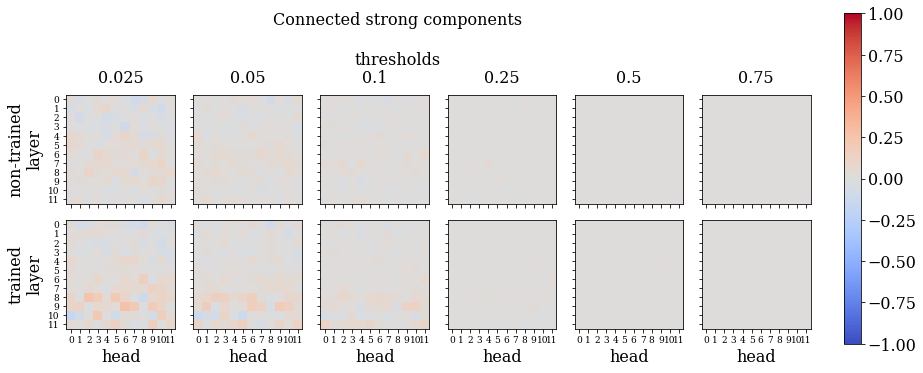

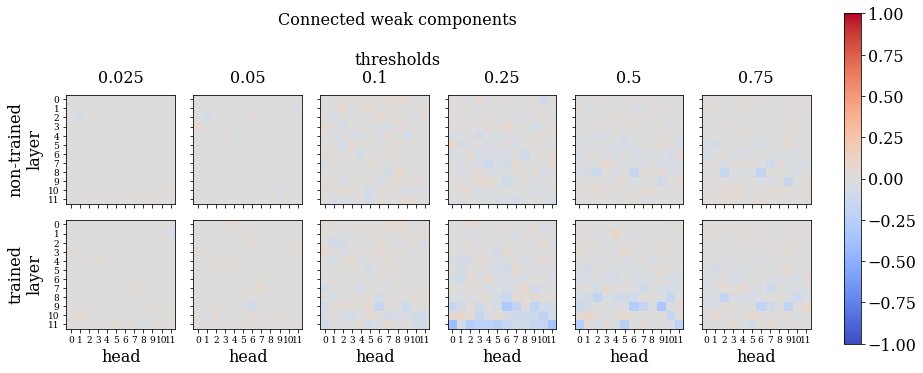

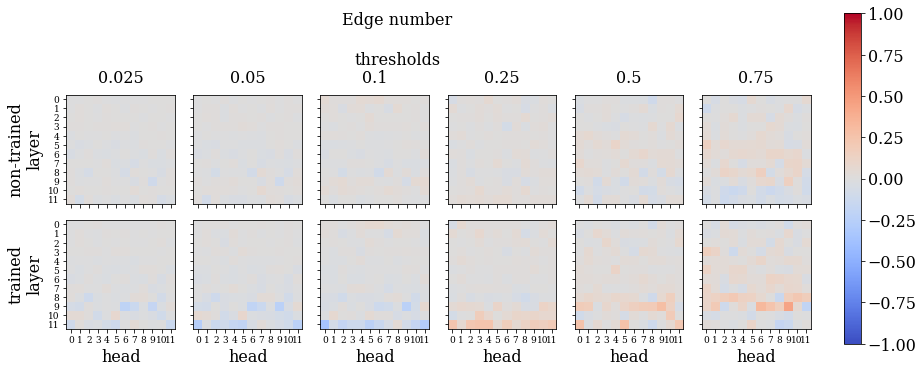

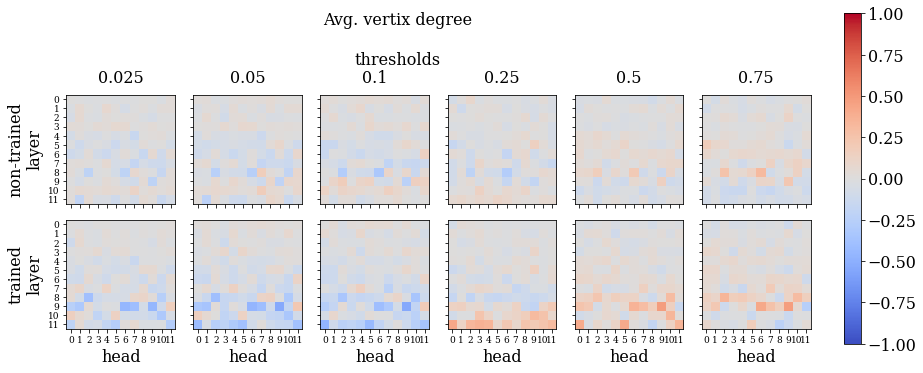

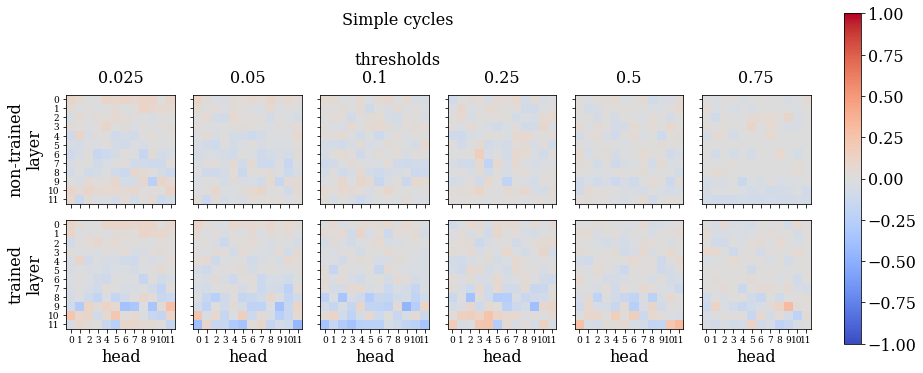

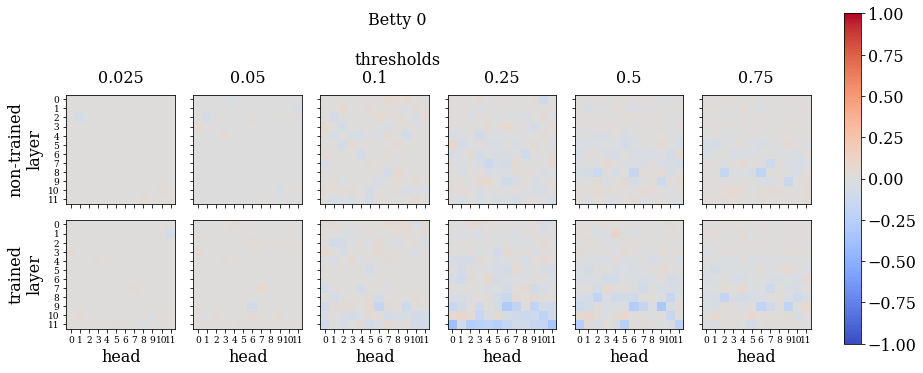

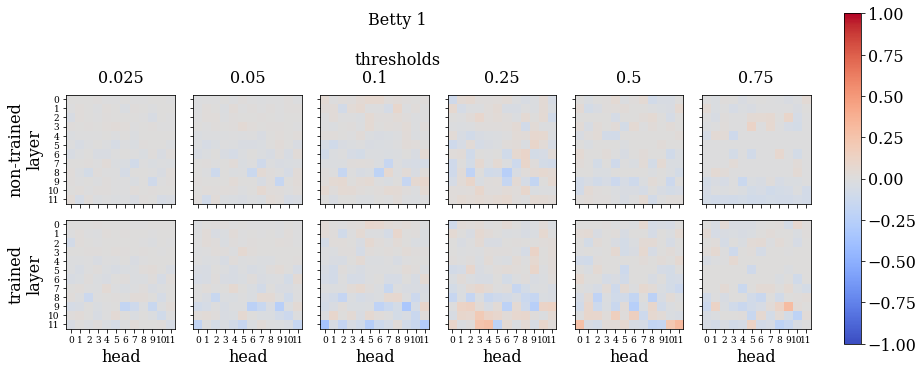

In [17]:
pdf = PdfPages(f"{output_dir}{subset}_corr_tr_nt.pdf")    
plt.rcParams["font.family"] = "serif"
for f in topological_names:
    data = make_comparison_data(matrices_tr, matrices_nt, f, names = topological_names, topological = topological_thresholds)
    draw_heatmaps_trained_nontrained(data,thresholds = topological_thresholds, title=topological_titles[f], 
                                     pdf_file=pdf)
pdf.close()

## Barcodes correlation

In [18]:
matrices_tr = get_matrices(barcode_features_tr, barcode_get_layer_head, y, names=barcode_feature_names)
print()
matrices_nt = get_matrices(barcode_features_nt, barcode_get_layer_head, y, names=barcode_feature_names)
dict_init('barcode','corr', matrices, [matrices_tr, matrices_nt])

h0_n_d_l_t0.25: 0.4124235950592394  9 9
h0_t_d: -0.4046516039901816  9 9
h0_n_d_m_t0.75: -0.394611389056421  11 0
h1_t_b: -0.3815977258755303  8 2
h1_v: -0.3675280672377333  8 2
h1_e: -0.3210871859179958  8 2
h0_n_d_m_t0.5: -0.3150419951902397  9 9
h1_n_b_l_t0.95: -0.3119069091198329  8 2
h1_nb: -0.3001150636864008  9 9
h1_n_b_m_t0.25: -0.3001150636864008  9 9
h1_s: -0.29342640414420246  8 2
h1_n_b_l_t0.70: -0.23979477914142228  8 2
h0_s: -0.23032652089249028  9 6
h0_e: -0.12309399034854394  9 6

h0_t_d: -0.277449093144166  8 6
h1_t_b: -0.1996186998634642  6 6
h1_s: -0.18777717919423062  8 6
h1_n_b_l_t0.95: -0.1728208619557509  8 6
h1_nb: -0.16599408215414402  8 6
h1_n_b_m_t0.25: -0.16599408215414402  8 6
h1_n_b_l_t0.70: -0.16034981363162498  8 6
h0_n_d_l_t0.25: 0.1507611884292691  8 6
h0_n_d_m_t0.5: -0.15050455382427175  8 6
h1_v: -0.14020728776649205  11 4
h1_e: -0.13315921659956476  8 6
h0_s: -0.11373191749874507  8 2
h0_n_d_m_t0.75: -0.11344832446457997  7 4
h0_e: 0.064116834976857

C:\Users\Irina\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Irina\anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


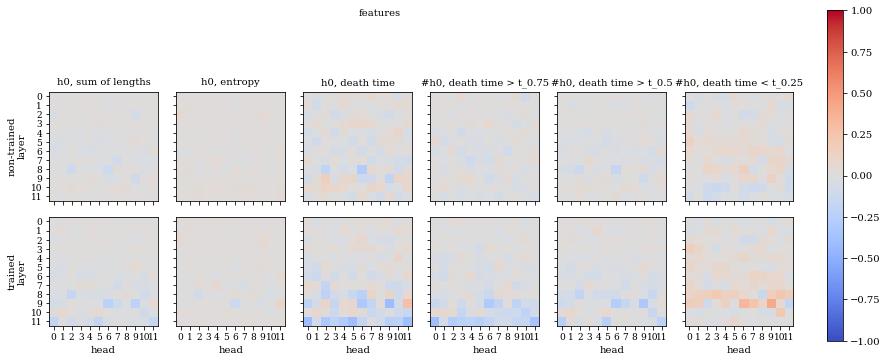

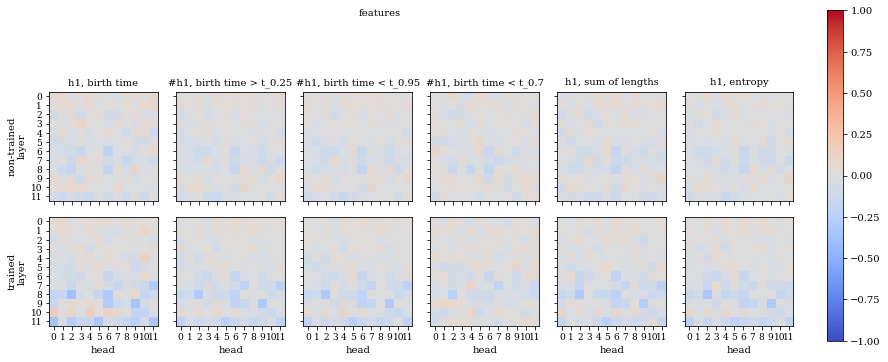

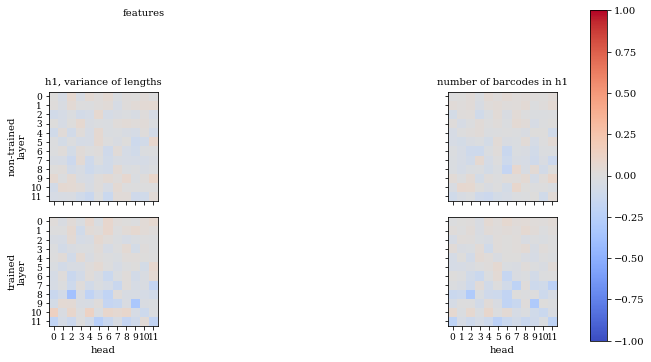

In [19]:
start = 0
pdf = PdfPages(f"{output_dir}{subset}_barcodes_tr_nt.pdf")
for _ in range(ceil(len(barcode_feature_names)/6)):
    names_i = [barcode_titles[i] for i in barcode_feature_names[start:start+6]]
    data = make_comparison_data(matrices_tr, matrices_nt, barcode_feature_names[start:start+6], names = barcode_feature_names[start:start+6])
    draw_heatmaps_trained_nontrained(data, thresholds=names_i, pdf_file=pdf,subtitles_font_size=10,
                                 subtitles_pad=7, topological = False) # pdf heatmaps are blurry
    start +=6
pdf.close()

## Template features' correlation

In [20]:
matrices_tr = get_matrices(template_features_tr, template_get_layer_head, y, names=template_feature_names)
print()
matrices_nt = get_matrices(template_features_nt, template_get_layer_head, y, names=template_feature_names)
dict_init('template','corr', matrices, [matrices_tr, matrices_nt])

beginning: 0.44553360959344185  11 0
dot: 0.3630539752433176  9 6
self: 0.3401484208789006  11 0
next: 0.3330117059471819  11 4
prev: 0.28964439809805653  11 0
comma: 0.1009840511921447  7 6

prev: 0.22185397863164394  7 7
dot: 0.1842041148541841  9 9
self: -0.1793622322447697  10 3
next: -0.17837837425912445  7 11
beginning: -0.16448569268399493  9 11
comma: 0.09683822682086089  8 1


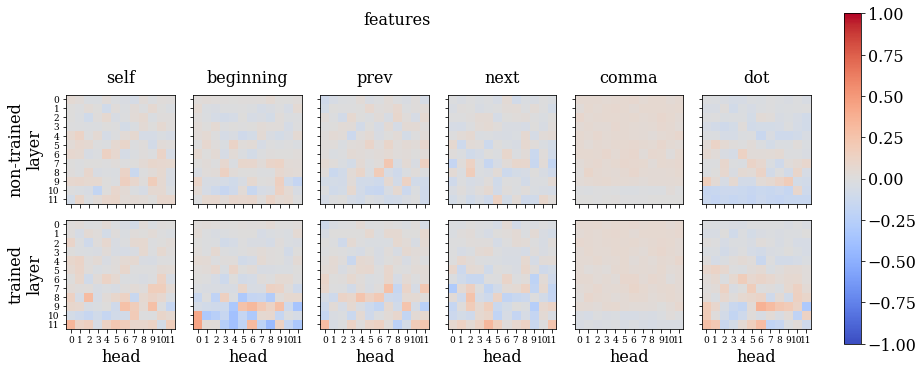

In [21]:
start = 0
pdf = PdfPages(f"{output_dir}{subset}_templates_tr_nt.pdf")
for _ in range(ceil(len(template_feature_names)/6)):
    data = make_comparison_data(matrices_tr, matrices_nt, template_feature_names[start:start+6], names = template_feature_names[start:start+6])
    draw_heatmaps_trained_nontrained(data, thresholds=template_feature_names, pdf_file=pdf, topological = False) # pdf heatmaps are blurry
    start +=6
pdf.close()

# Mann-Whitney p-values calculation

## Topological features

In [22]:
matrices_tr = get_matrices(topological_features_tr, topological_get_layer_head, y, names=topological_feature_names, type_ = stat)
print()
matrices_nt = get_matrices(topological_features_nt, topological_get_layer_head, y, names=topological_feature_names, type_ = stat)
dict_init('topological','stat', matrices,[matrices_tr, matrices_nt])

v_t0.05: 6.25693120331137e-33  9 9
v_t0.75: 3.774751281003584e-30  9 9
v_t0.1: 7.996697862418315e-30  9 9
e_t0.75: 1.0950942143910564e-27  9 9
v_t0.5: 2.2797683876248318e-26  9 9
v_t0.025: 1.0458525342533153e-25  9 9
c_t0.05: 1.8392846332796659e-25  9 9
w_t0.25: 6.219501037650368e-25  11 0
b0_t0.25: 6.219501037650368e-25  11 0
c_t0.1: 1.532293414024699e-24  8 2
c_t0.025: 2.598101247456581e-23  9 6
b1_t0.1: 1.7258190966355655e-18  9 9
c_t0.25: 1.7431226490037465e-18  9 9
w_t0.5: 1.1295286583834846e-17  9 9
b0_t0.5: 1.1295286583834846e-17  9 9
e_t0.1: 1.4300648559214797e-17  11 0
v_t0.25: 1.8195914069113098e-16  11 0
e_t0.5: 7.358403156931926e-16  11 0
c_t0.5: 4.5900932850627195e-14  11 11
b1_t0.5: 4.5900932850627195e-14  11 11
b1_t0.25: 4.7121657625951564e-14  11 4
b1_t0.05: 5.662305584729429e-13  9 9
s_t0.025: 1.7951758059931225e-12  9 6
e_t0.05: 2.3453479396242195e-12  9 9
c_t0.75: 6.338791817944989e-12  9 9
b1_t0.75: 6.338791817944989e-12  9 9
e_t0.025: 2.1216493884504336e-11  9 6
w_

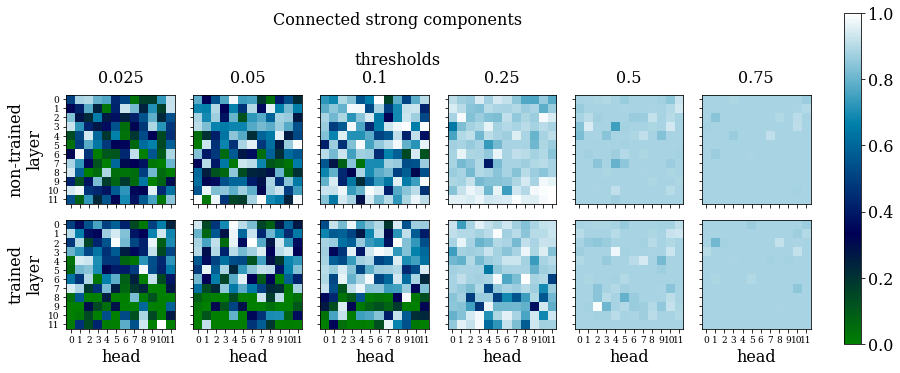

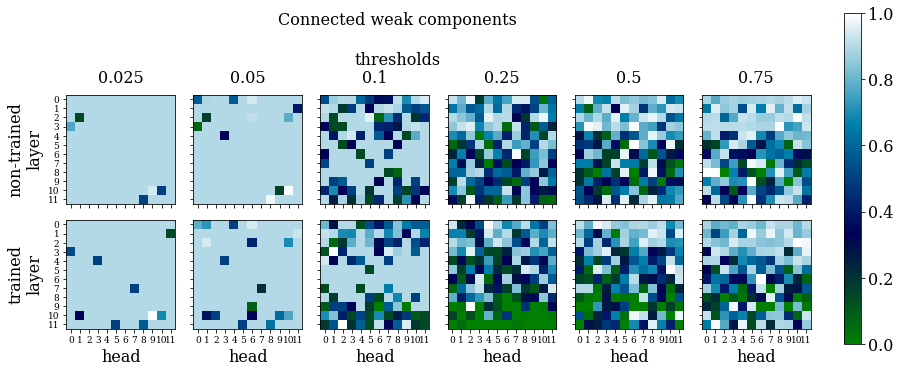

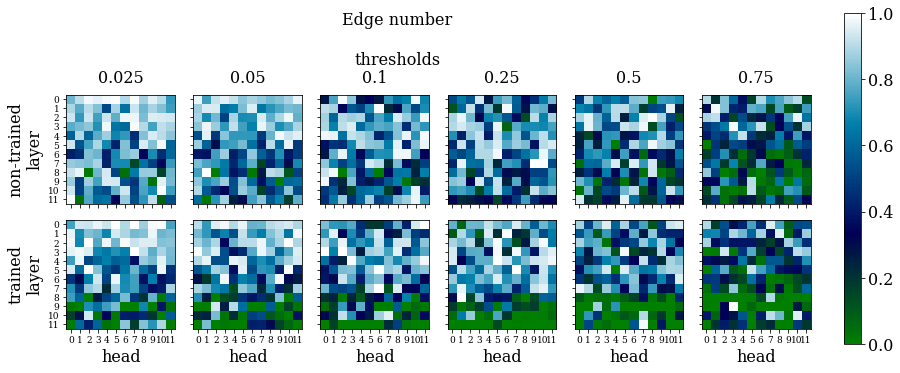

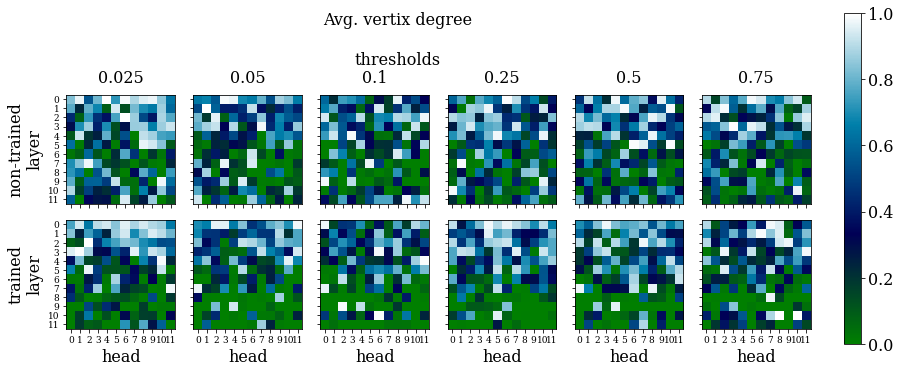

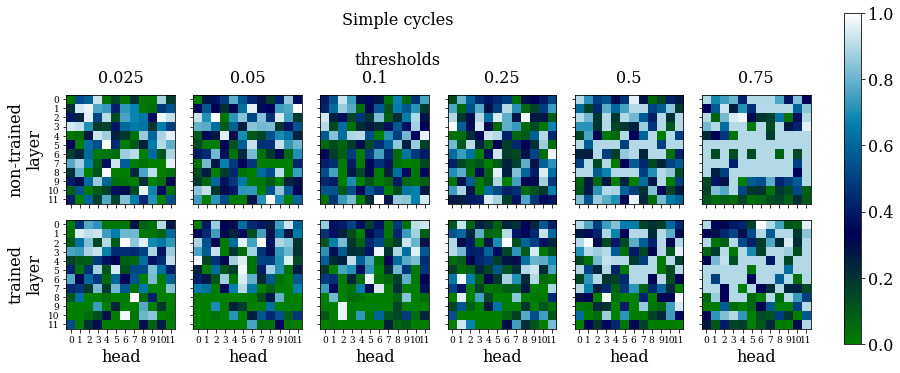

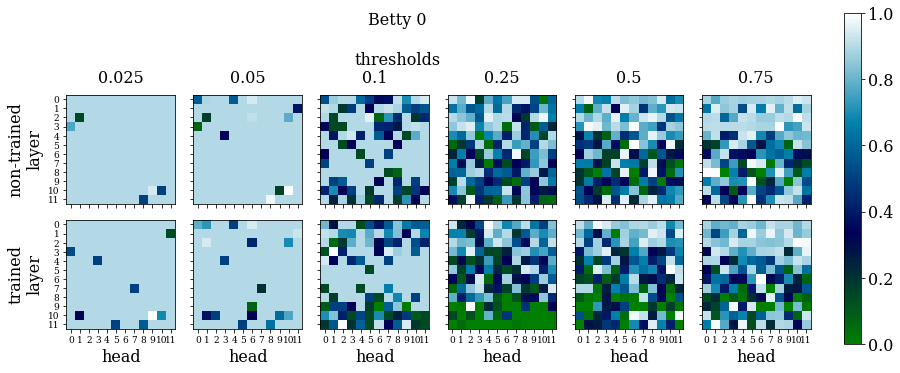

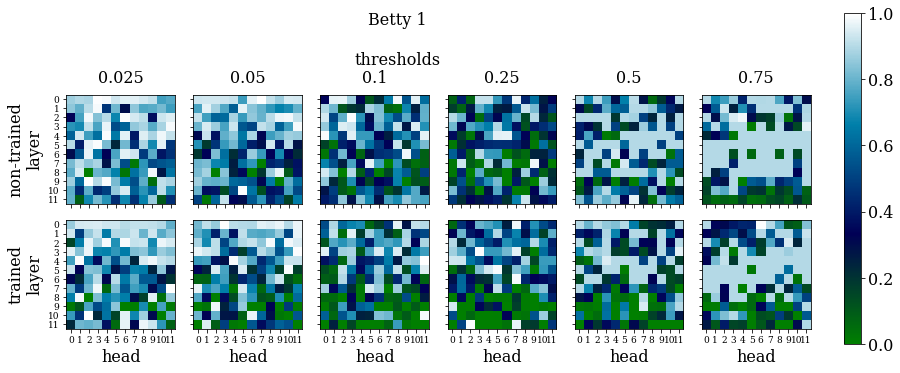

In [23]:
pdf = PdfPages(f"{output_dir}{subset}_p_values_top_tr_nt.pdf")
for f in topological_names:
    data = make_comparison_data(matrices_tr, matrices_nt, f, names = topological_names, topological = topological_thresholds)
    draw_heatmaps_trained_nontrained(data,thresholds = topological_thresholds, color_scheme = 'ocean', title=topological_titles[f], pdf_file=pdf
                                     , vmin = 0, vmax = 1)
pdf.close()

## Barcodes features

In [24]:
matrices_tr = get_matrices(barcode_features_tr, barcode_get_layer_head, y, names=barcode_feature_names, type_ = stat)
print()
matrices_nt = get_matrices(barcode_features_nt, barcode_get_layer_head, y, names=barcode_feature_names, type_ = stat)
dict_init('barcode','stat', matrices,[matrices_tr, matrices_nt])

h0_n_d_l_t0.25: 2.3448652727375735e-25  9 9
h0_n_d_m_t0.75: 6.219501037650368e-25  11 0
h1_n_b_l_t0.95: 1.9380883607168253e-23  8 2
h1_s: 5.395066407296943e-23  8 2
h1_n_b_m_t0.25: 4.264032886117537e-22  8 2
h1_nb: 4.264032886117537e-22  8 2
h0_t_d: 5.342327867217016e-22  11 11
h1_v: 1.7218361791540588e-19  8 2
h1_e: 2.9545787967253485e-18  8 2
h0_n_d_m_t0.5: 8.654436965341373e-18  9 9
h1_t_b: 2.916675995695563e-16  8 2
h0_s: 2.563507720035504e-13  9 6
h1_n_b_l_t0.70: 5.5927345300730865e-09  8 2
h0_e: 0.0011974995152428409  9 6

h0_t_d: 3.3410474371648407e-10  8 6
h0_n_d_m_t0.5: 3.475148158868325e-06  8 6
h1_s: 1.000789204382349e-05  6 6
h1_t_b: 1.3320368103685843e-05  6 6
h1_n_b_m_t0.25: 2.055887968650649e-05  6 6
h1_nb: 2.055887968650649e-05  6 6
h1_n_b_l_t0.95: 2.2655865206747158e-05  6 6
h0_s: 3.2309923230835306e-05  8 2
h1_n_b_l_t0.70: 5.866752981139985e-05  8 2
h0_n_d_l_t0.25: 0.00034061376041154555  8 6
h1_v: 0.00042575931959472514  11 4
h1_e: 0.001308675686147809  6 6
h0_n_d_m_

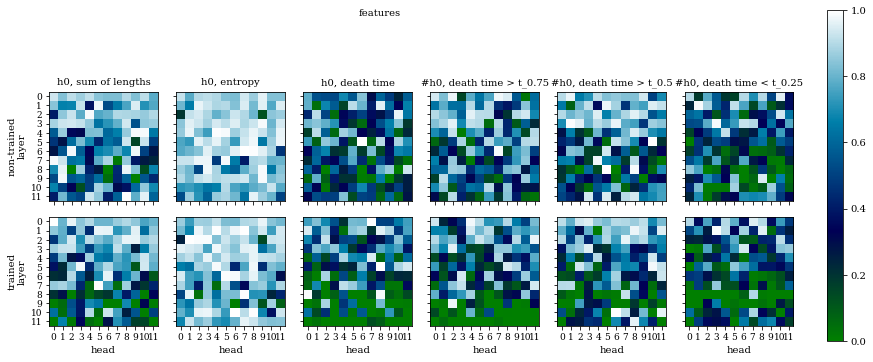

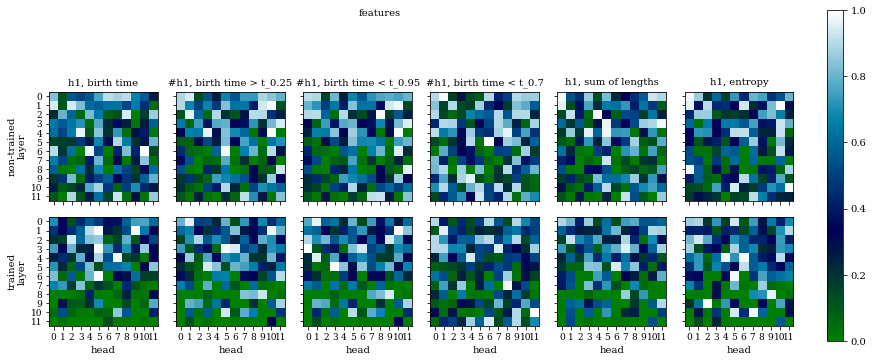

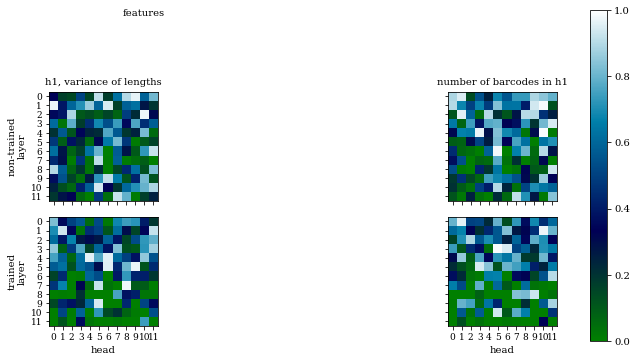

In [25]:
pdf = PdfPages(f"{output_dir}{subset}_p_values_barcodes_tr_nt.pdf")
start = 0
for _ in range(ceil(len(barcode_feature_names)/6)):
    names_i = [barcode_titles[i] for i in barcode_feature_names[start:start+6]]
    data = make_comparison_data(matrices_tr,matrices_nt, barcode_feature_names[start:start+6], 
                                     names = barcode_feature_names[start:start+6])
    draw_heatmaps_trained_nontrained(data, thresholds=names_i, pdf_file=pdf,subtitles_font_size=10,
                                subtitles_pad=7, topological = False, color_scheme = 'ocean', vmin = 0, vmax = 1) # pdf heatmaps are blurry
    start +=6
pdf.close()

## Template features

In [26]:
matrices_tr = get_matrices(template_features_tr, template_get_layer_head, y, names=template_feature_names, type_ = stat)
print()
matrices_nt = get_matrices(template_features_nt, template_get_layer_head, y, names=template_feature_names, type_ = stat)
dict_init('template','stat', matrices, [matrices_tr, matrices_nt])

beginning: 1.07381733936022e-23  11 8
next: 6.496700088331107e-18  11 4
self: 1.4313367779914473e-17  11 0
dot: 1.9659261068442237e-14  9 11
prev: 1.1269712831036777e-11  11 0
comma: 0.09171798417283526  8 5

self: 2.004511318052567e-06  9 9
next: 2.5660687589084613e-06  8 2
prev: 2.6106102993225445e-06  7 7
beginning: 9.108129573000806e-05  9 11
dot: 0.00014268926933670018  11 1
comma: 0.16966023684711196  4 4


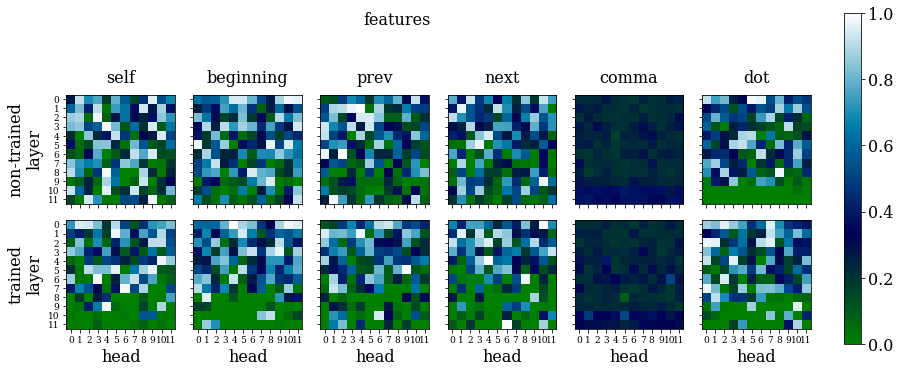

In [27]:
start = 0
pdf = PdfPages(f"{output_dir}{subset}_p_values_templates_tr_nt.pdf")
for _ in range(ceil(len(template_feature_names)/6)):
    data = make_comparison_data(matrices_tr, matrices_nt, template_feature_names[start:start+6], names = template_feature_names[start:start+6])
    draw_heatmaps_trained_nontrained(data, thresholds=template_feature_names, color_scheme = 'ocean', pdf_file=pdf, topological = False, vmin = 0, vmax = 1) # pdf heatmaps are blurry
    start +=6
pdf.close()    

# Distribution plots

<a id='Distribution'></a>

In [28]:
norm = colors.Normalize(vmin=-1, vmax=1)
colormap = cm.ScalarMappable(norm=norm, cmap=cm.BrBG)

In [29]:
params = []

## Topological features' distributions

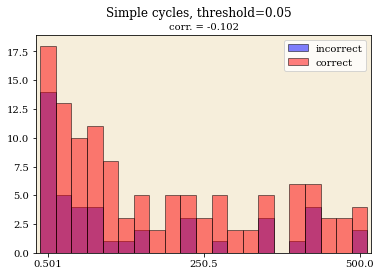

In [30]:
# ex top
cur_matrix = matrices['topological']['corr'][0]
f = 'c'
t = '0.05'
feat = f'{f}_t{t}'
layer =11
head = 10
fig, ax = plt.subplots()
fig.suptitle(f'{topological_titles[f]}, threshold={t}')
corr_coeff =cur_matrix[feat][layer,head]
plot_histogram(layer, head, feat,
        topological_features_tr, topological_get_layer_head,topological_feature_names, y,
        ax=ax, title='corr. = %0.3f' % (corr_coeff,),
        legend=True, 
        color=colormap.to_rgba(corr_coeff)
        )

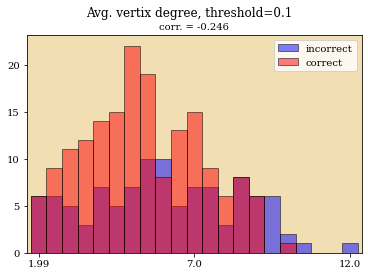

In [31]:
# v_t0.1_11_10	
# ex top
cur_matrix = matrices['topological']['corr'][0]
f = 'v'
t = '0.1'
feat = f'{f}_t{t}'
layer =11
head = 10
fig, ax = plt.subplots()
fig.suptitle(f'{topological_titles[f]}, threshold={t}')
corr_coeff =cur_matrix[feat][layer,head]
plot_histogram(layer, head, feat,
        topological_features_tr, topological_get_layer_head,topological_feature_names, y,
        ax=ax, title='corr. = %0.3f' % (corr_coeff,),
        legend=True, 
        color=colormap.to_rgba(corr_coeff)
        )

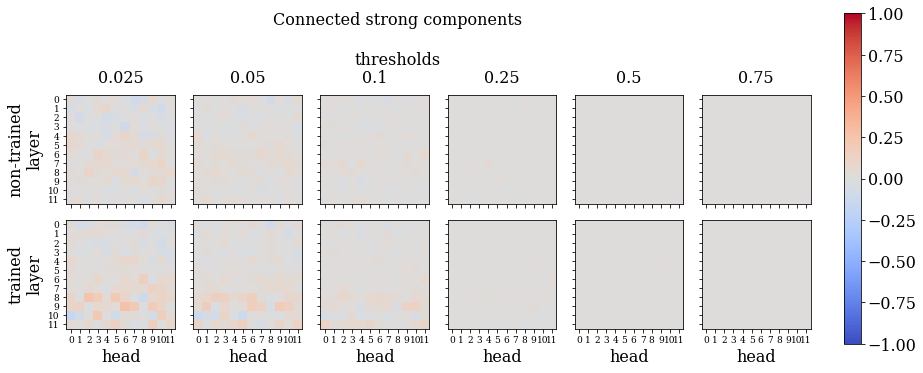

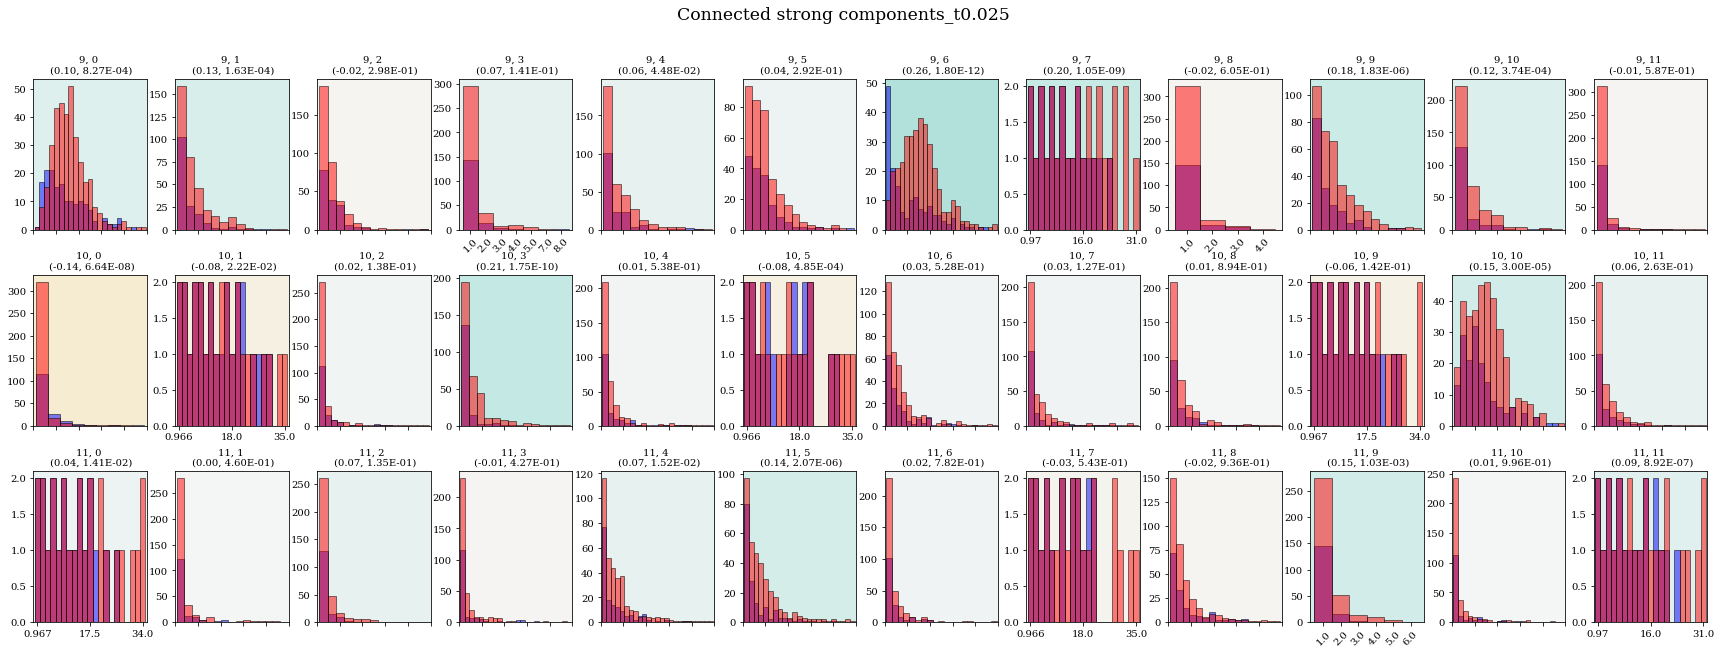

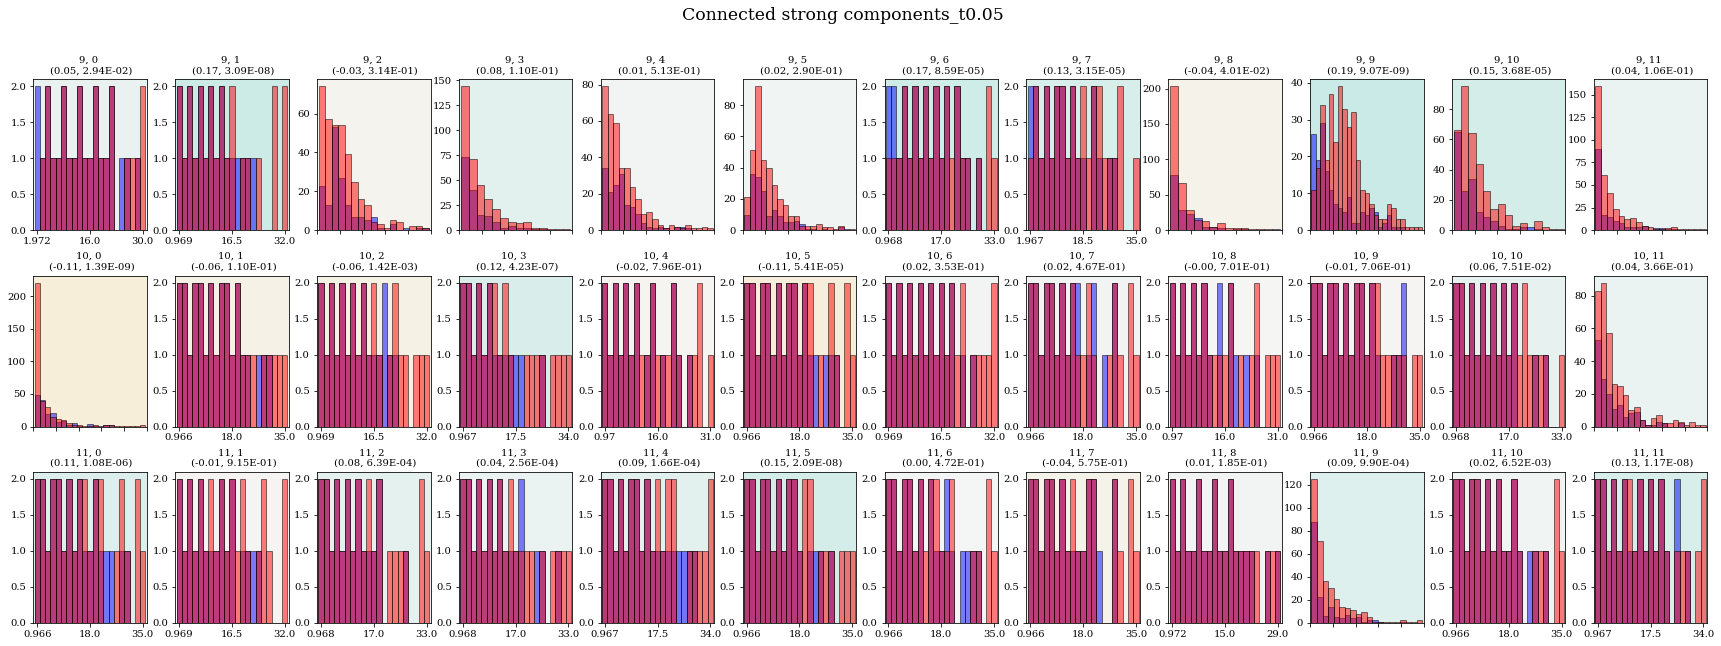

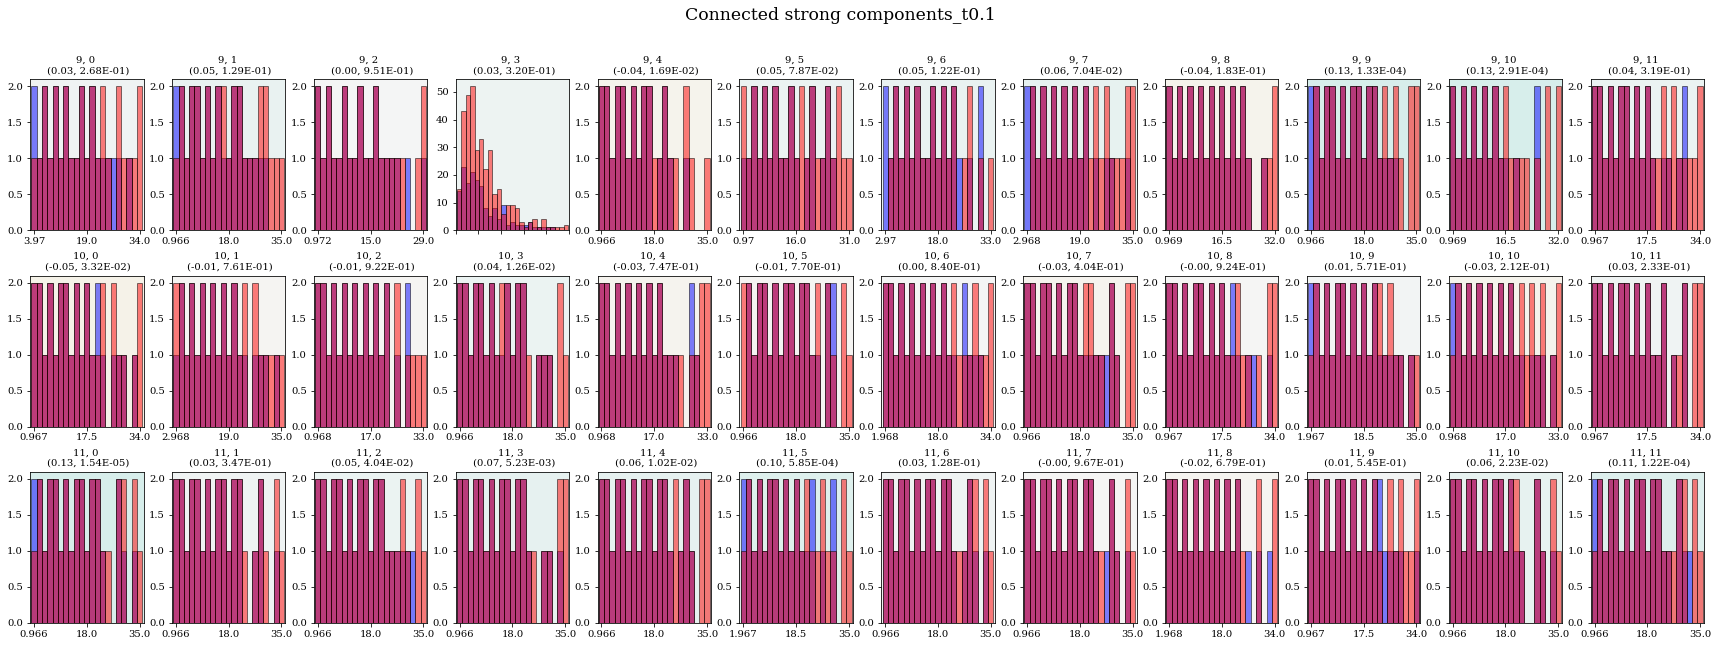

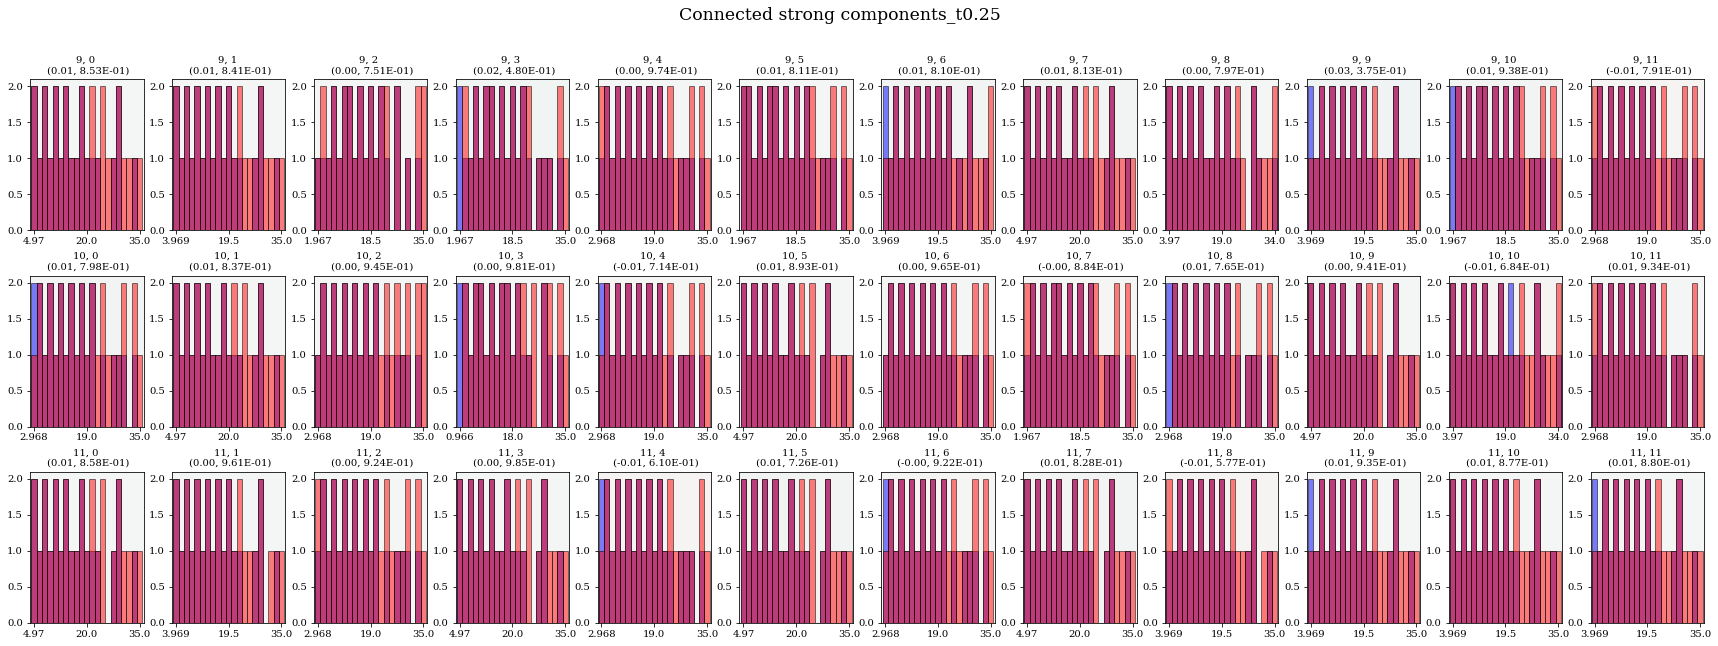

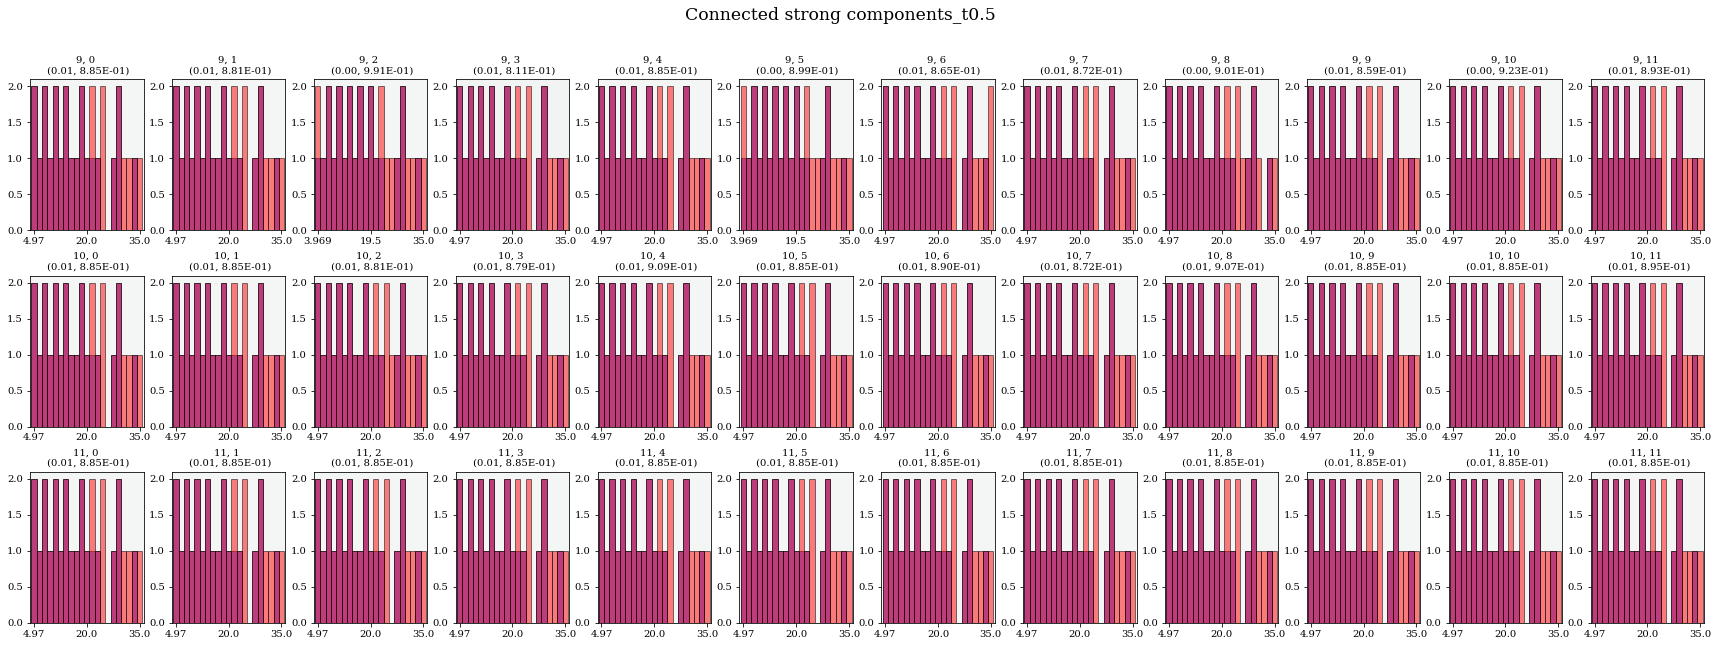

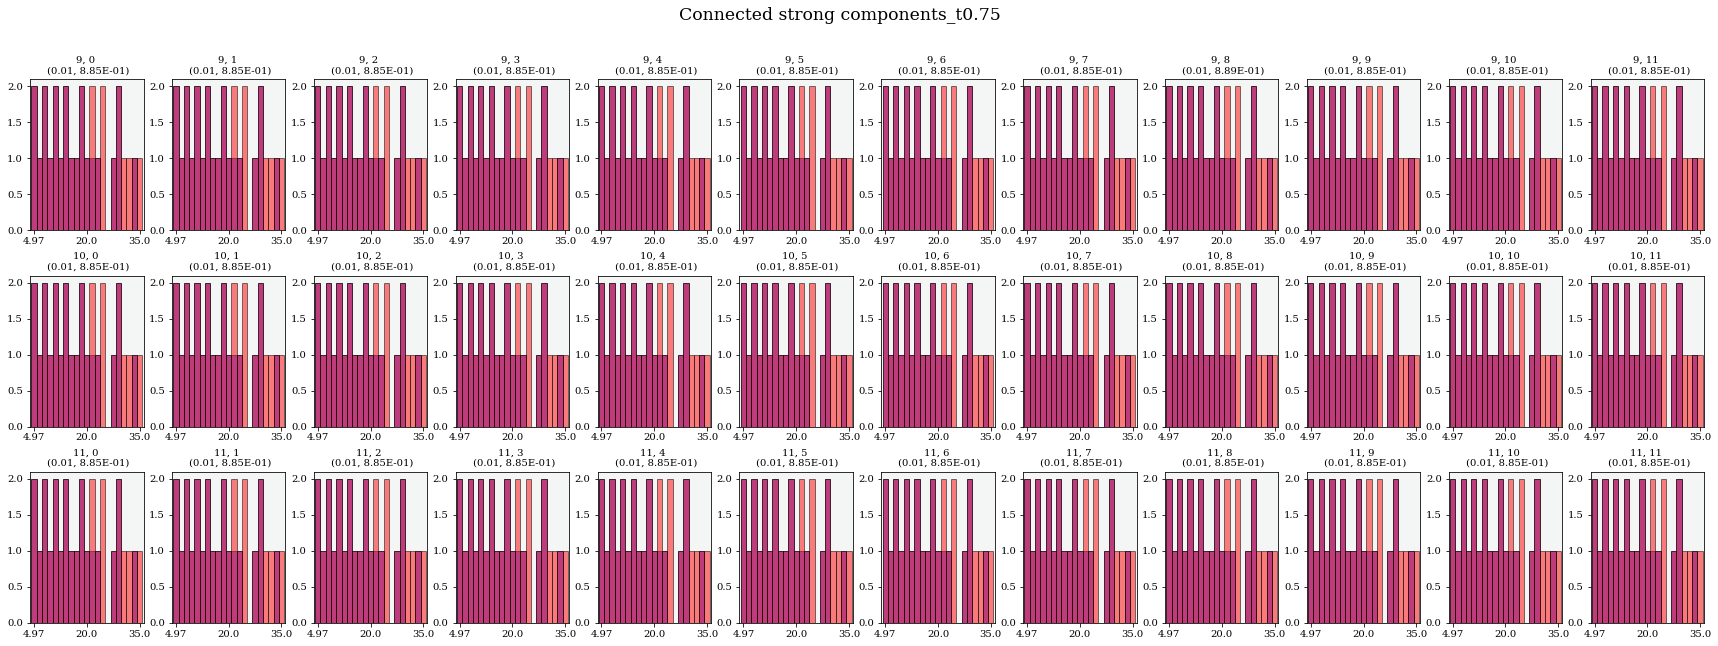

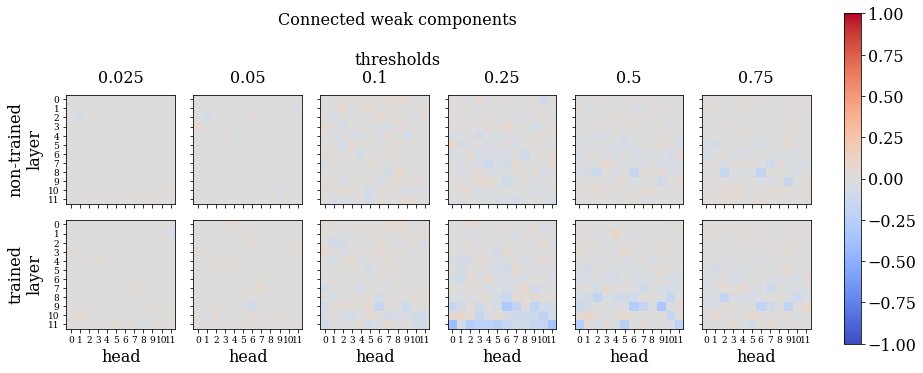

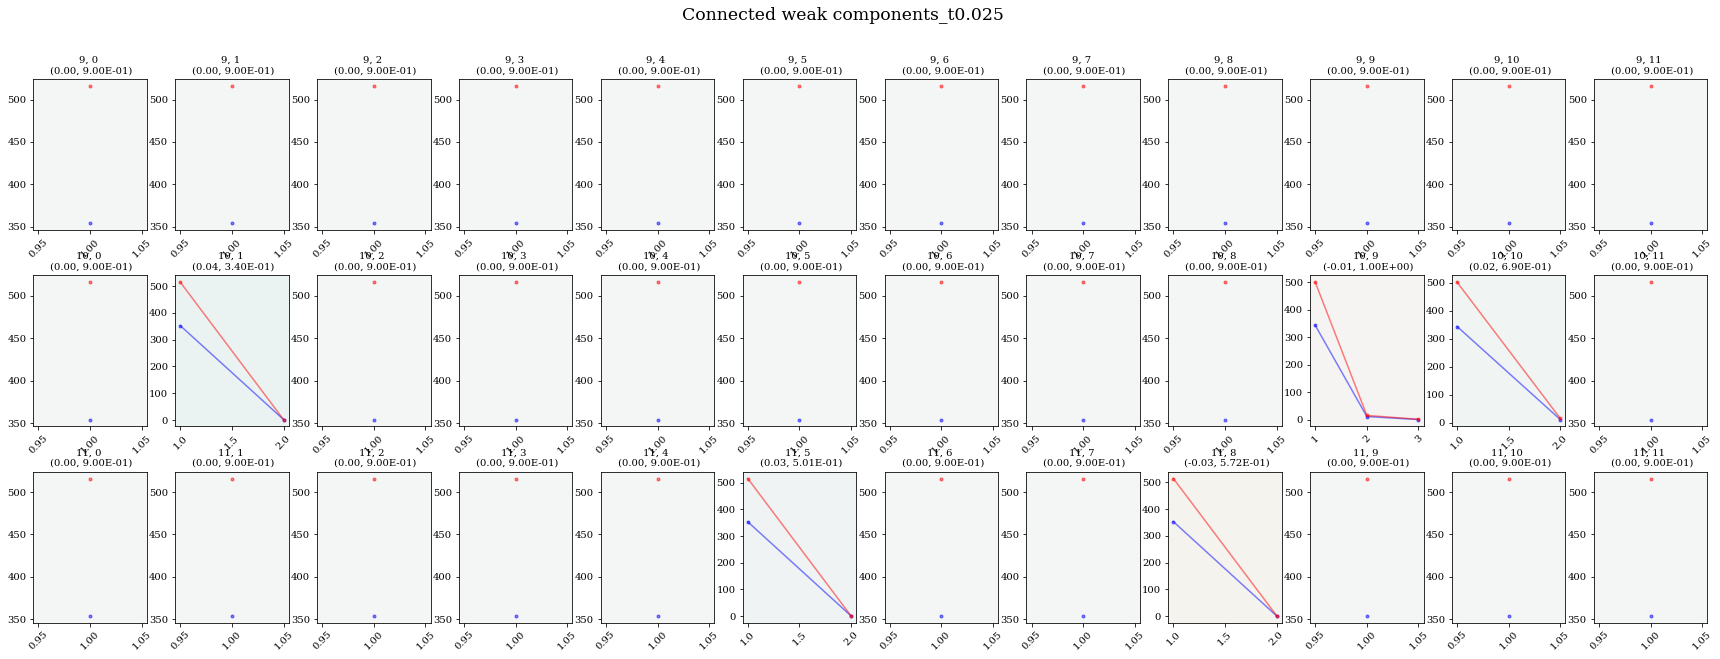

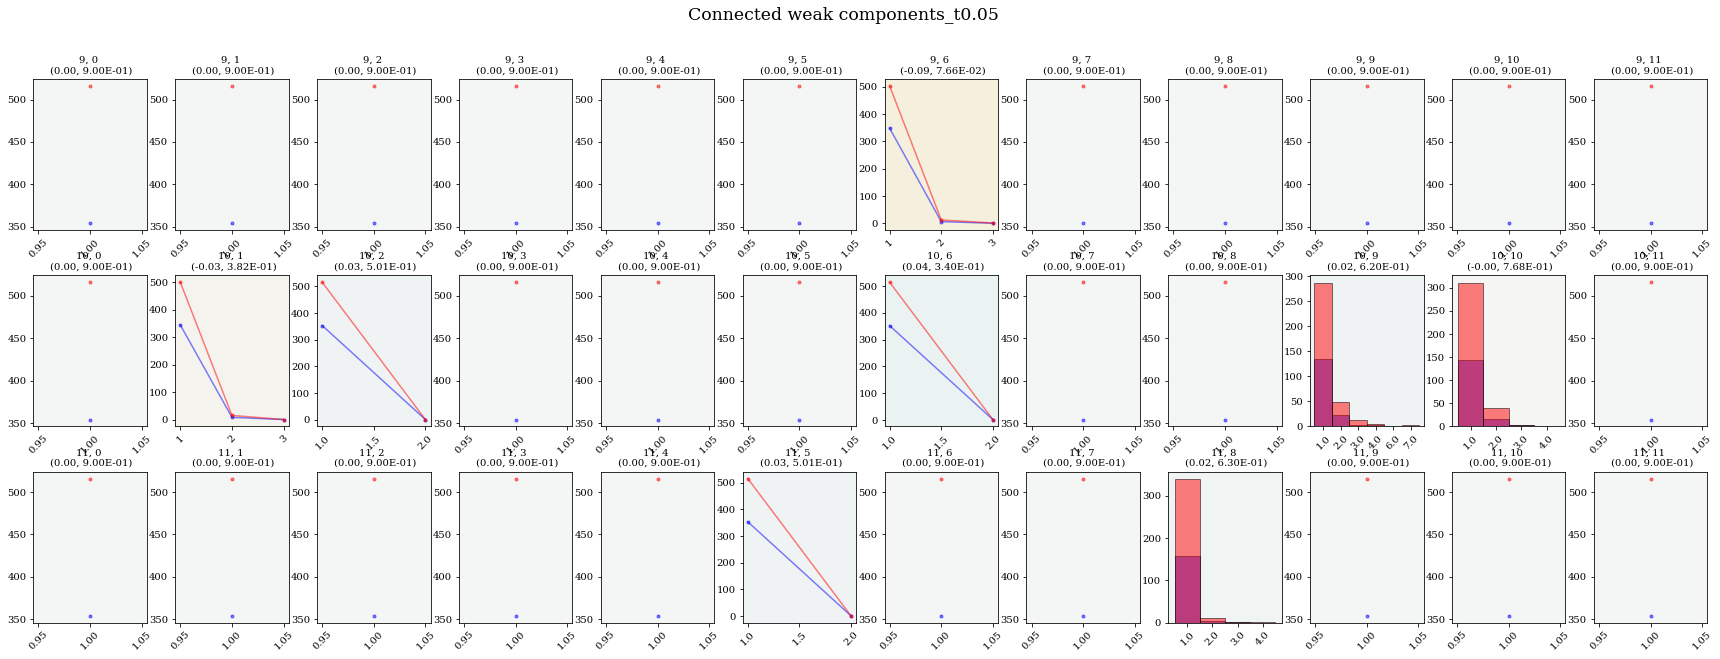

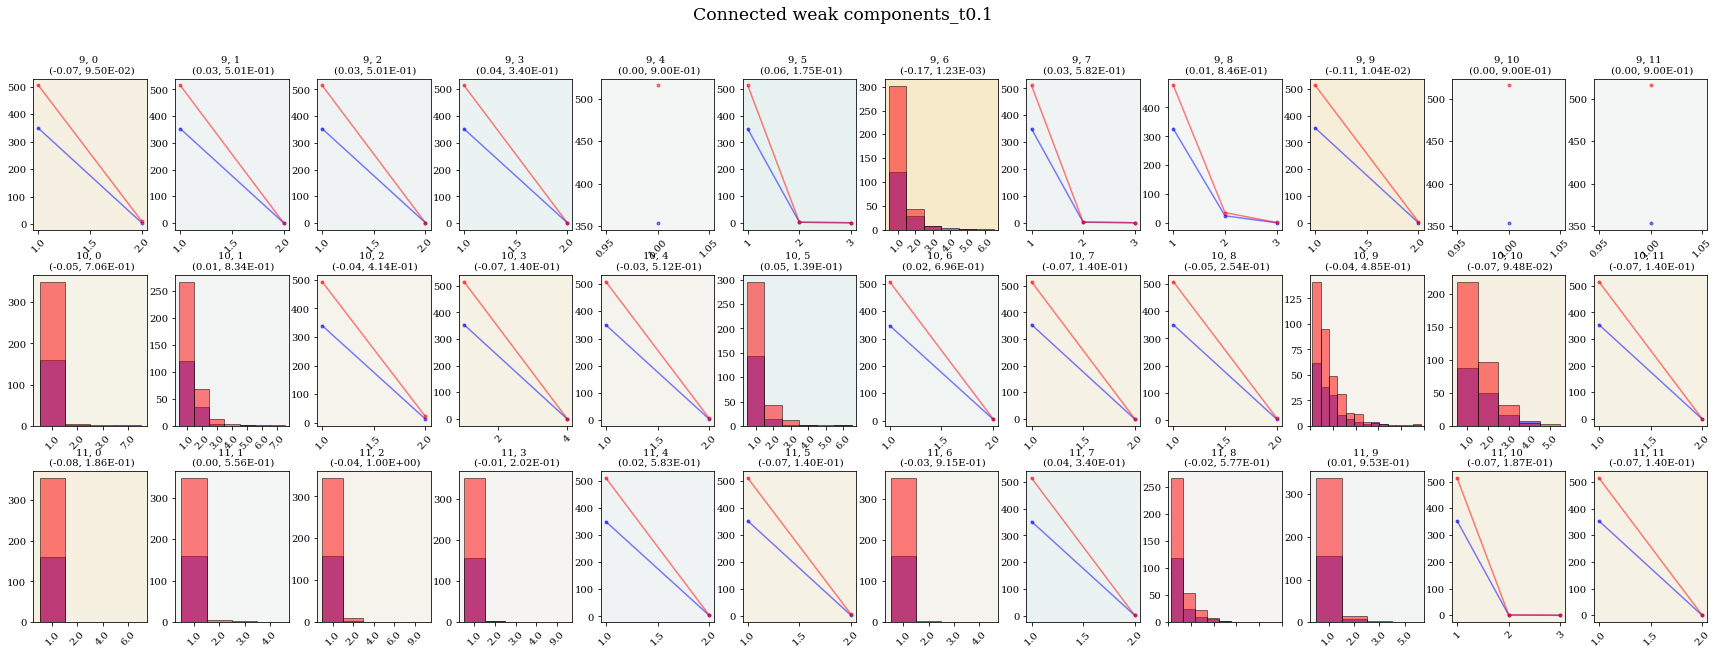

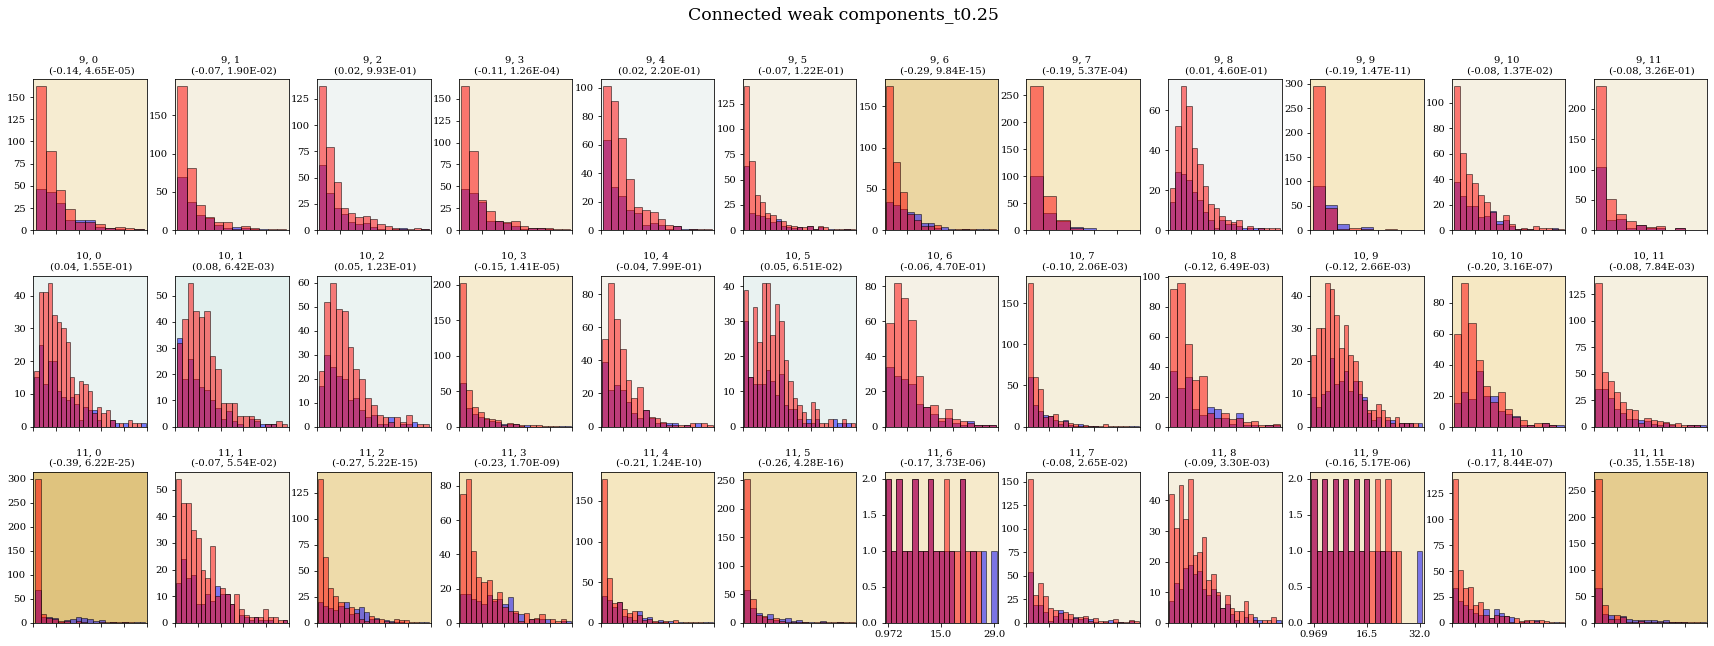

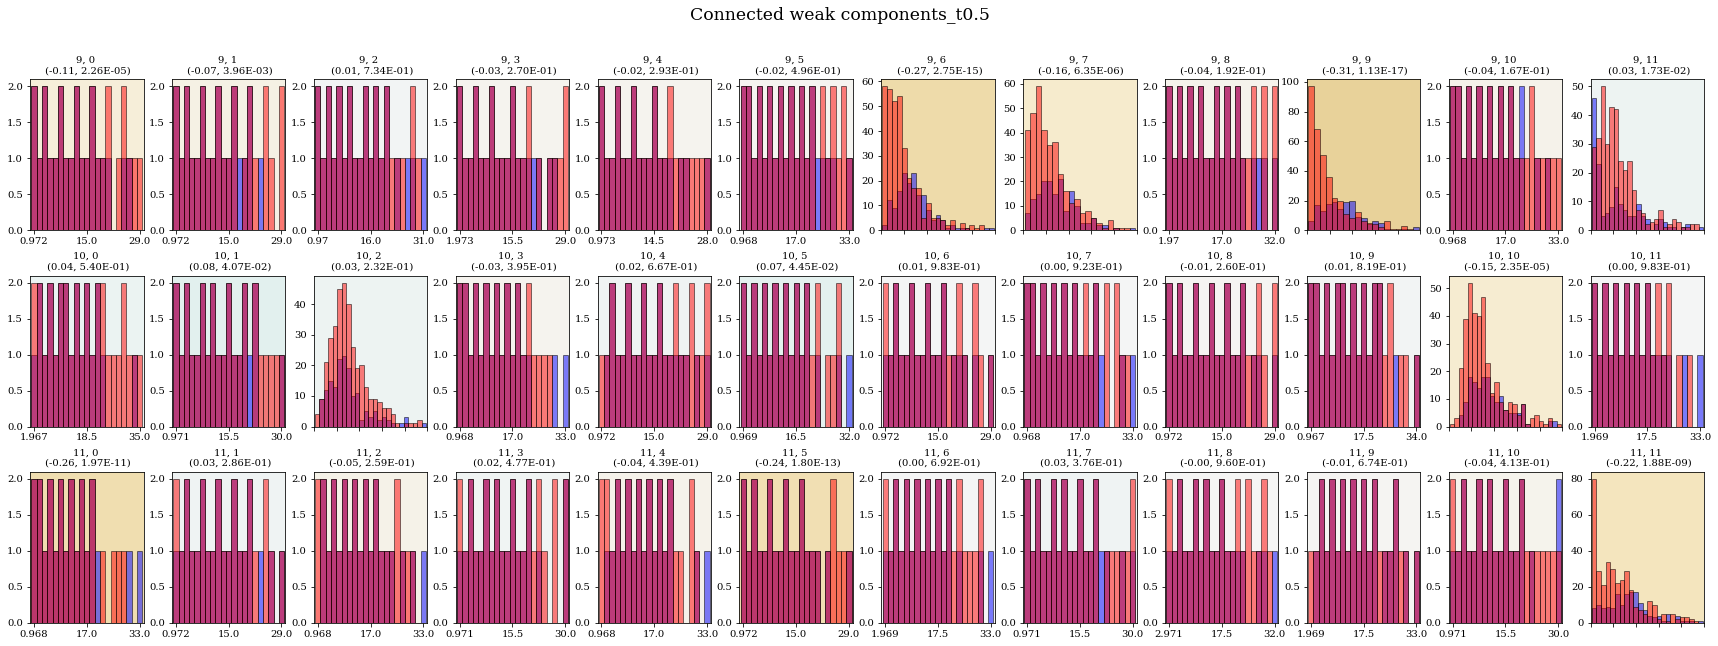

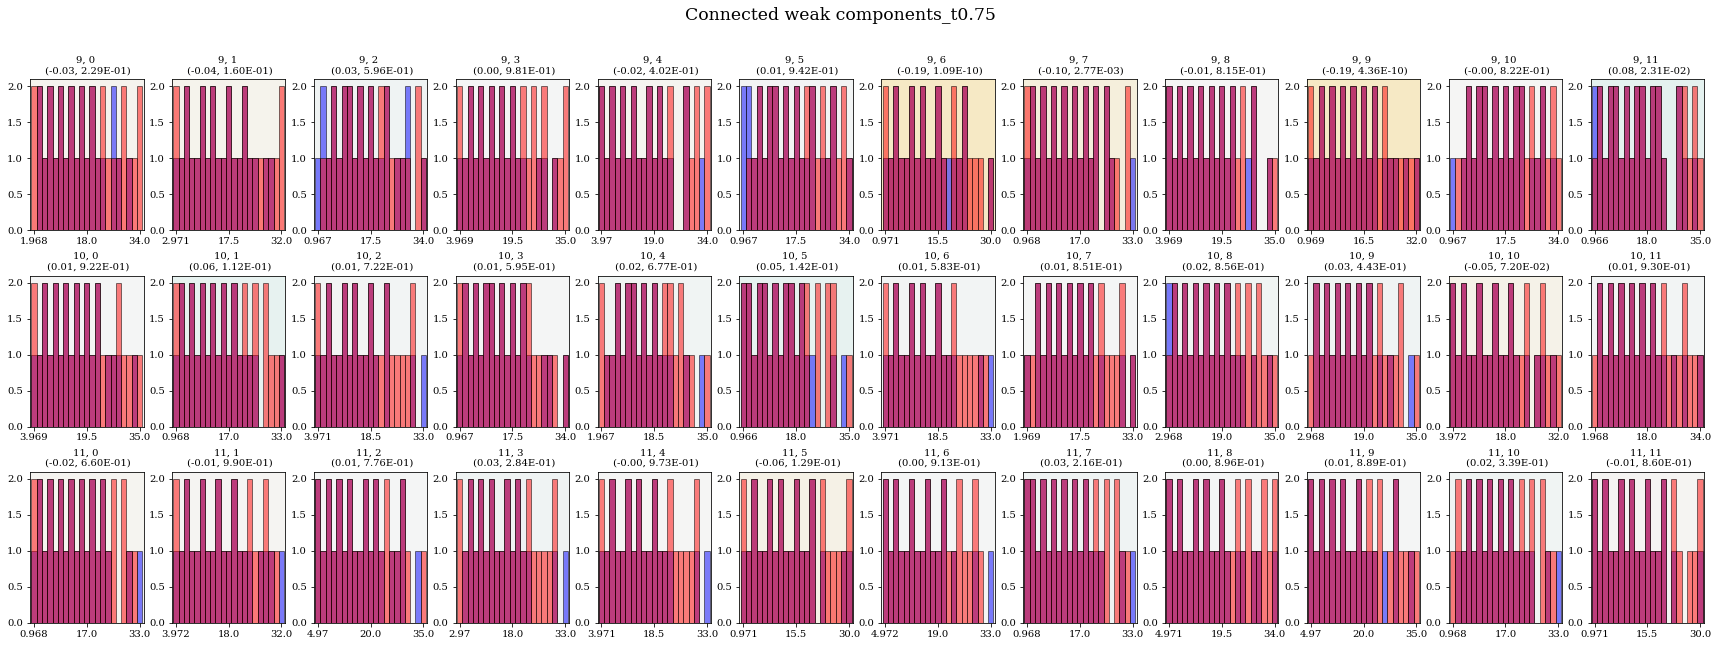

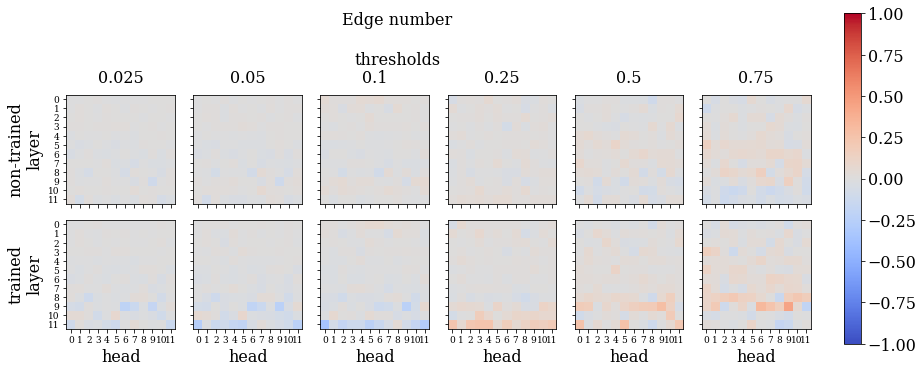

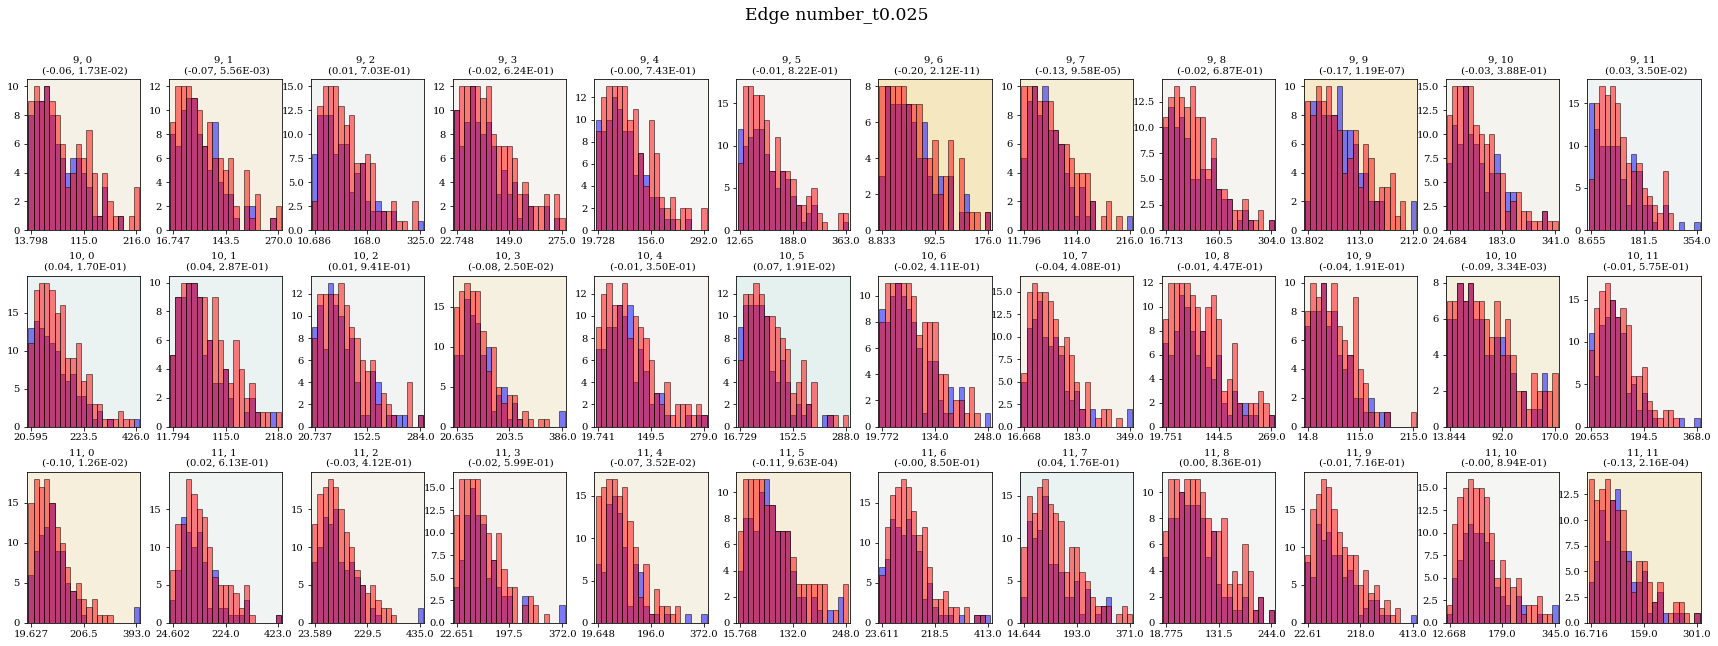

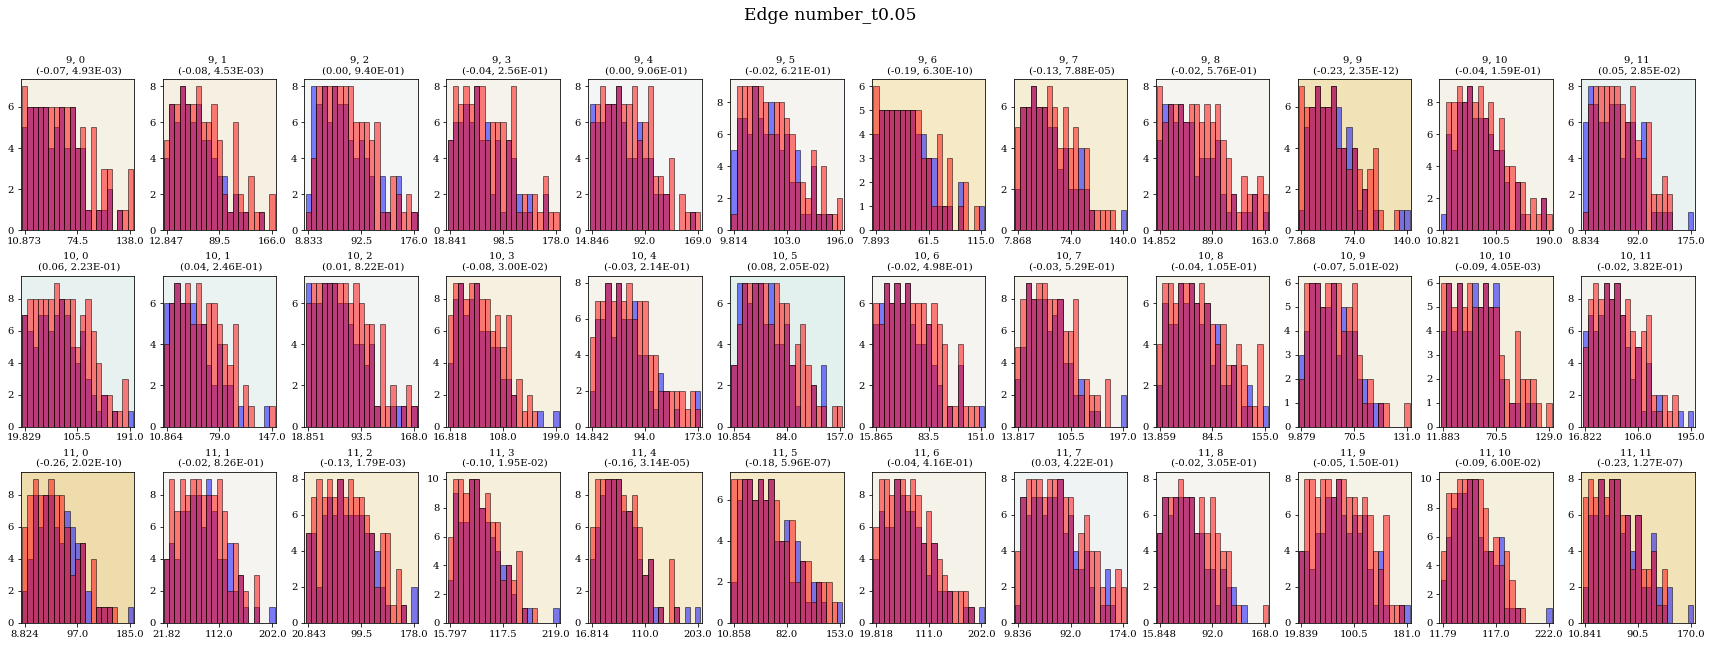

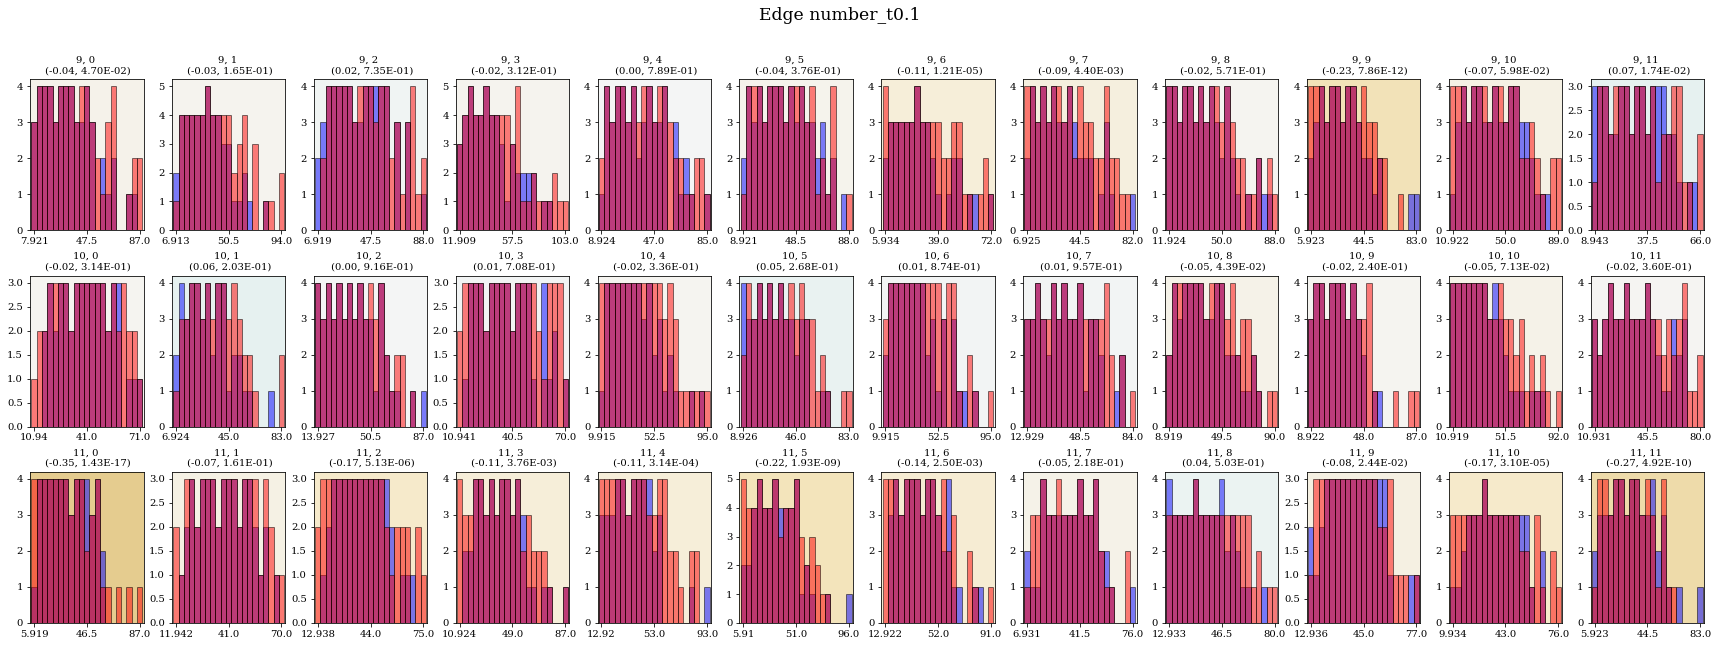

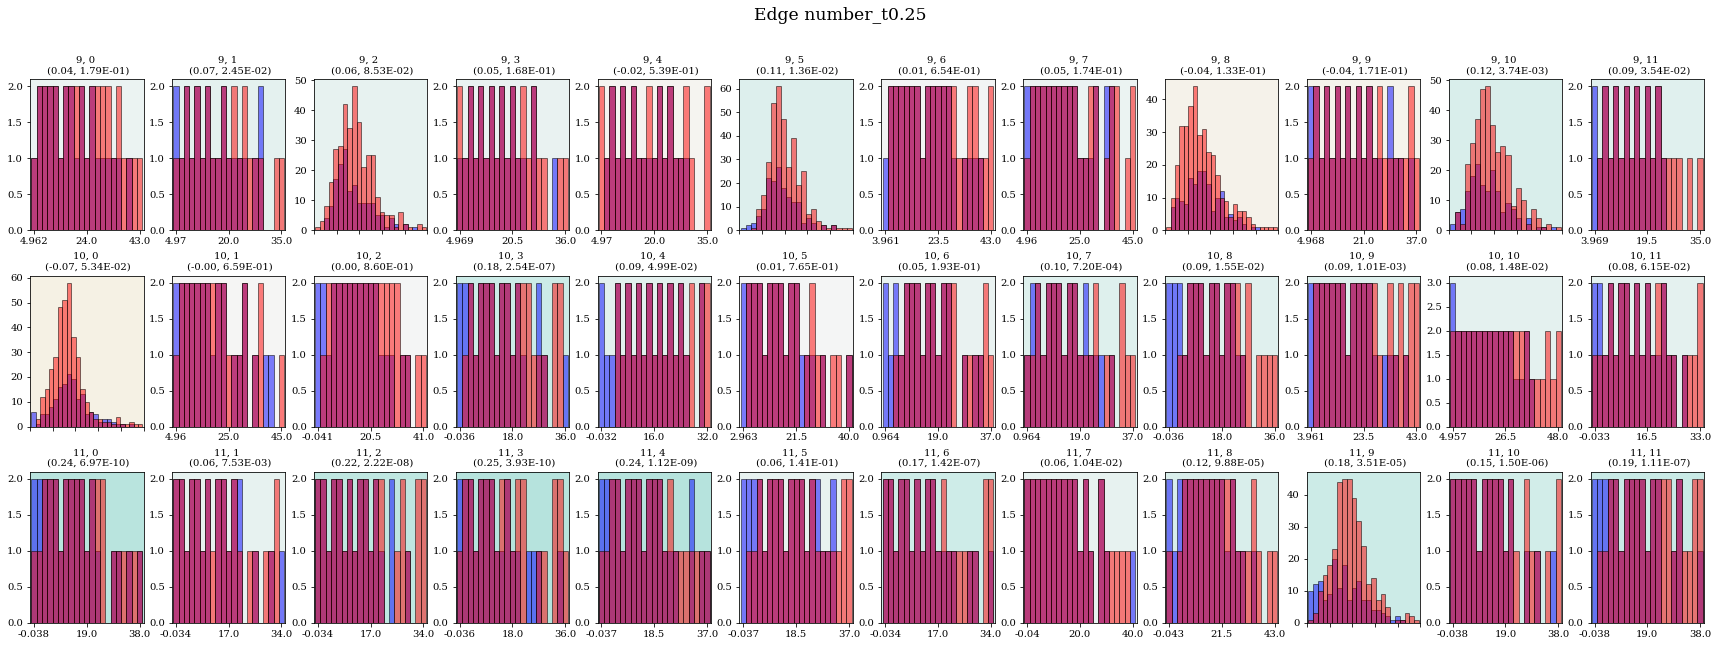

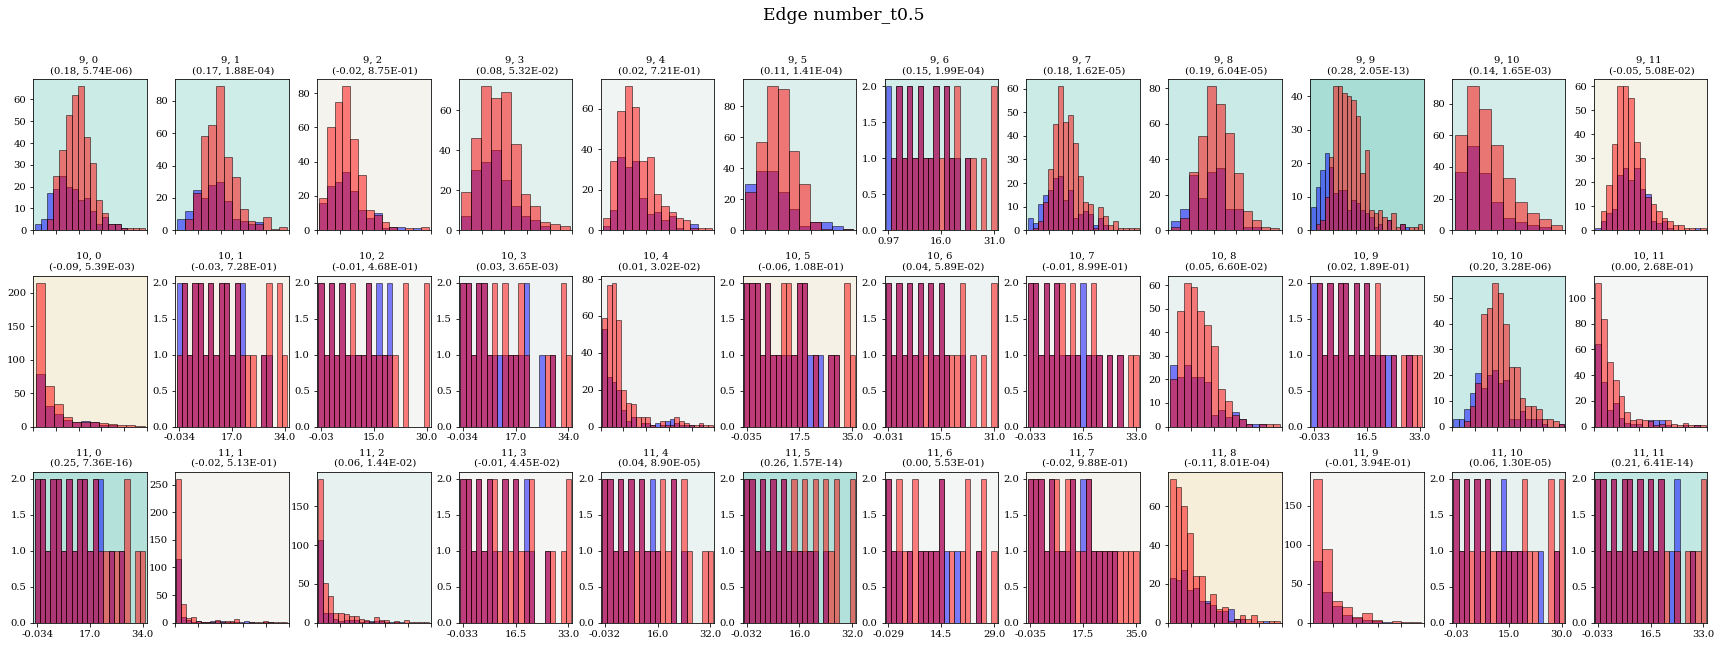

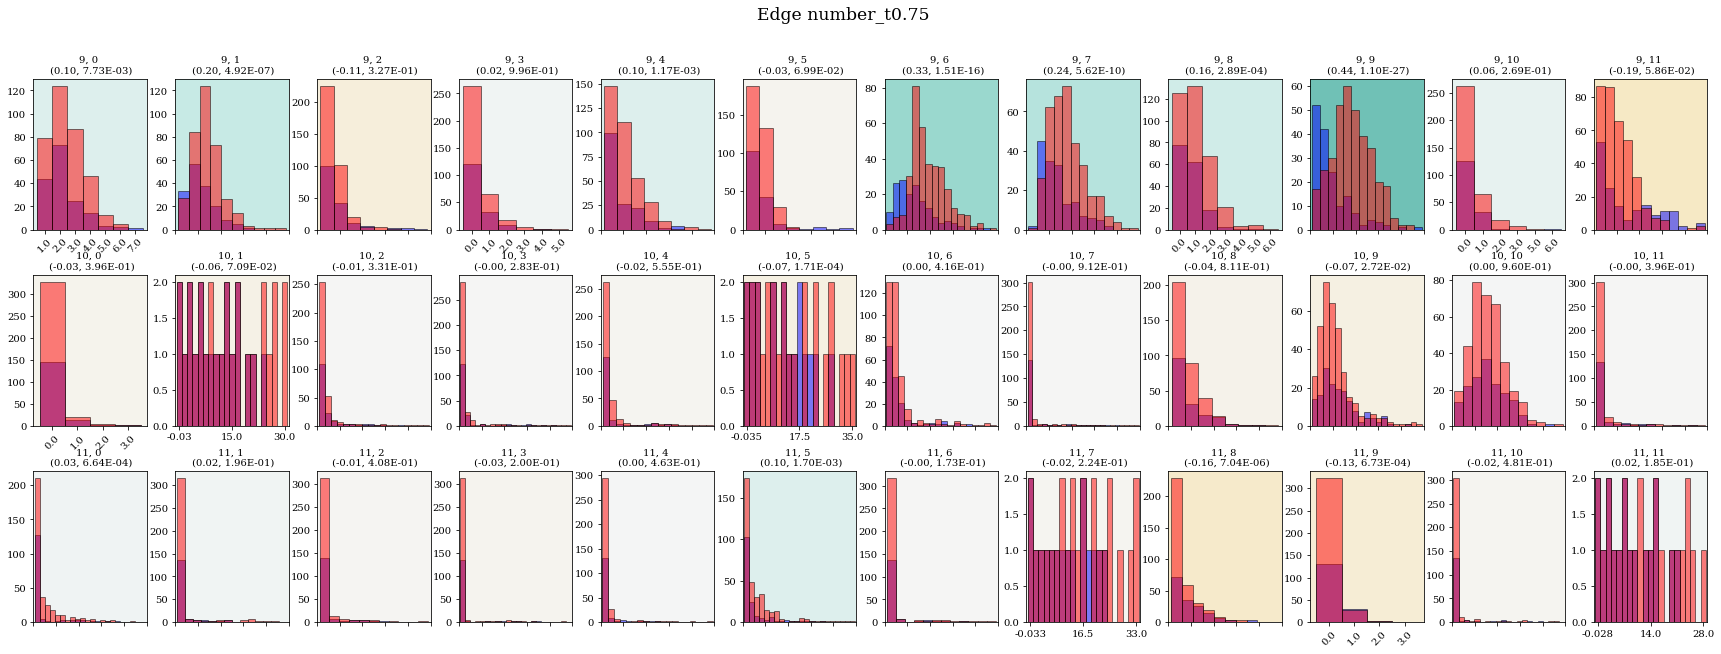

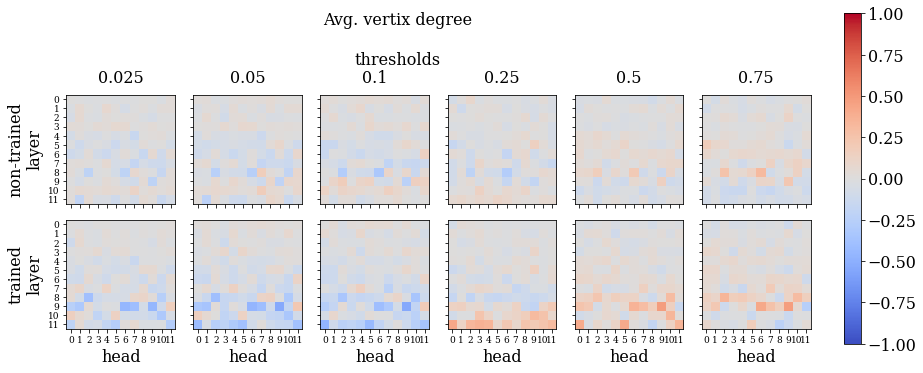

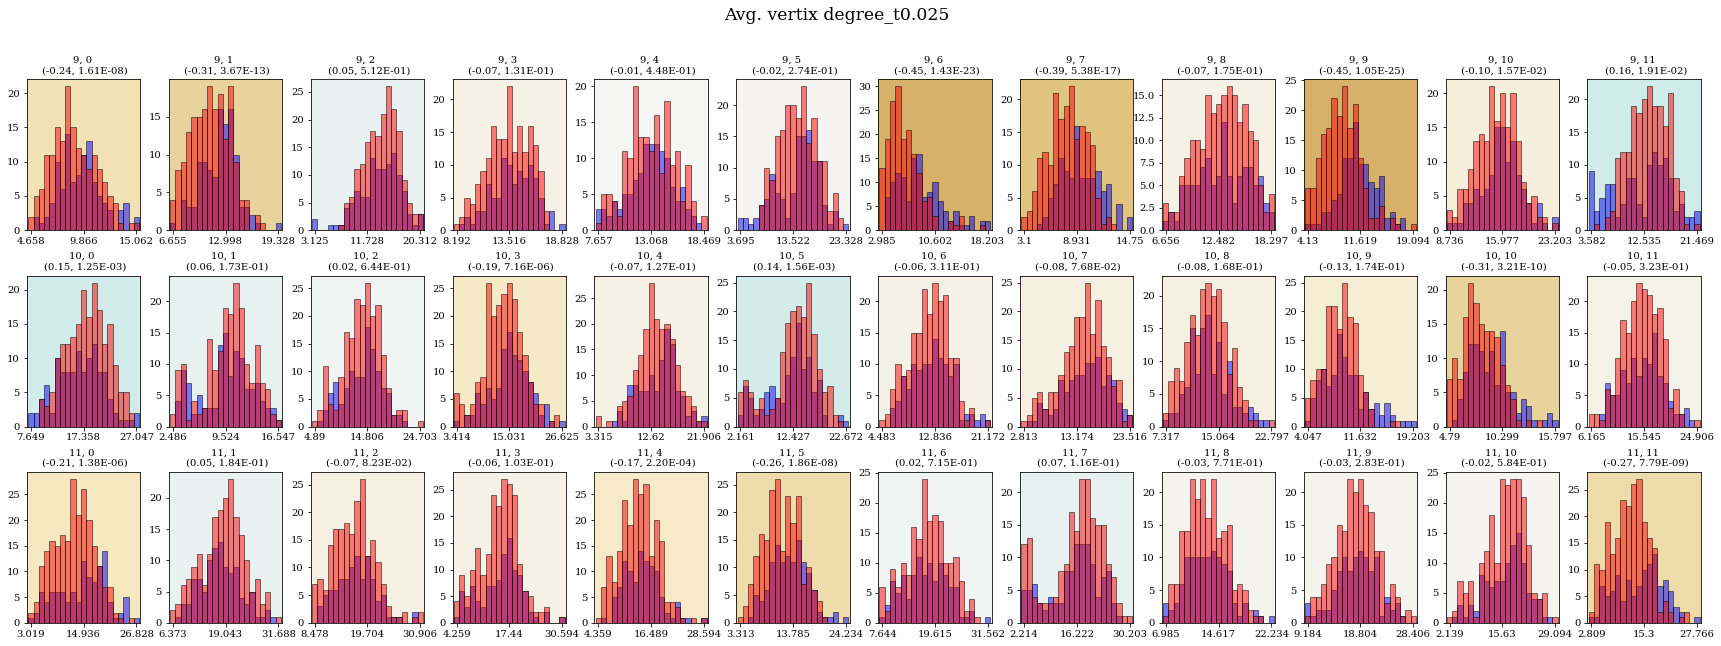

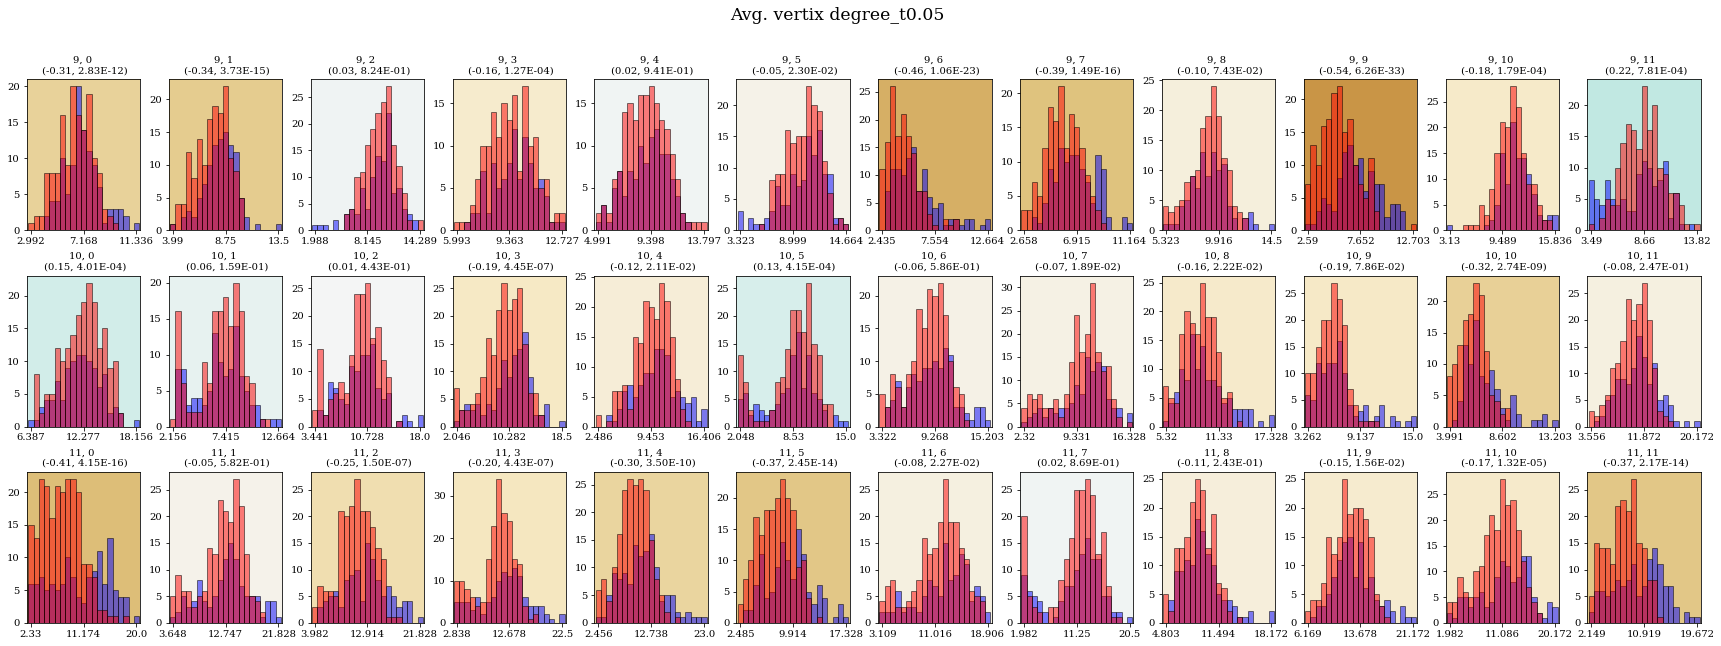

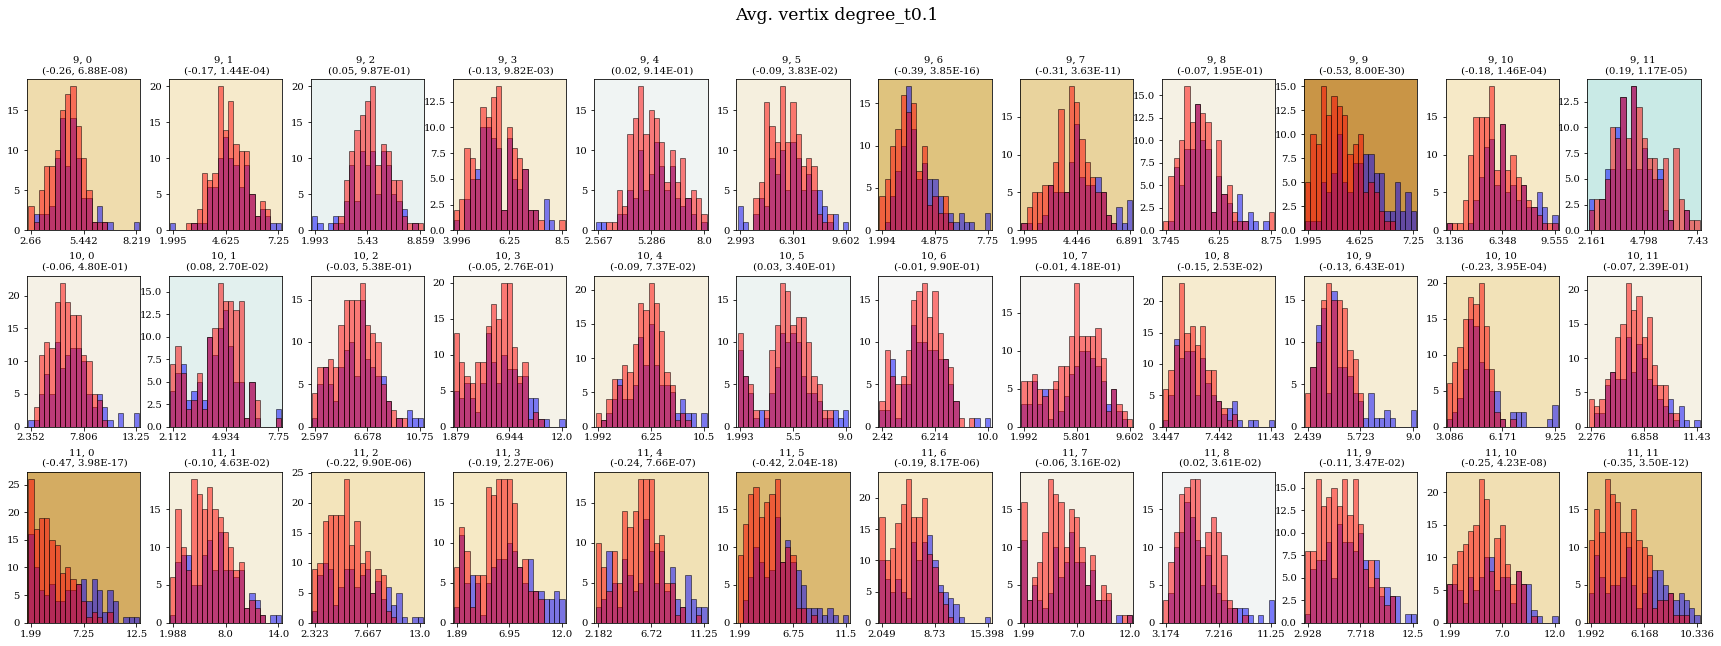

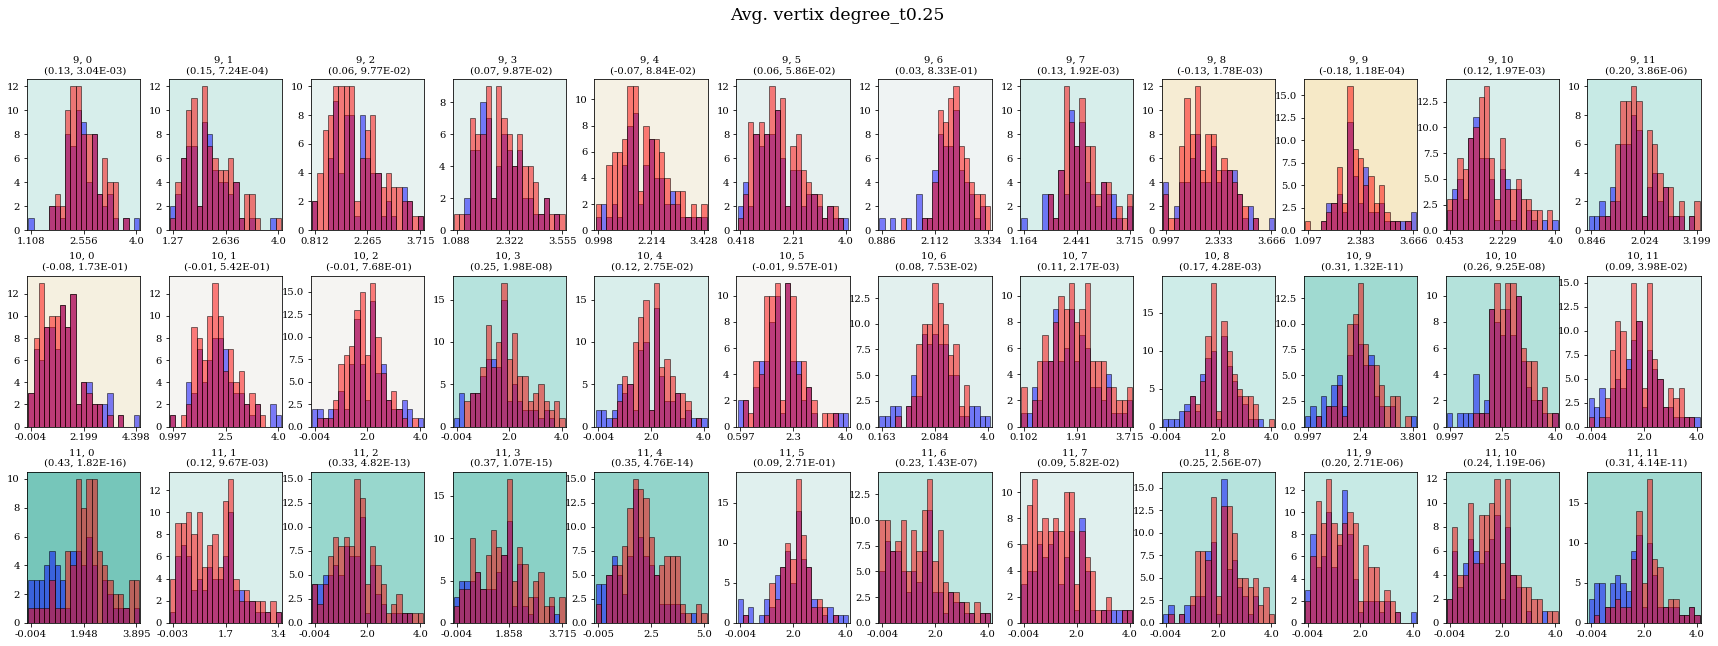

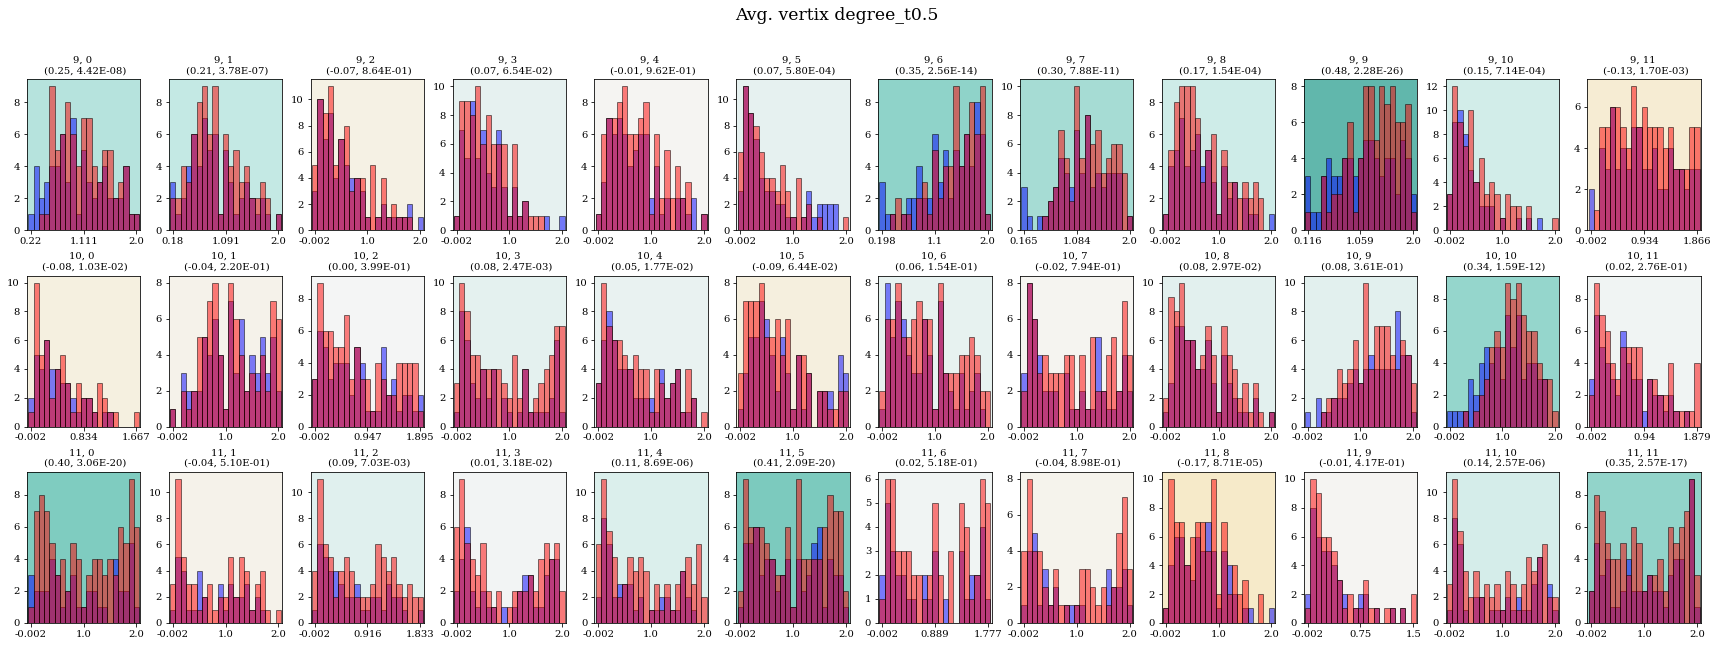

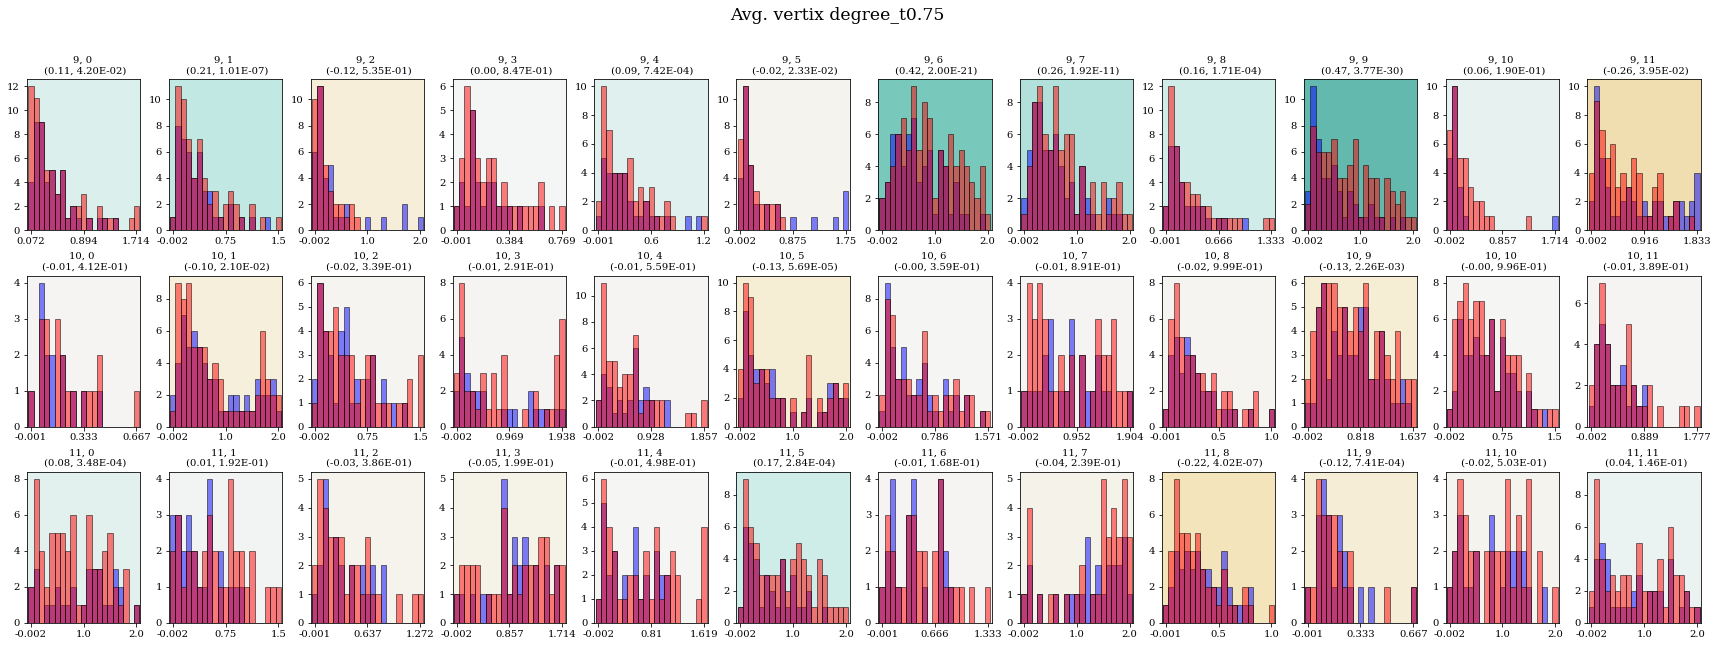

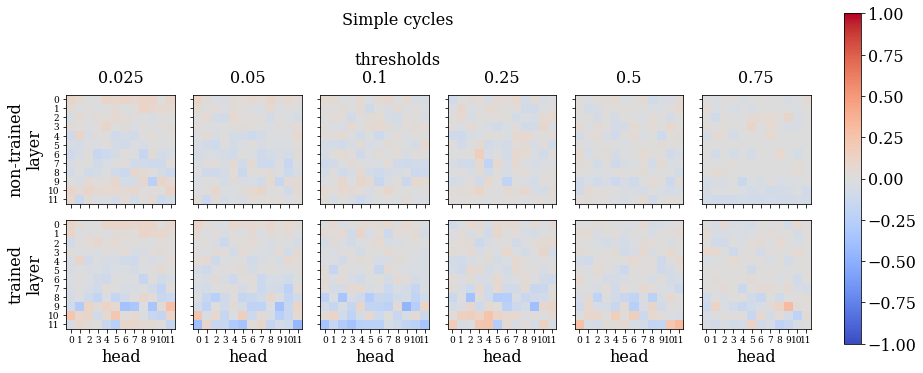

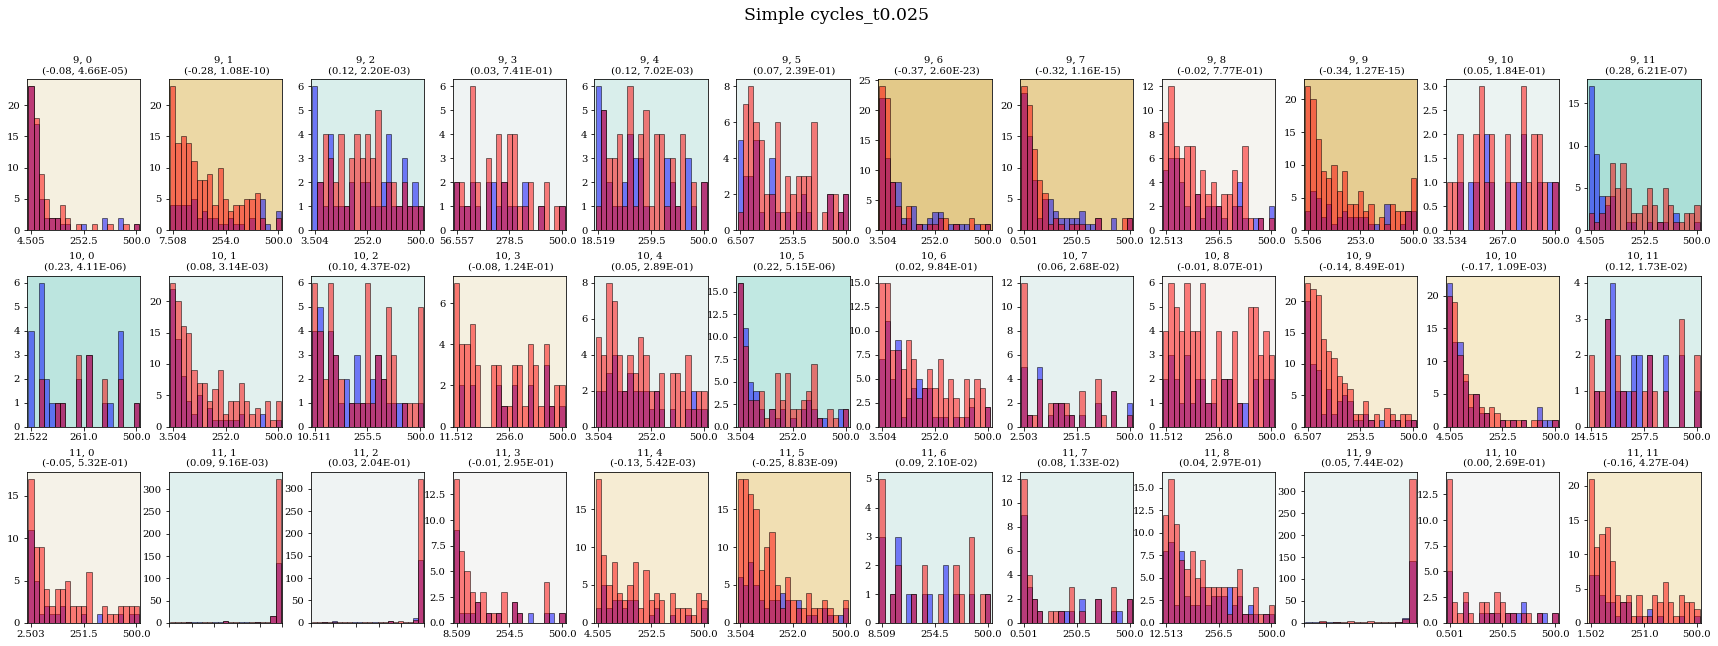

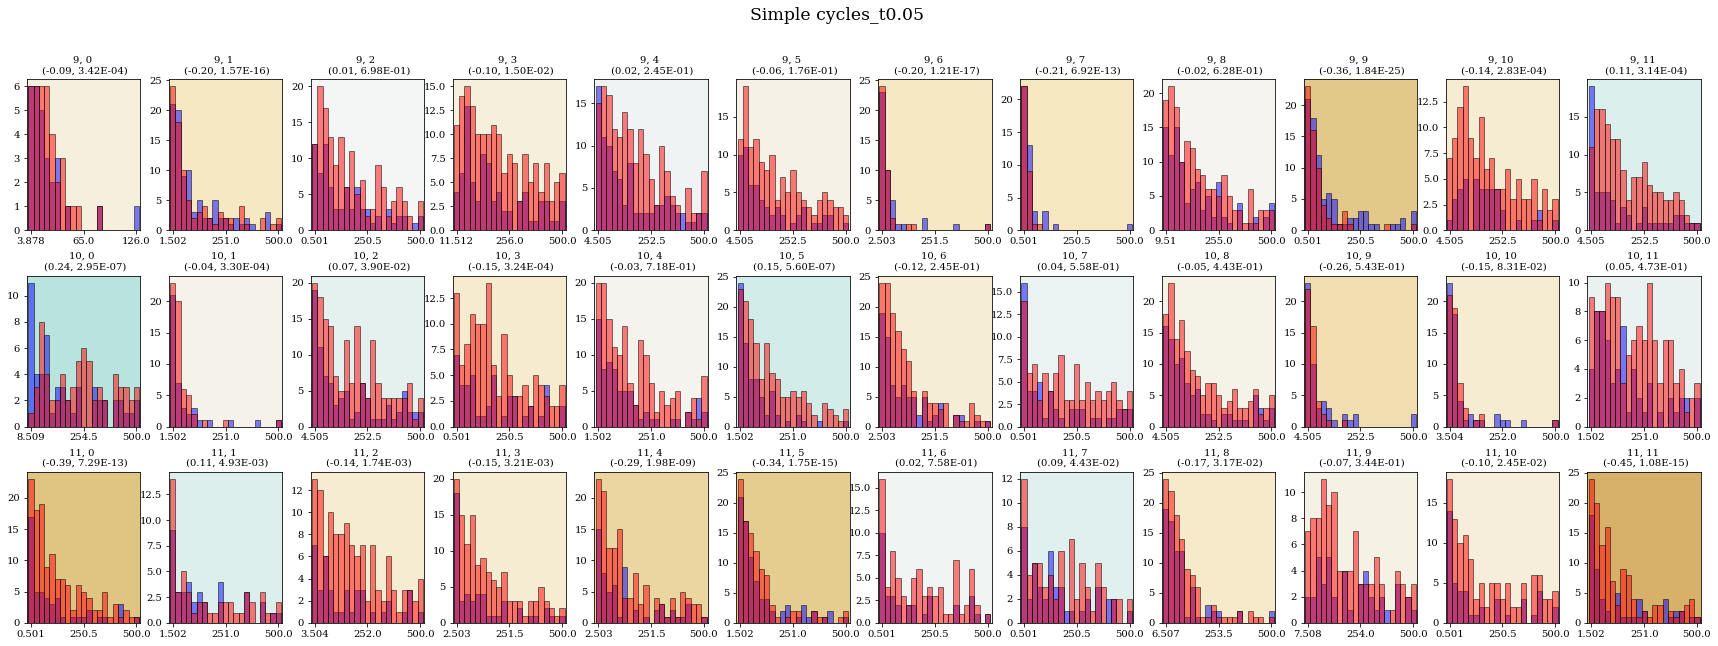

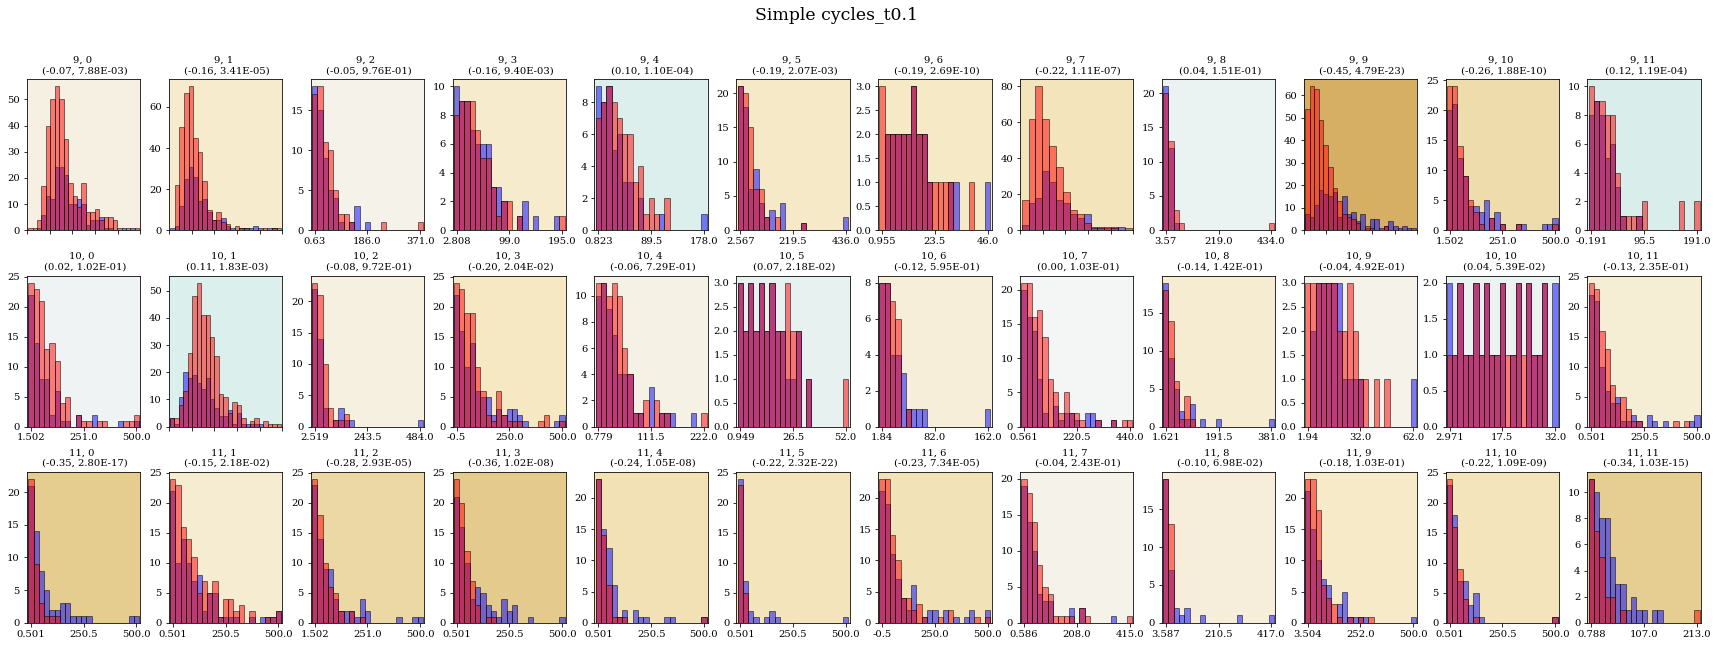

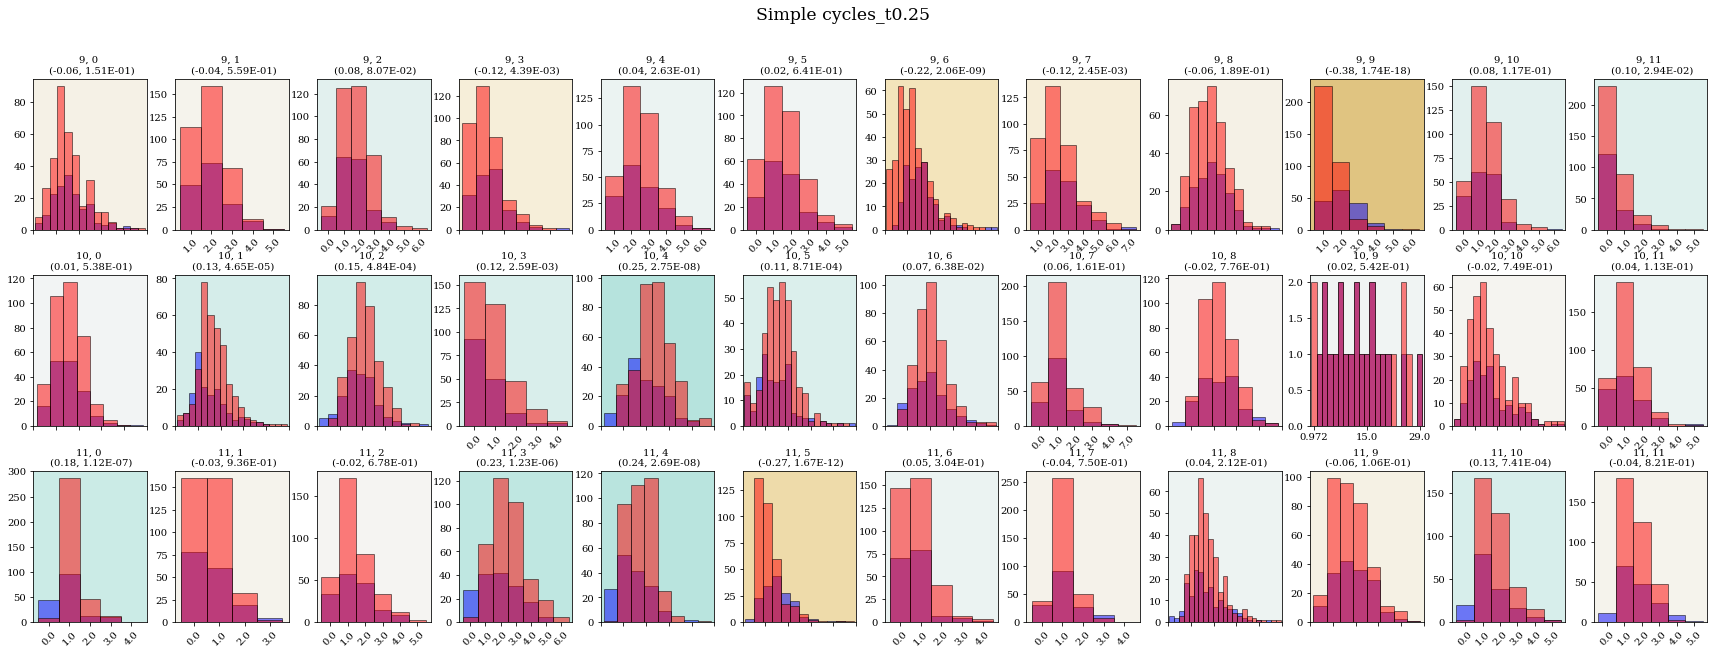

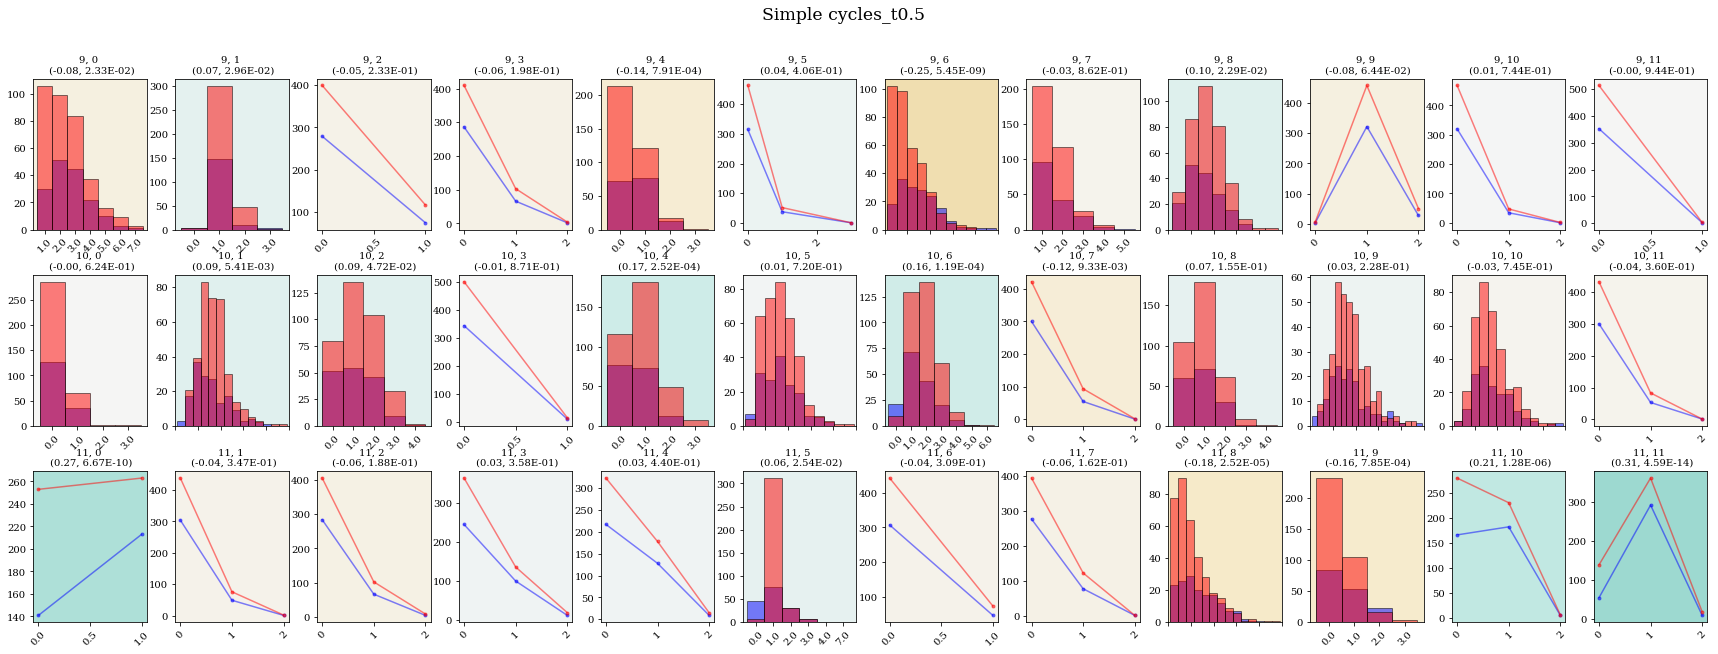

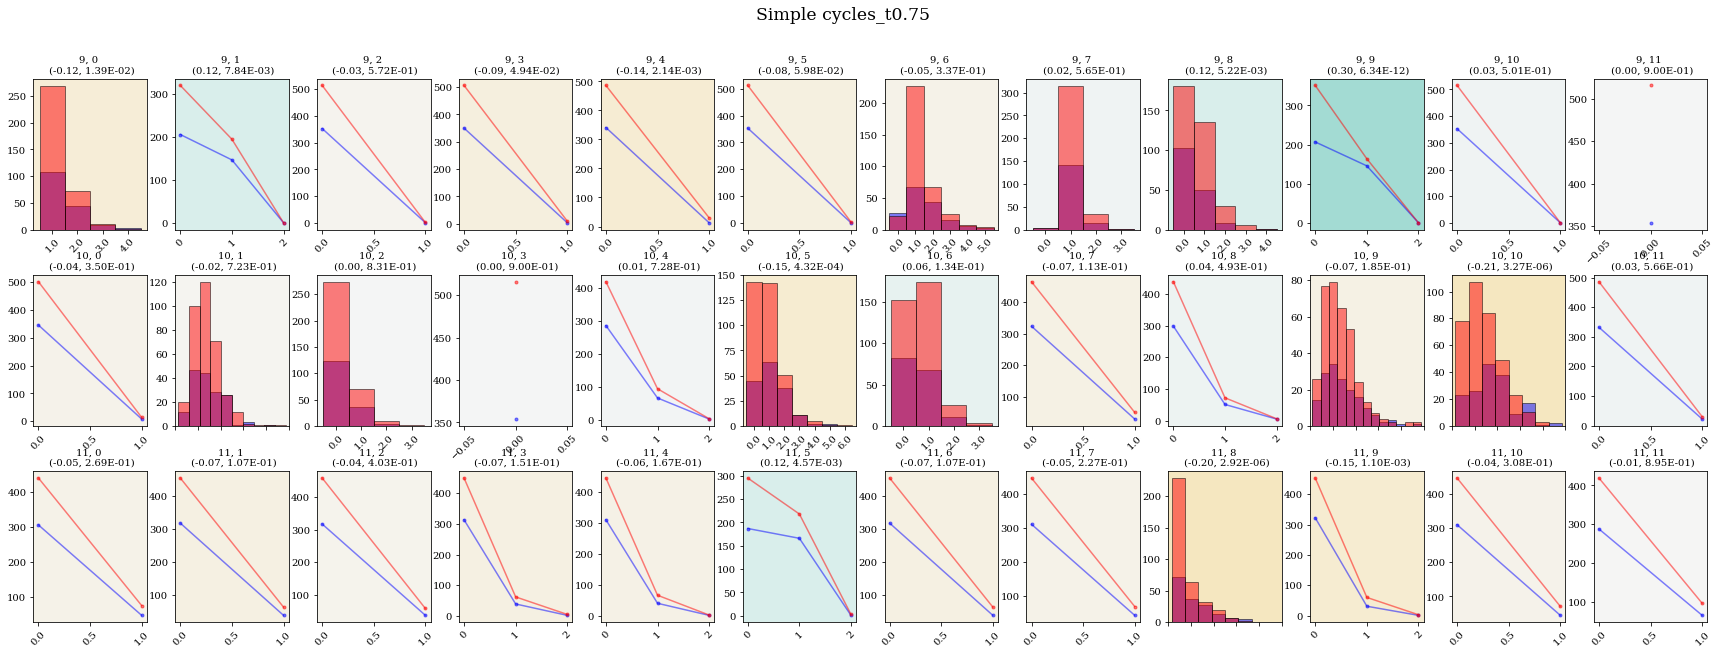

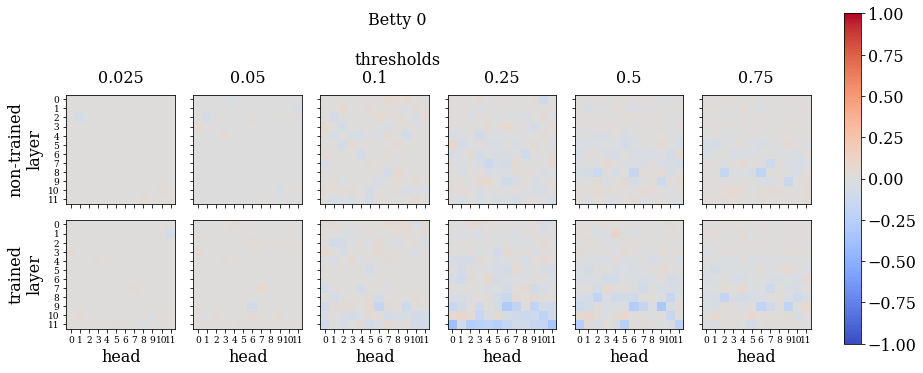

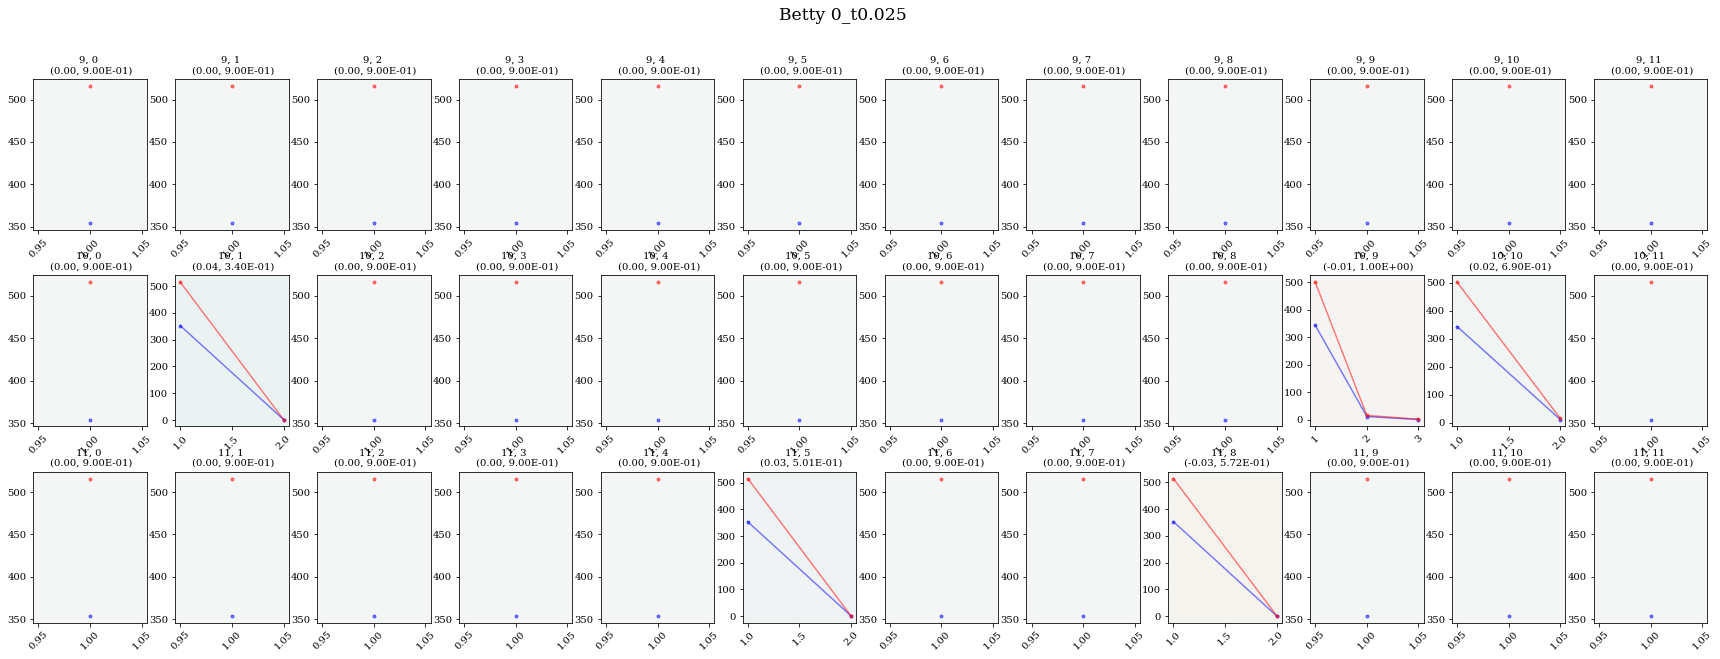

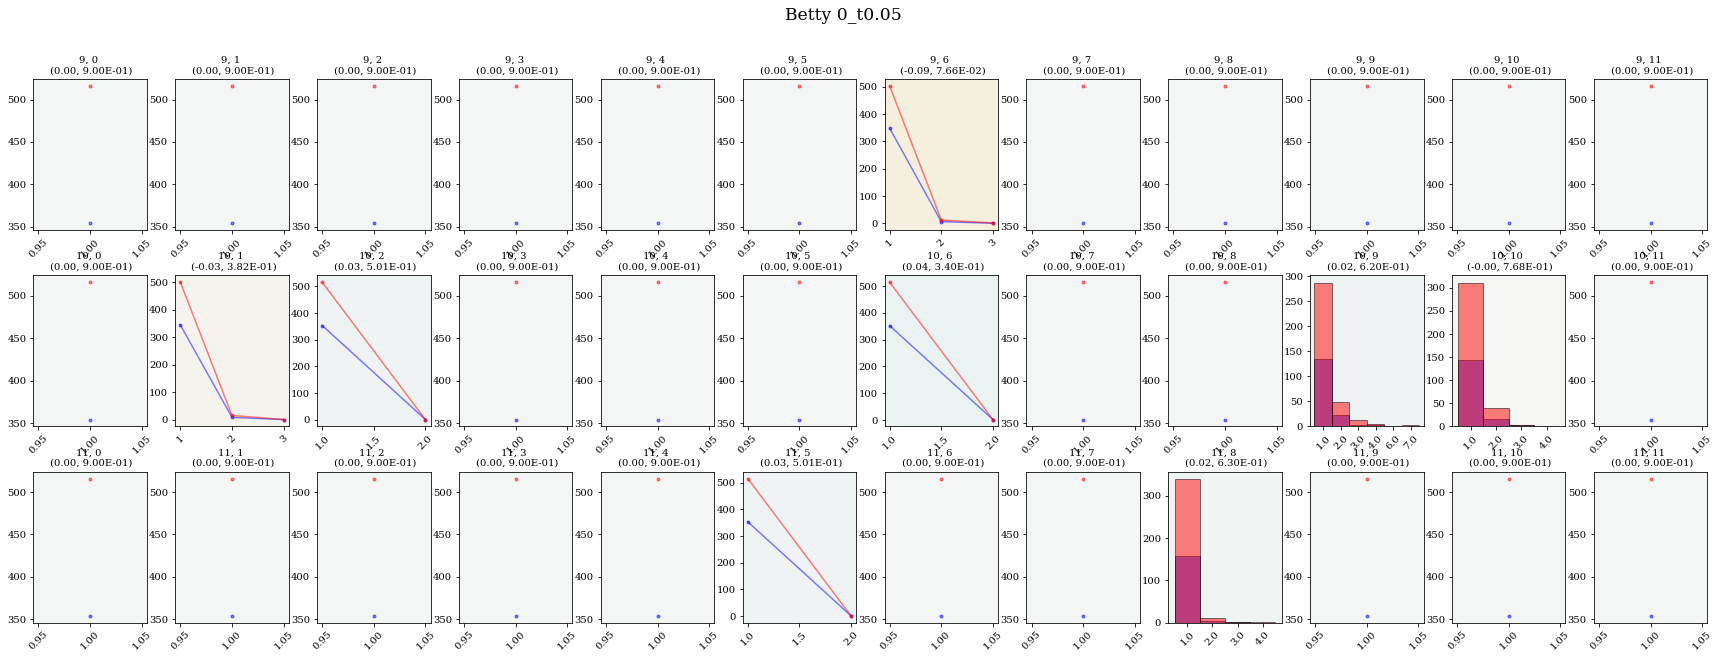

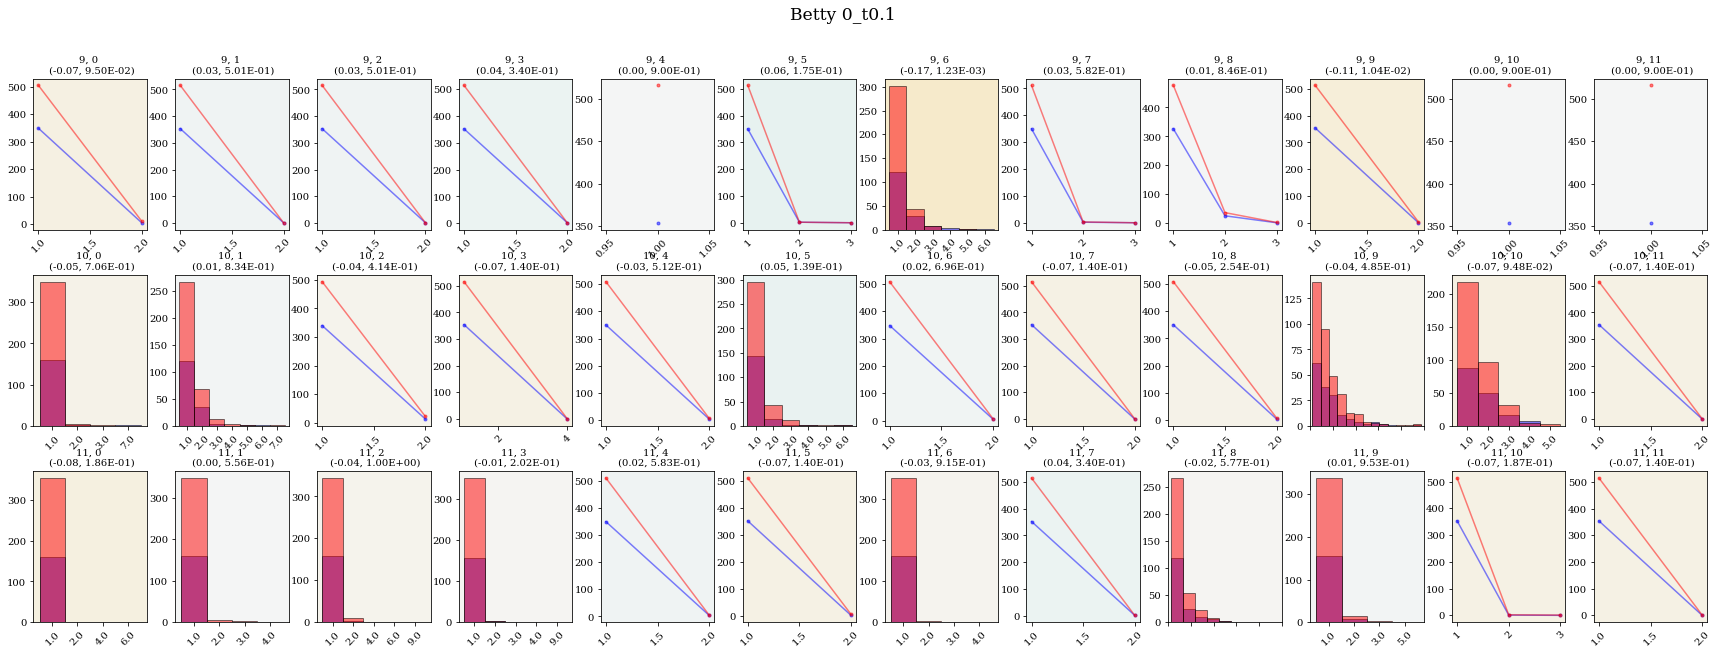

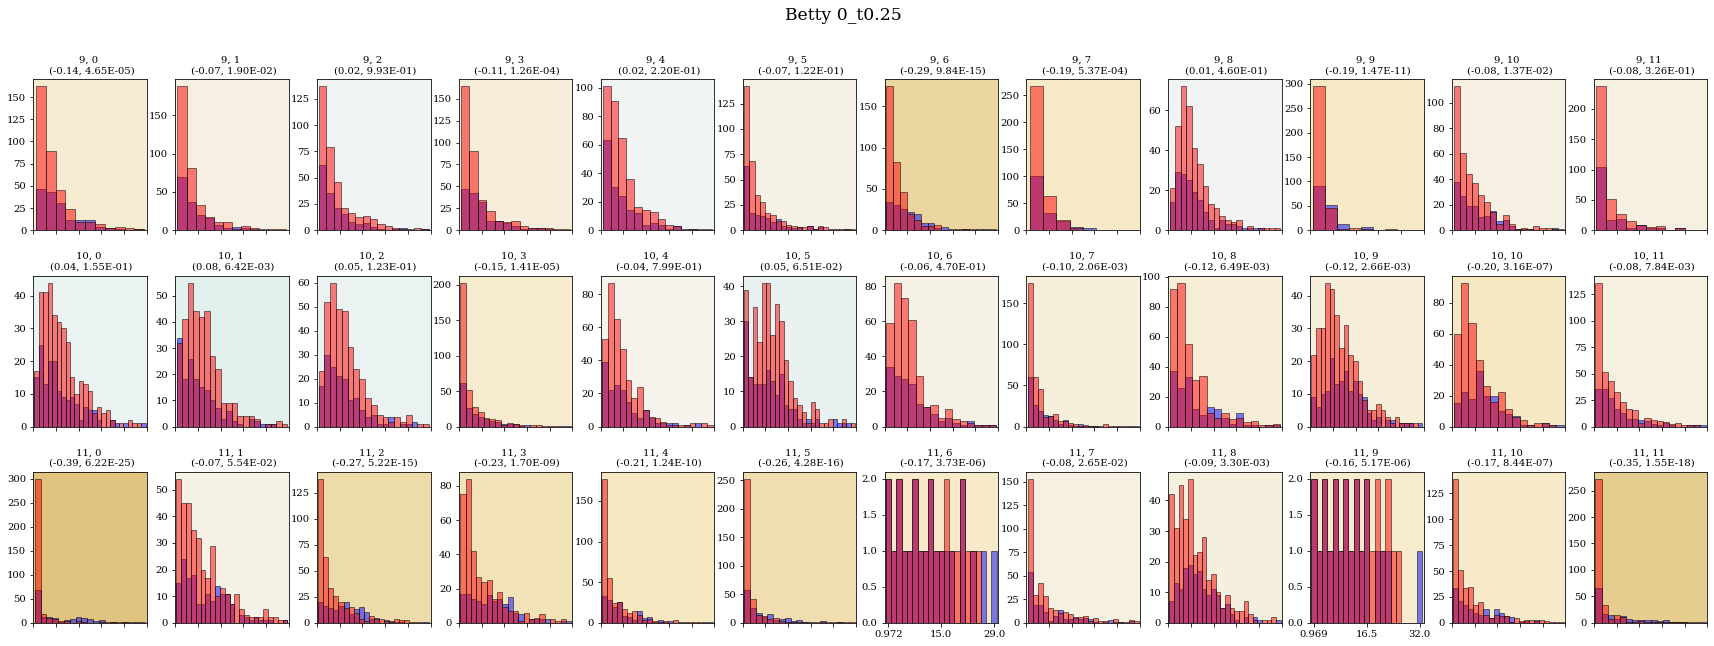

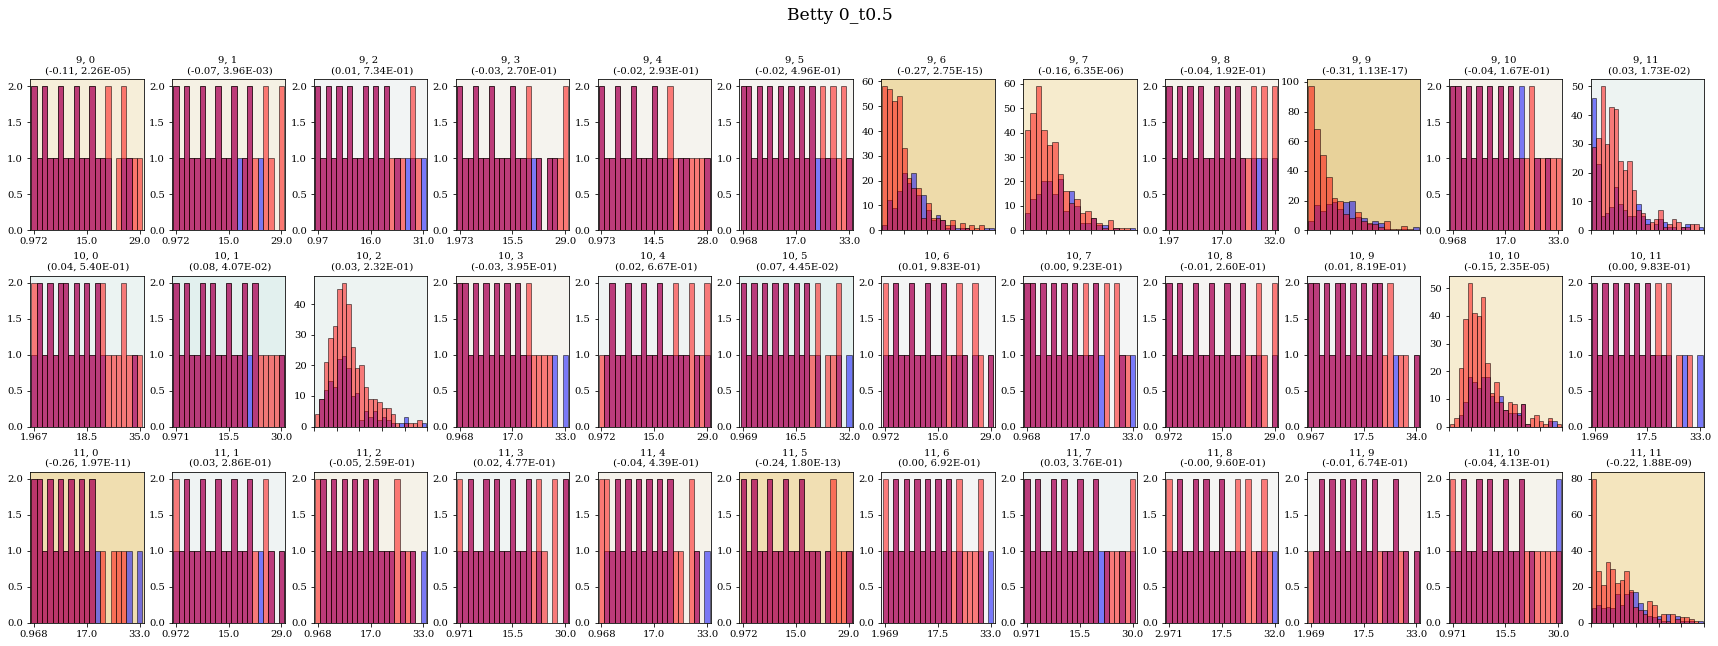

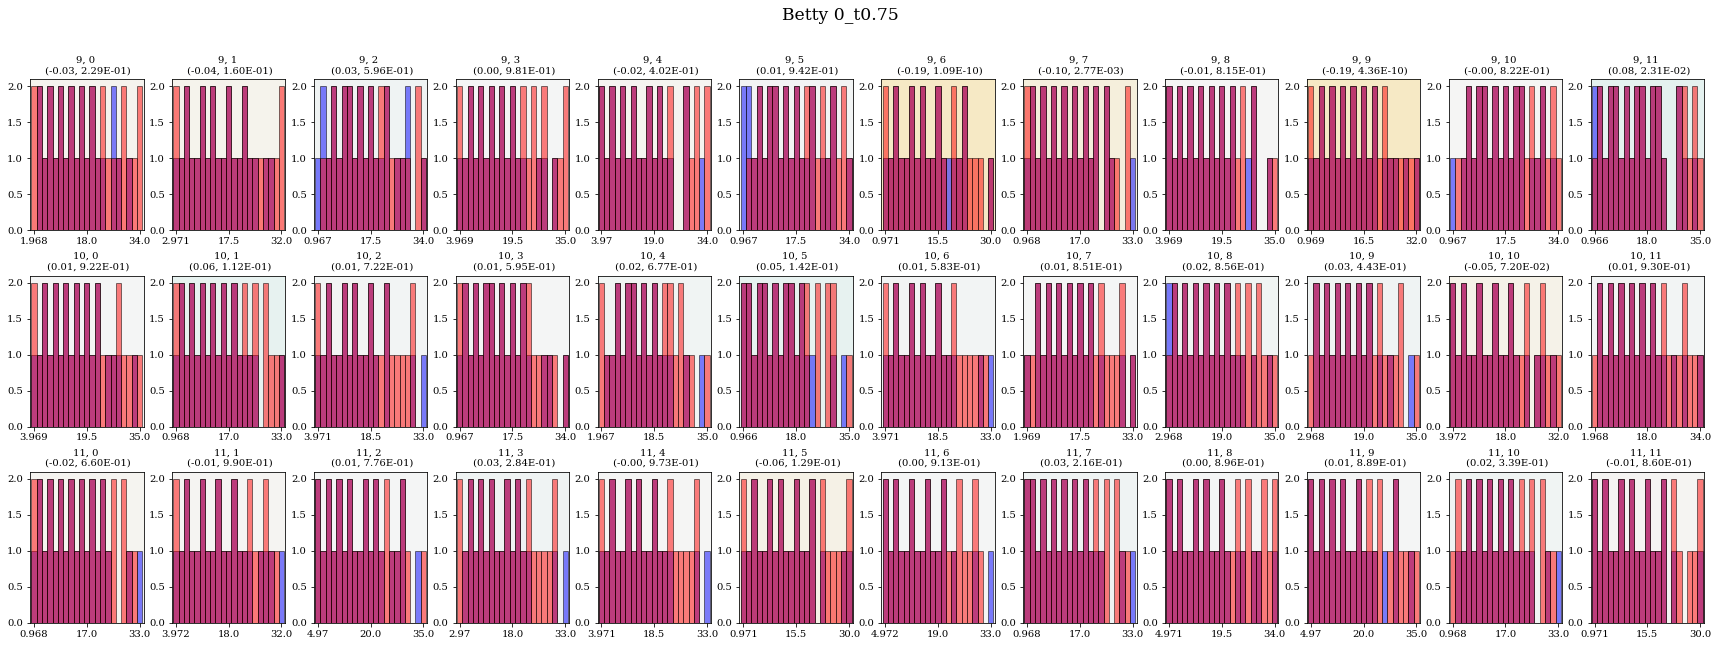

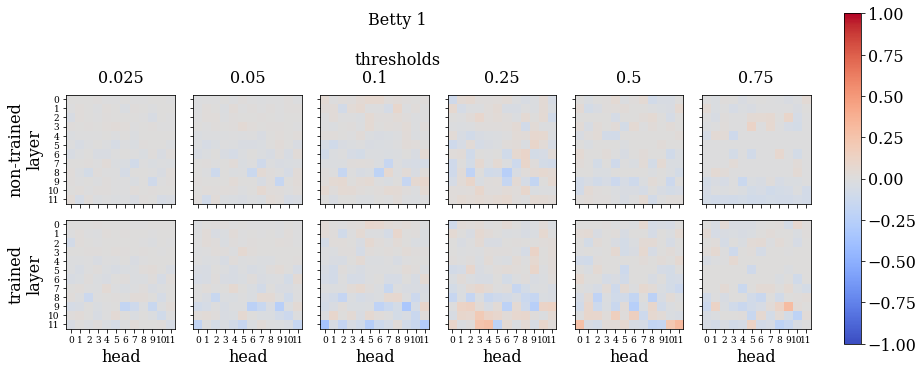

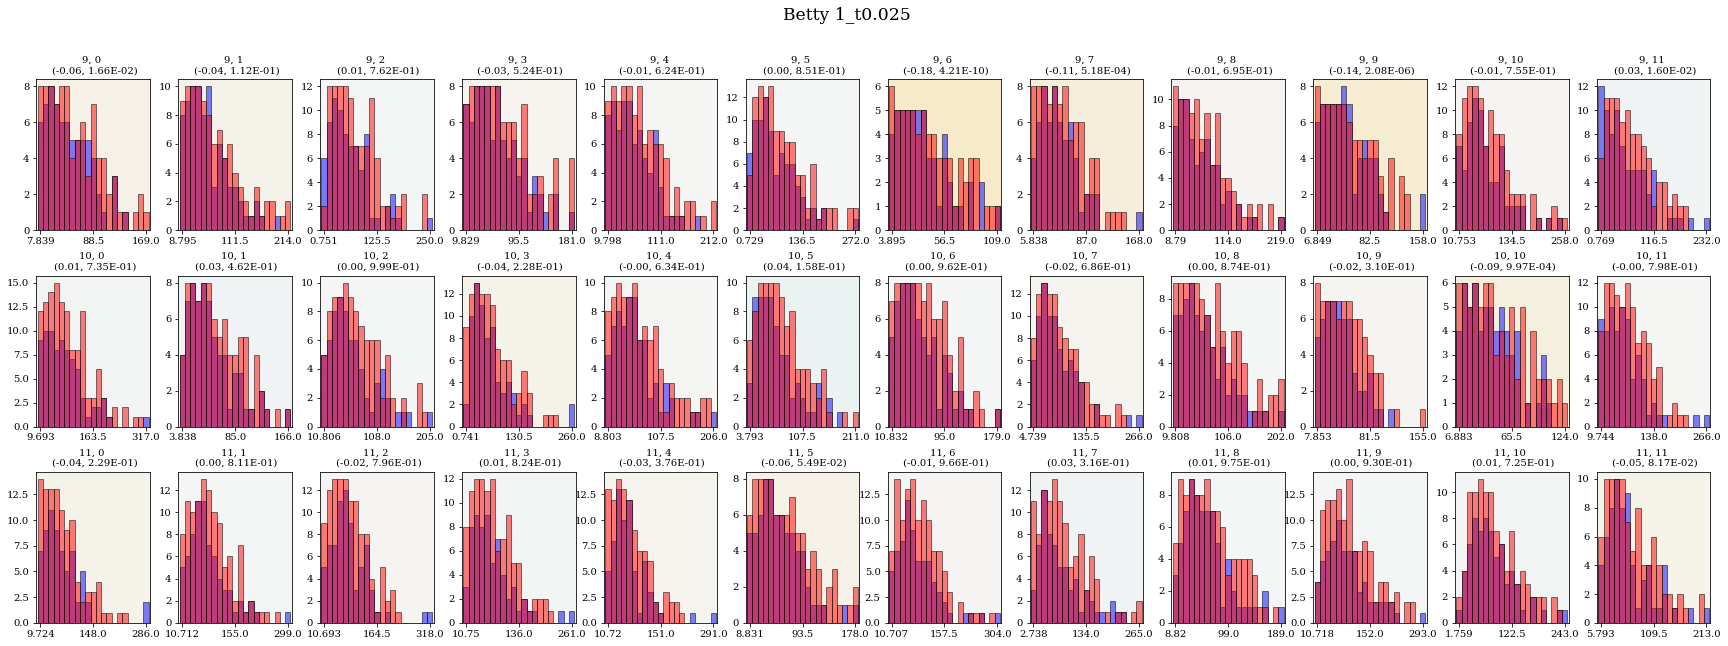

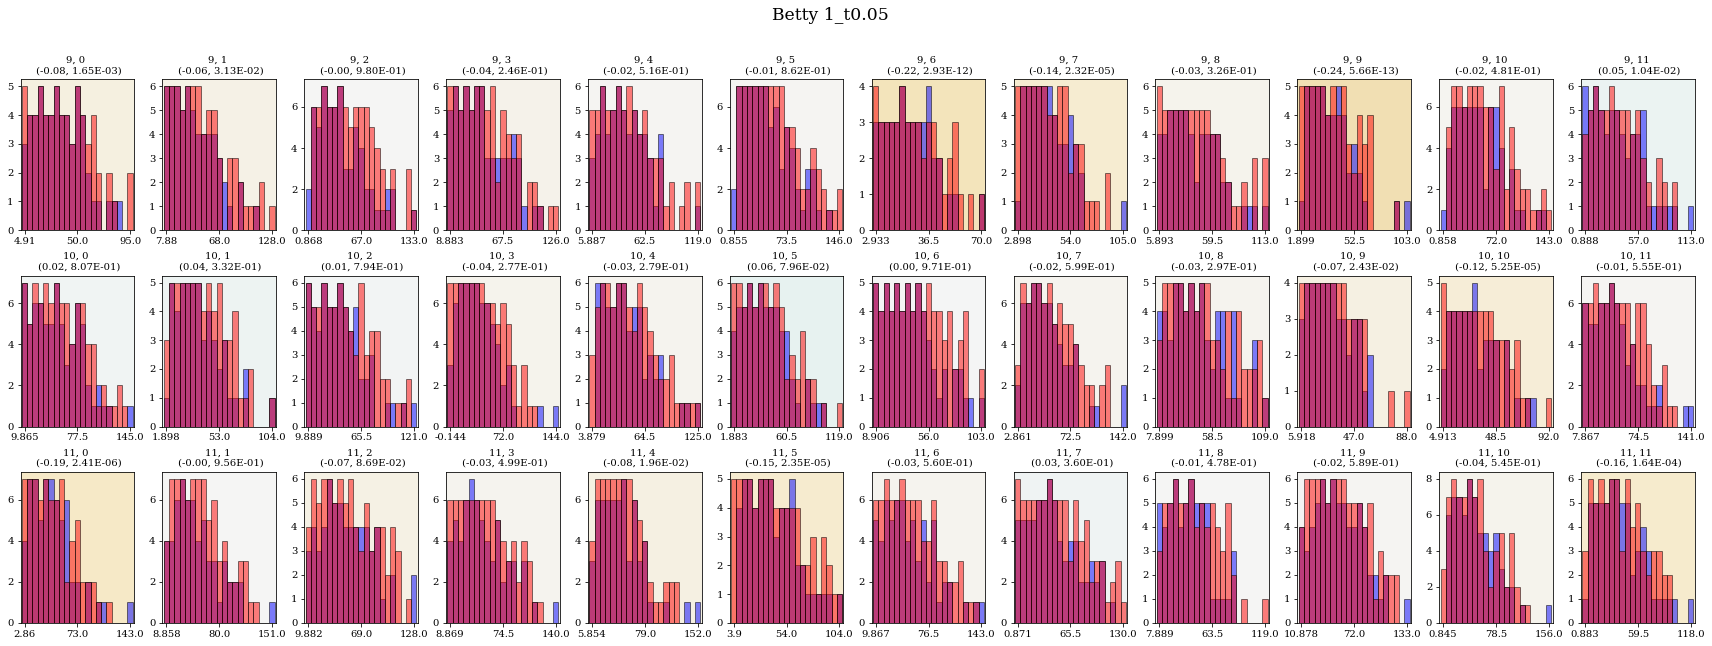

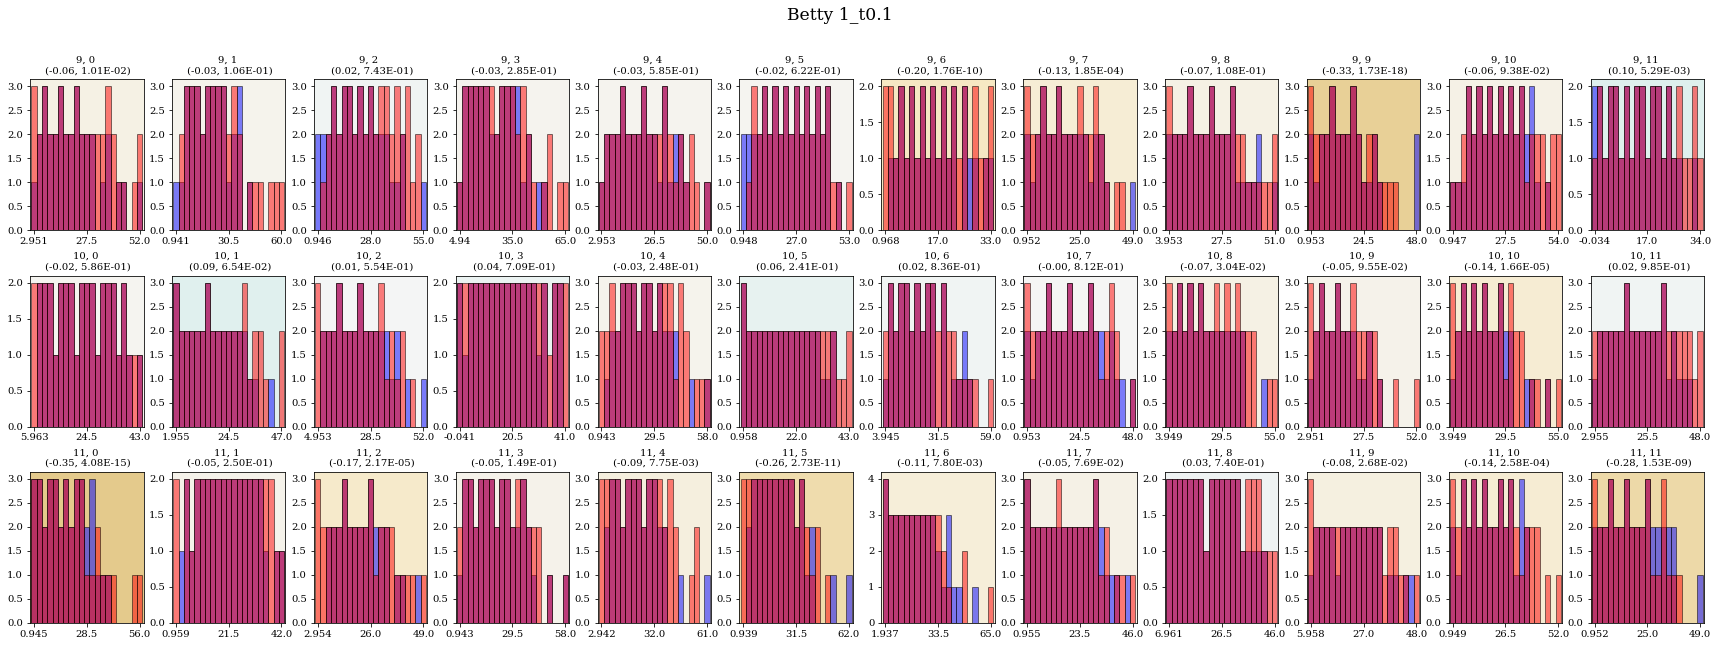

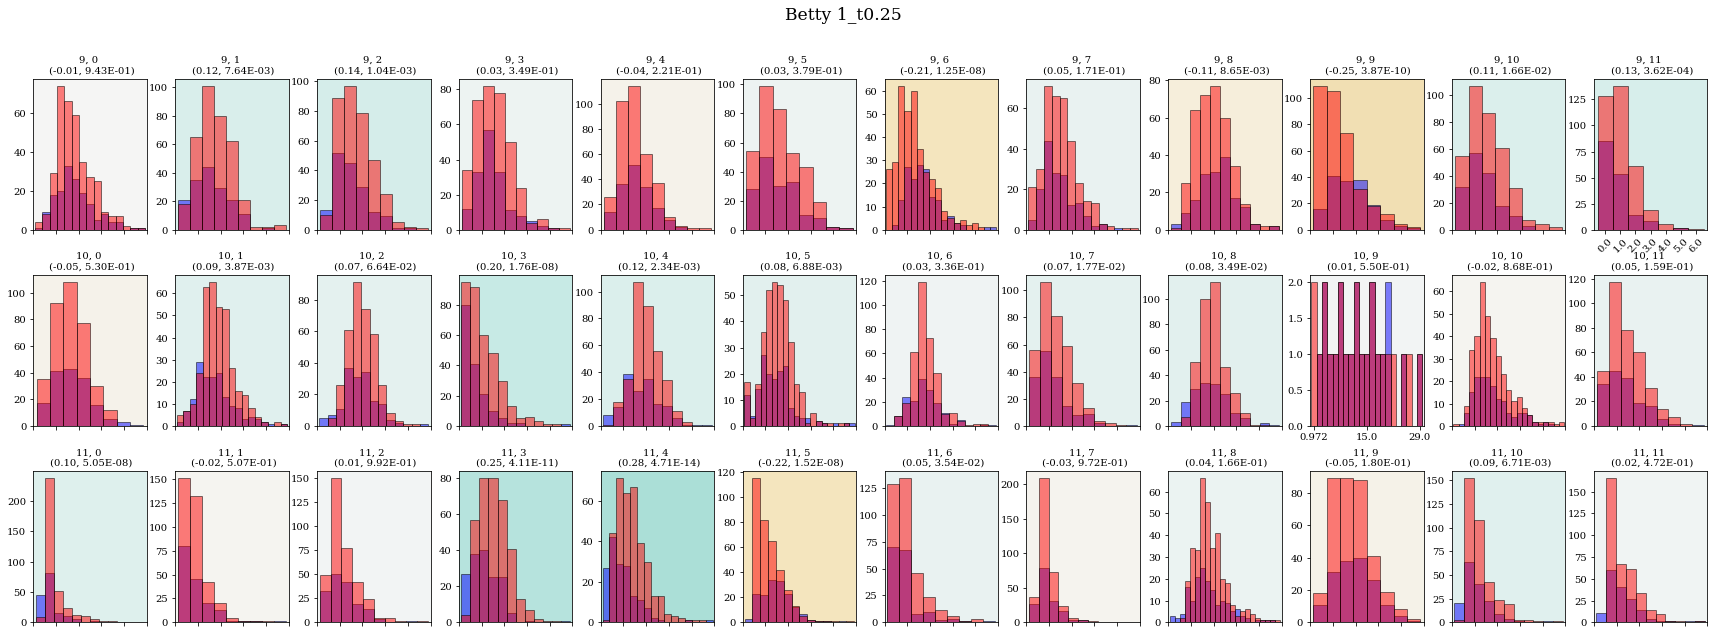

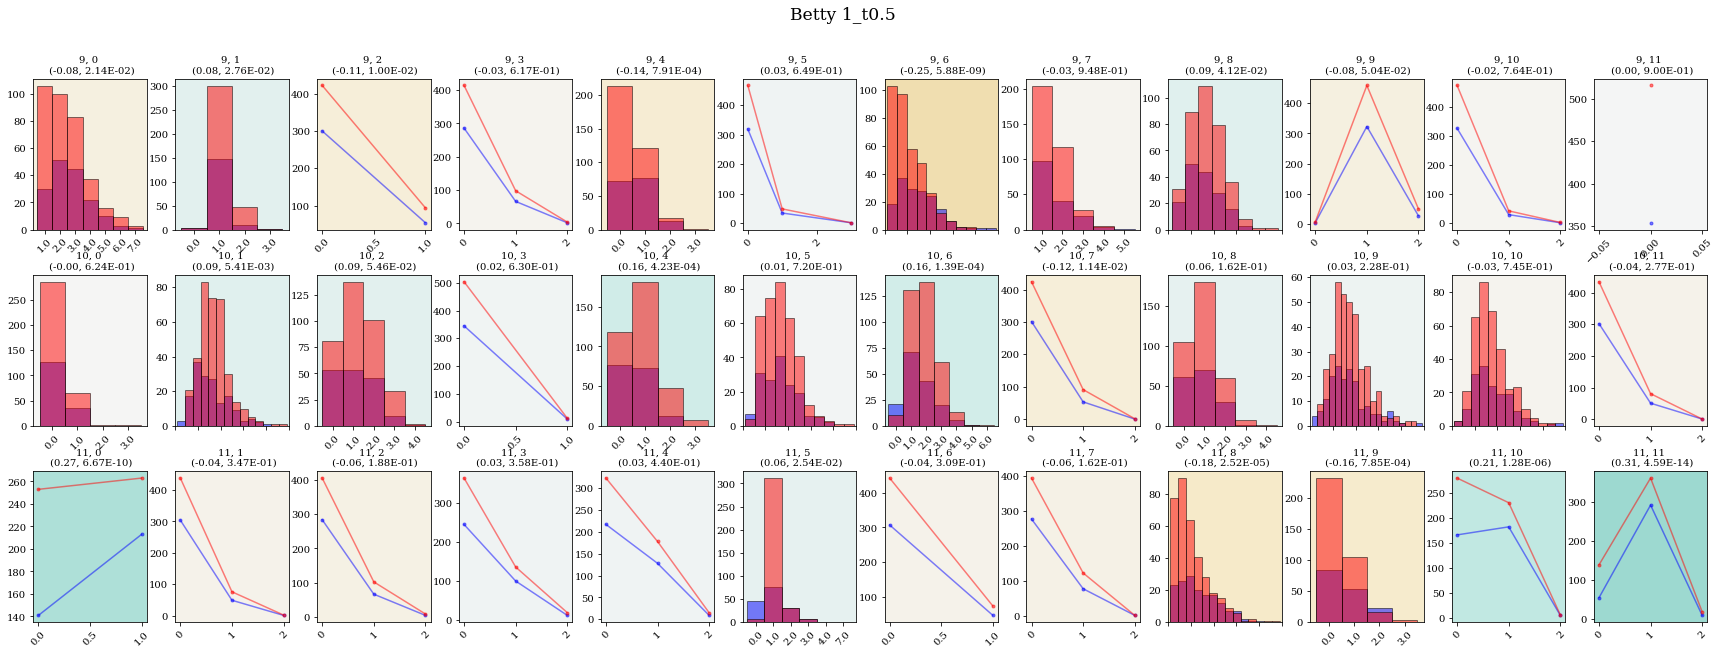

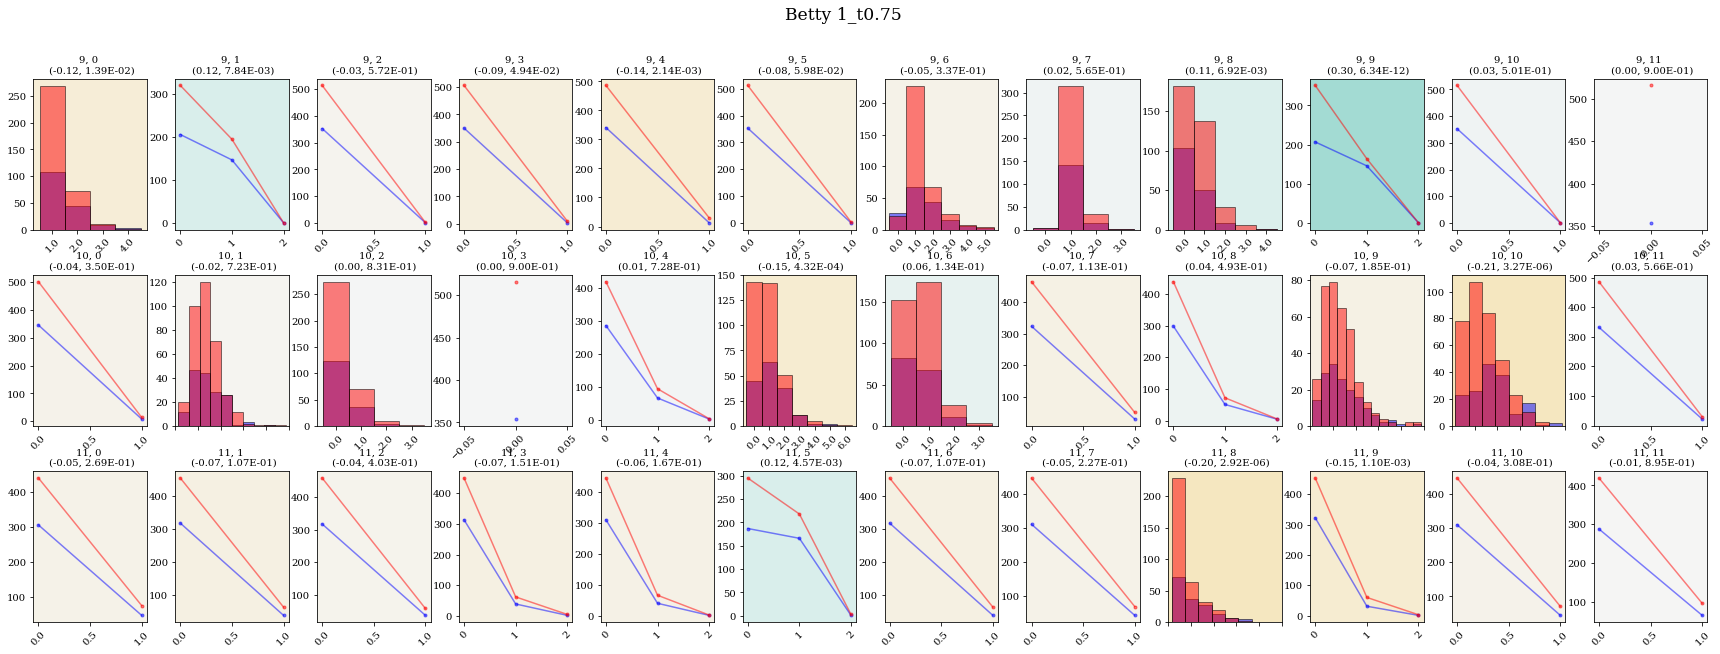

In [32]:
pdf = PdfPages(f"{output_dir}{subset}_top_features_distributions.pdf")
save = True
cur_matrices = find_values('topological', matrices)
for f in topological_names:
    params  = [topological_features_tr, topological_get_layer_head,topological_feature_names]
    data = make_comparison_data(cur_matrices[0], matrices['topological']['corr'][1], f, names = topological_names, topological = topological_thresholds)
    draw_heatmaps_trained_nontrained(data, thresholds = topological_thresholds, title=topological_titles[f])
    for t in topological_thresholds: # [t1]
        plot_bt_distributions(cur_matrices, params = params, y=y, colormap = colormap, title = f'{topological_titles[f]}_t{t}',feature = f'{f}_t{t}', pdf_file = pdf)
pdf.close()

## Barcodes' distributions

In [33]:
barcode_titles

{'h0_s': 'h0, sum of lengths',
 'h0_e': 'h0, entropy',
 'h0_t_d': 'h0, death time',
 'h0_n_d_m_t0.75': '#h0, death time > t_0.75',
 'h0_n_d_m_t0.5': '#h0, death time > t_0.5',
 'h0_n_d_l_t0.25': '#h0, death time < t_0.25',
 'h1_t_b': 'h1, birth time',
 'h1_n_b_m_t0.25': '#h1, birth time > t_0.25',
 'h1_n_b_l_t0.95': '#h1, birth time < t_0.95',
 'h1_n_b_l_t0.70': '#h1, birth time < t_0.7',
 'h1_s': 'h1, sum of lengths',
 'h1_e': 'h1, entropy',
 'h1_v': 'h1, variance of lengths',
 'h1_nb': 'number of barcodes in h1'}

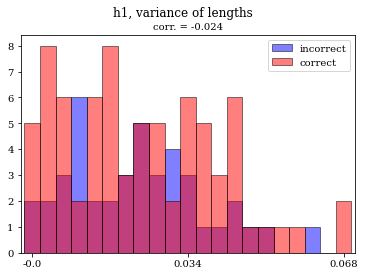

In [34]:
# ex_barcodes
cur_matrix = matrices['barcode']['corr'][0]
f = 'h1_v'
feat = f'{f}'
layer = 9
head = 11
fig, ax = plt.subplots()
fig.suptitle(f'{barcode_titles[f]}')
corr_coeff =cur_matrix[feat][layer,head]
plot_histogram(layer, head, feat,
        barcode_features_tr, barcode_get_layer_head,barcode_feature_names, y, 
        ax=ax, title='corr. = %0.3f' % (corr_coeff,),
        legend=True,
        # color=colormap.to_rgba(corr_coeff)
        )

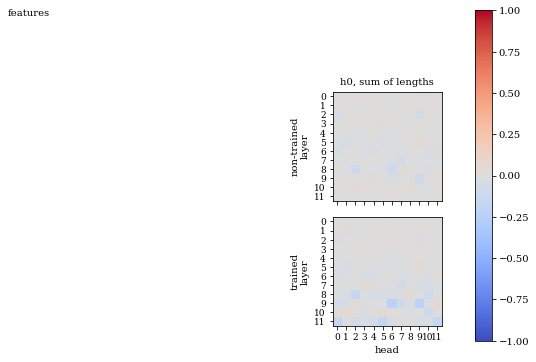

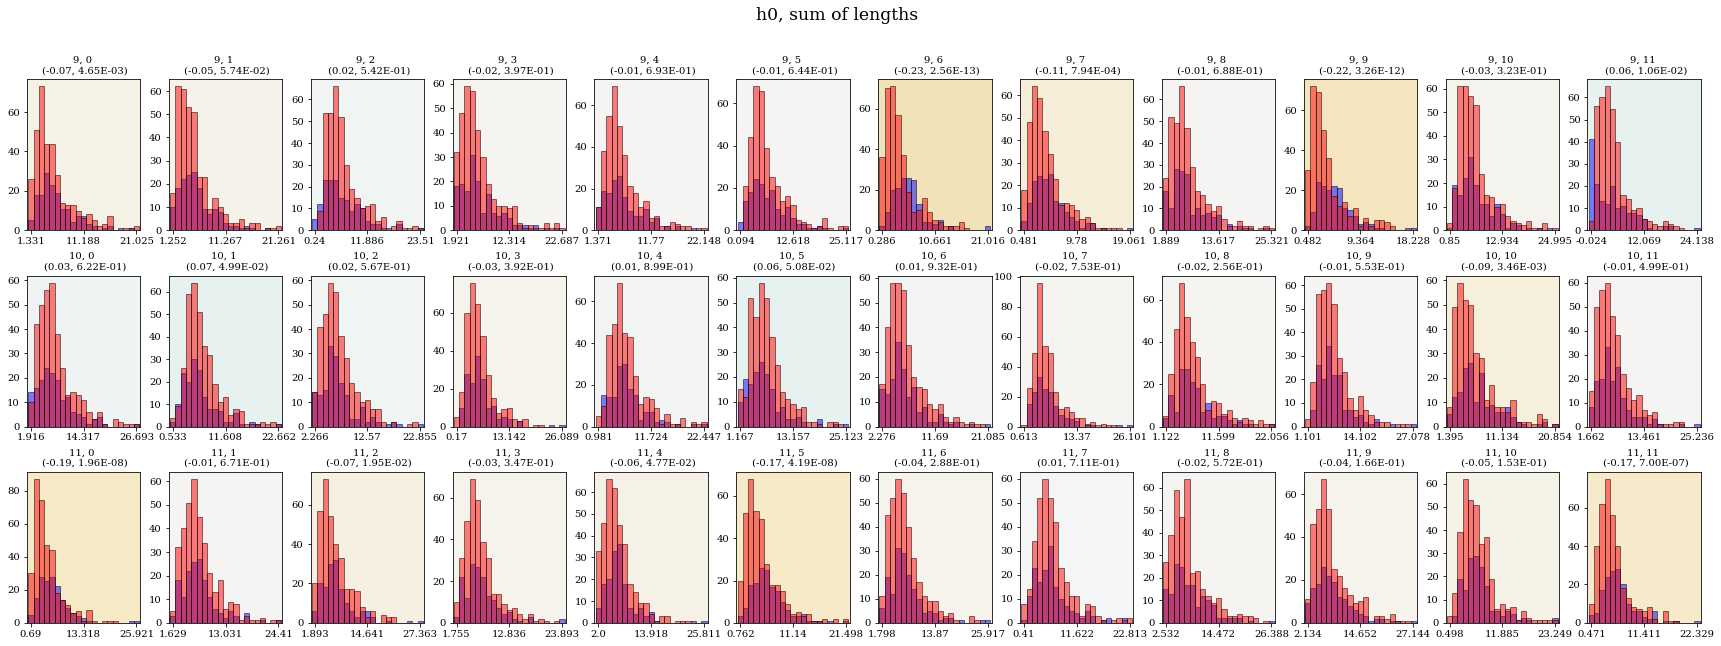

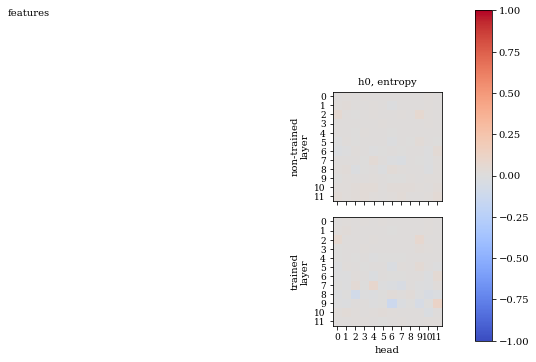

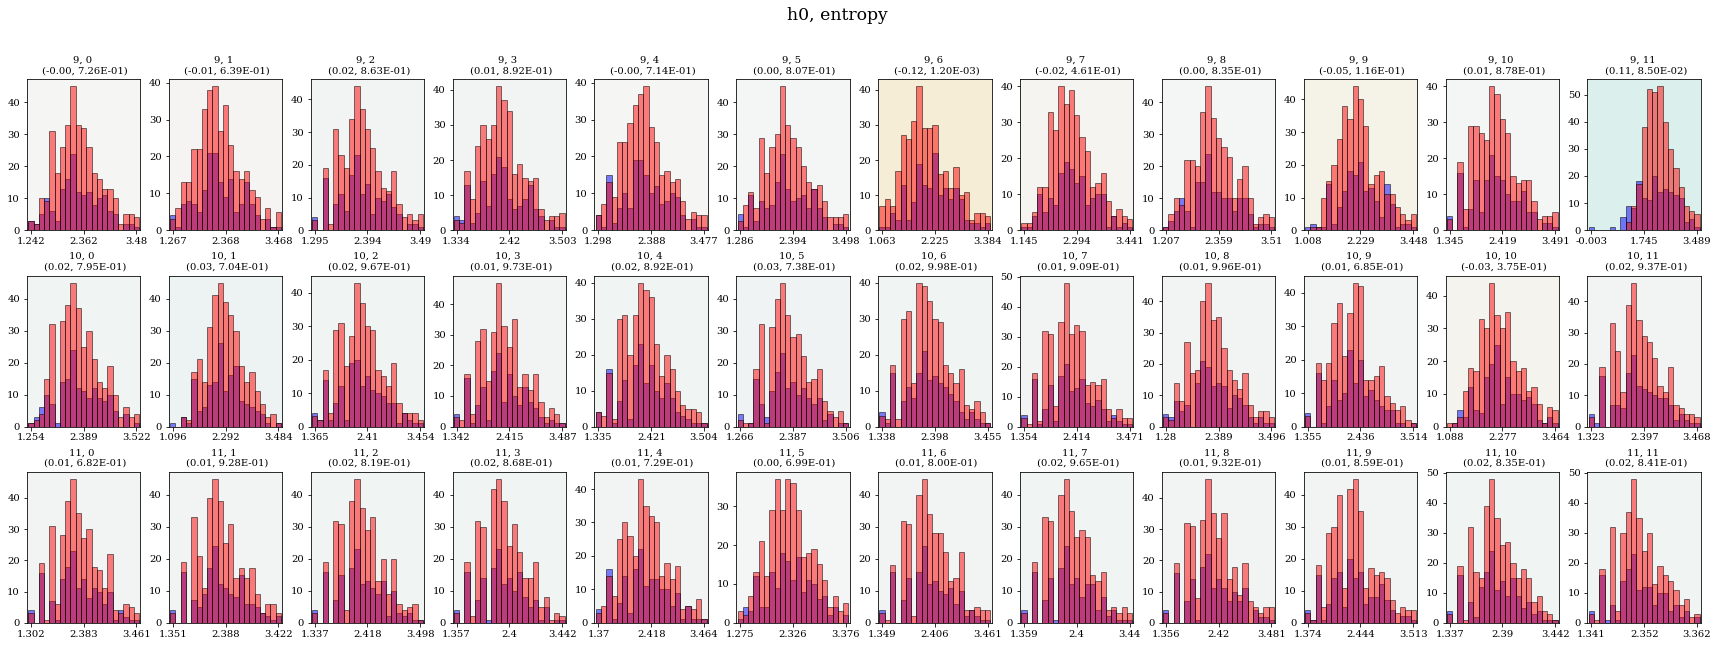

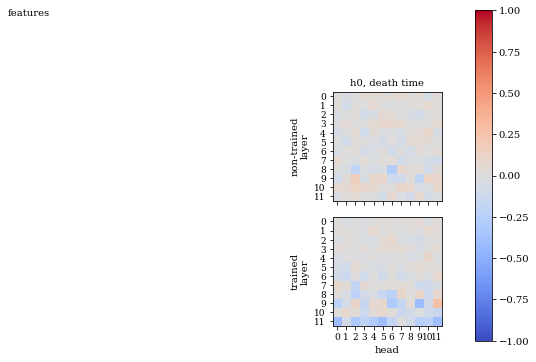

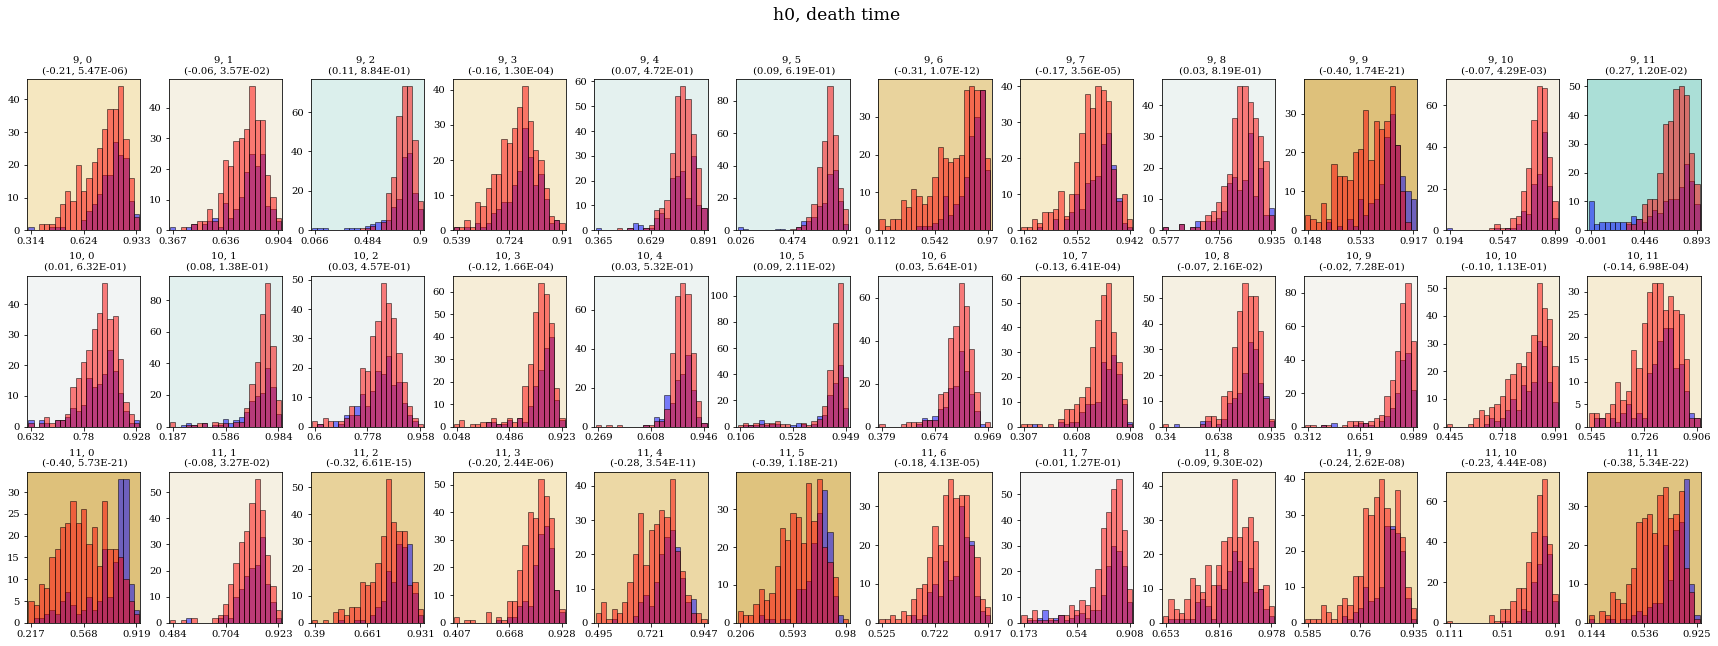

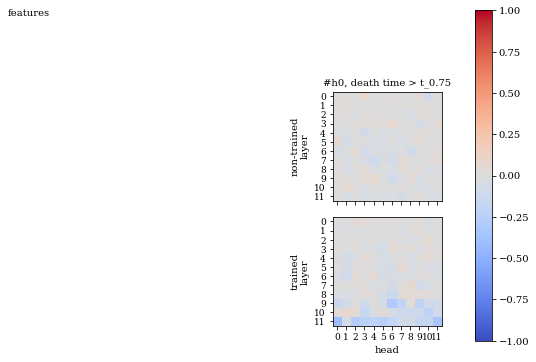

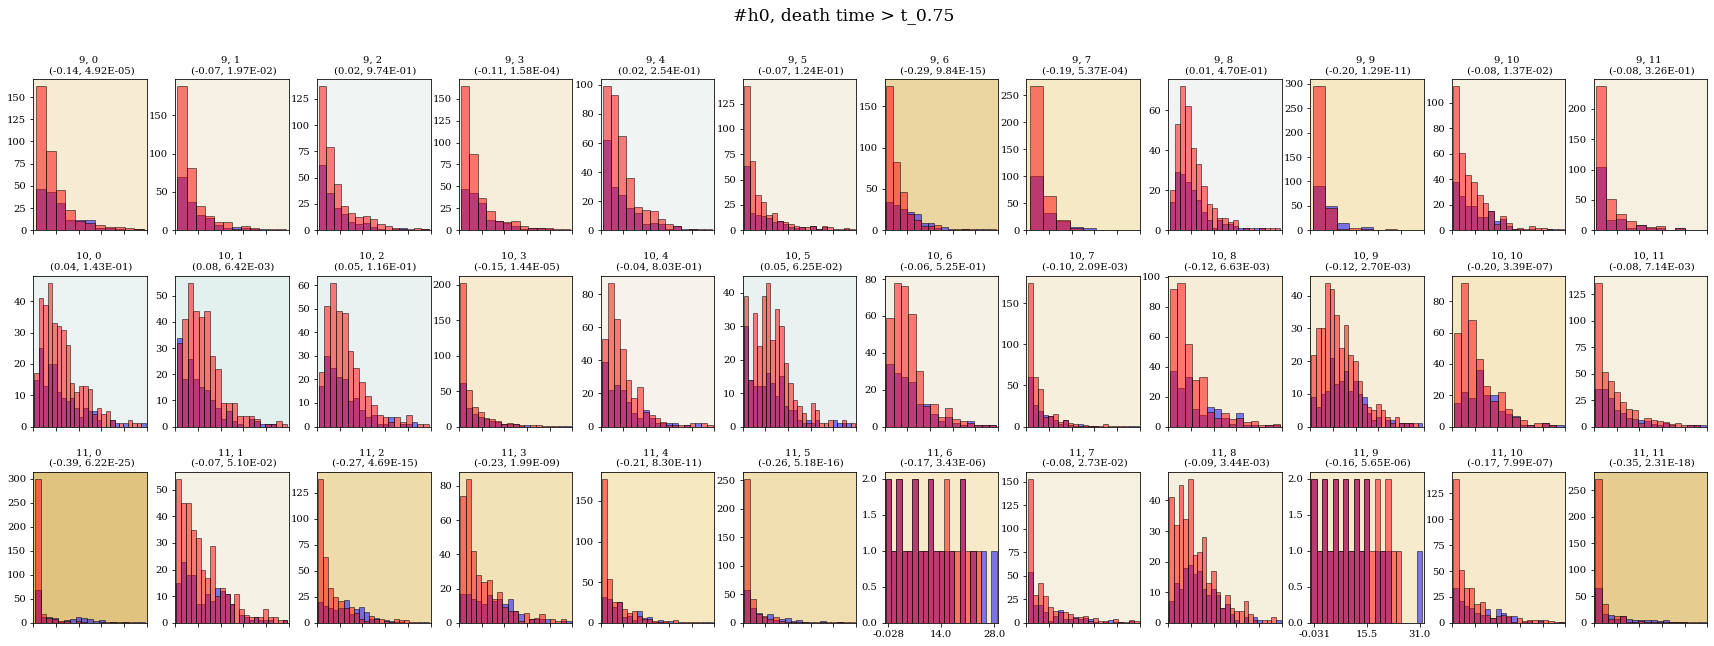

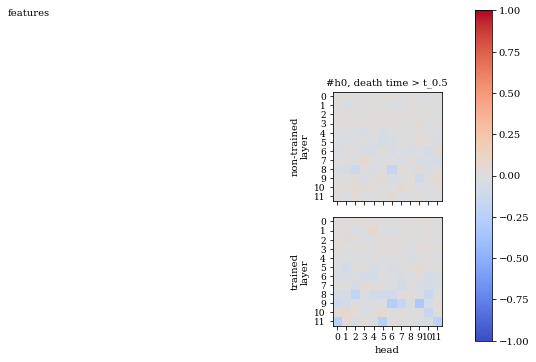

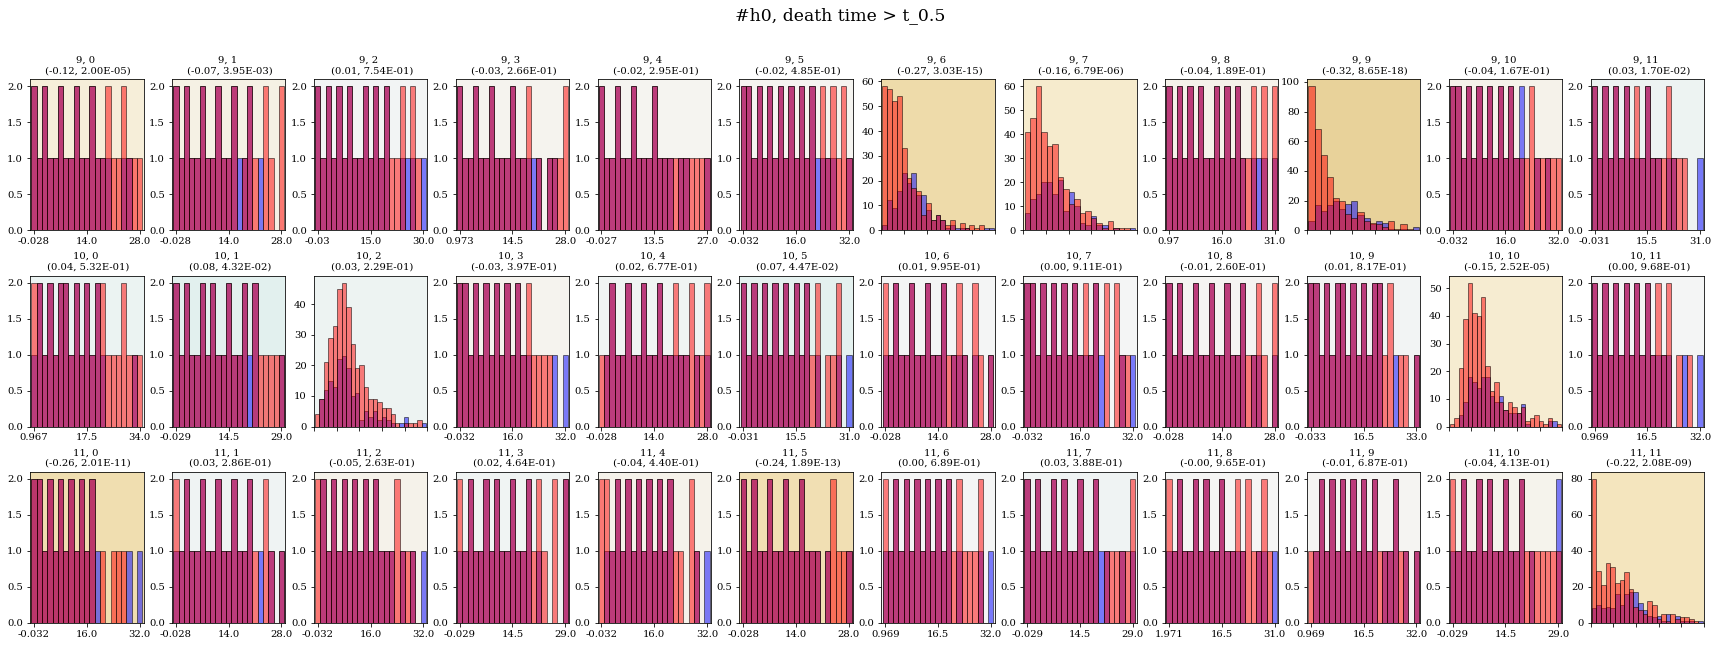

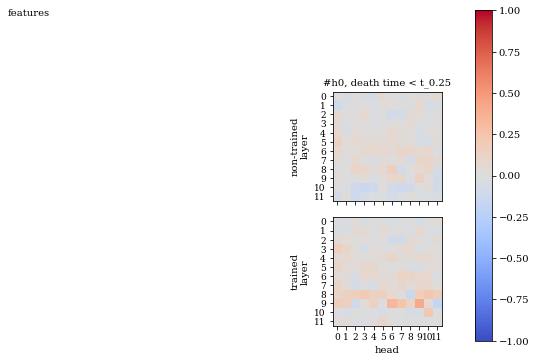

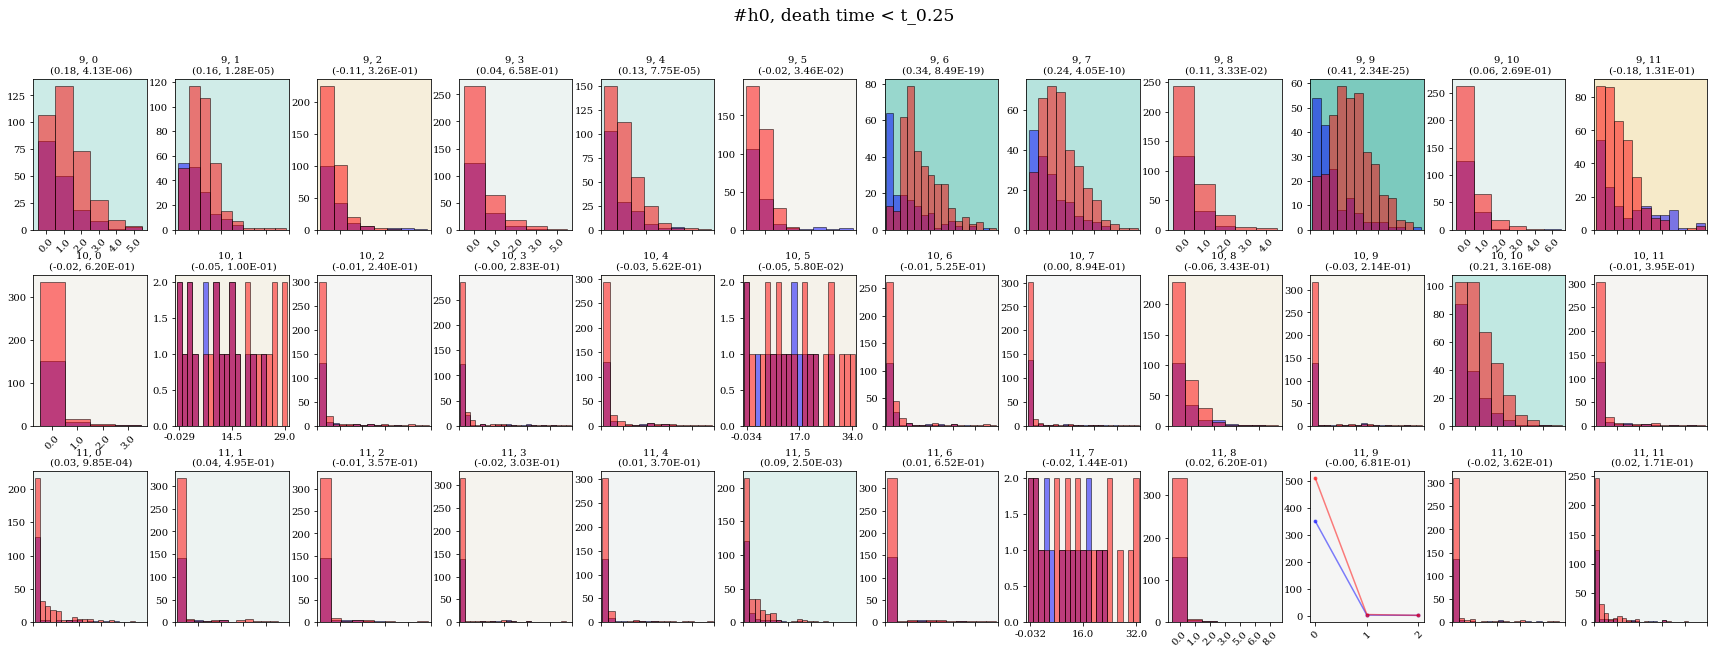

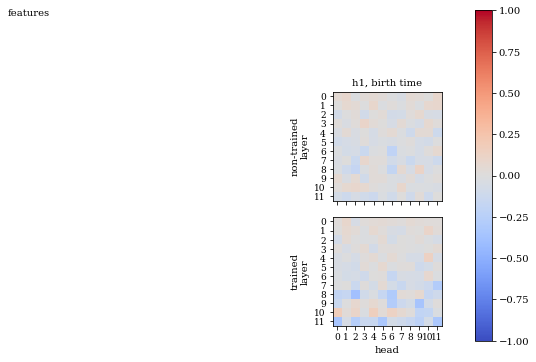

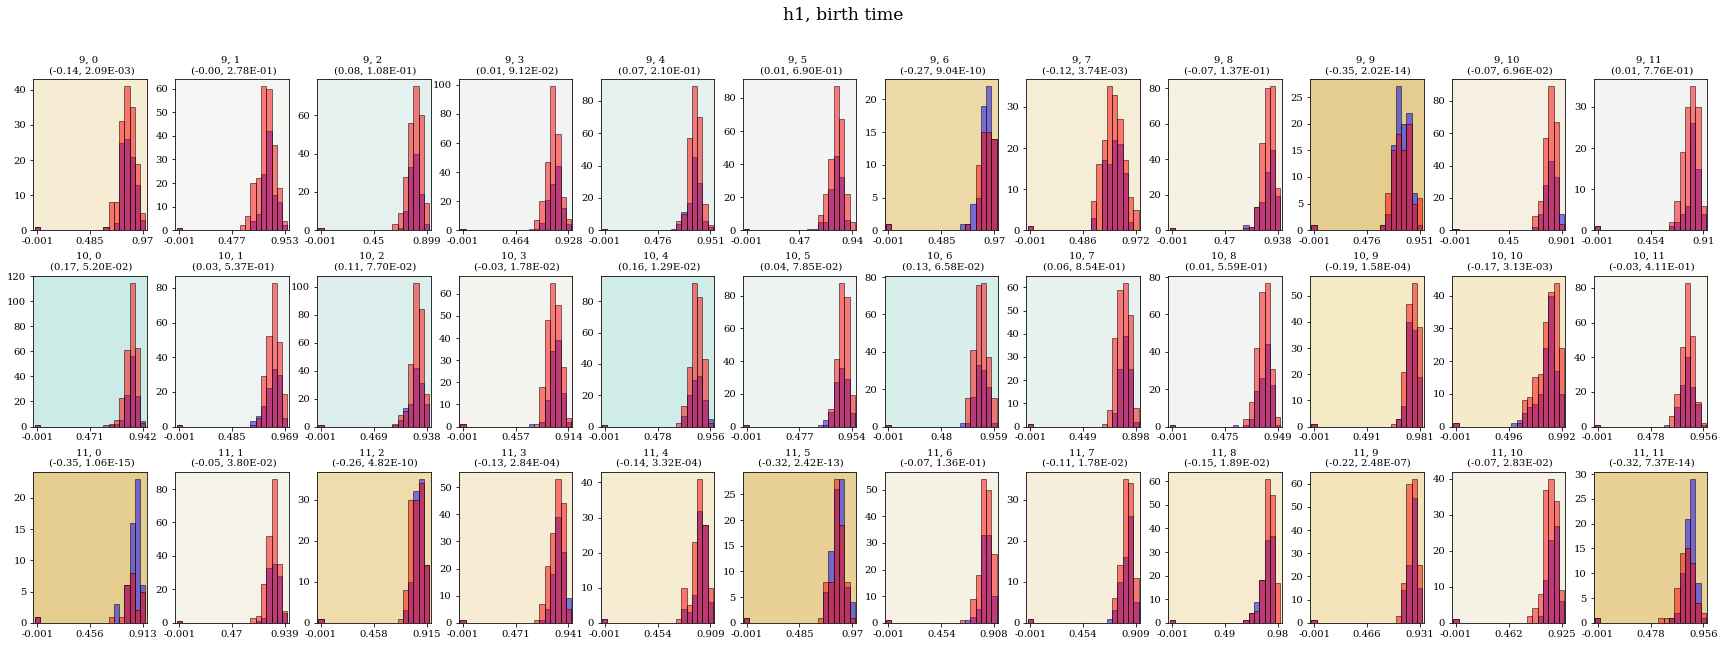

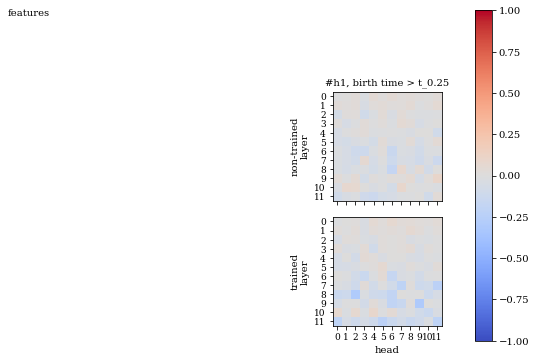

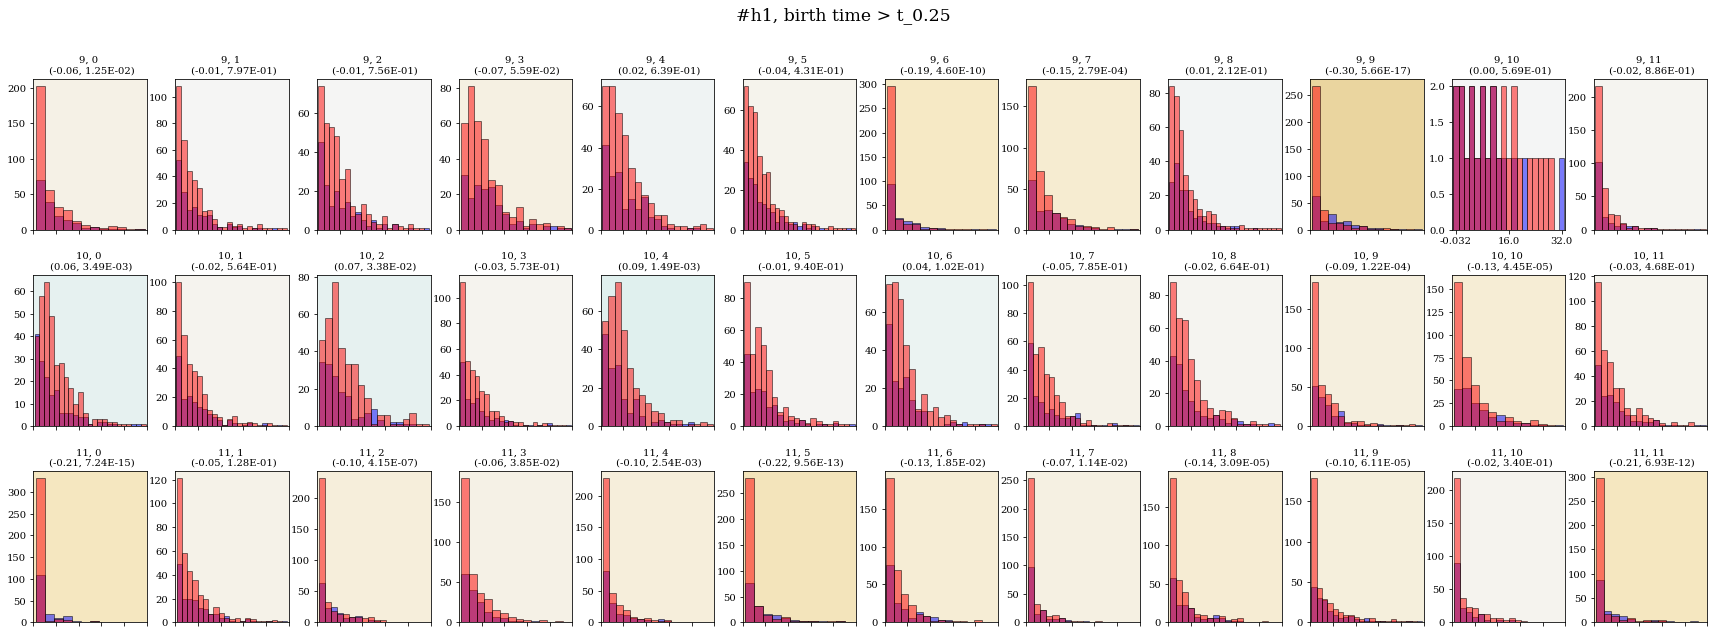

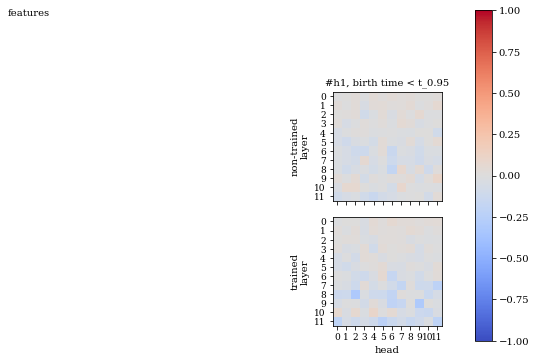

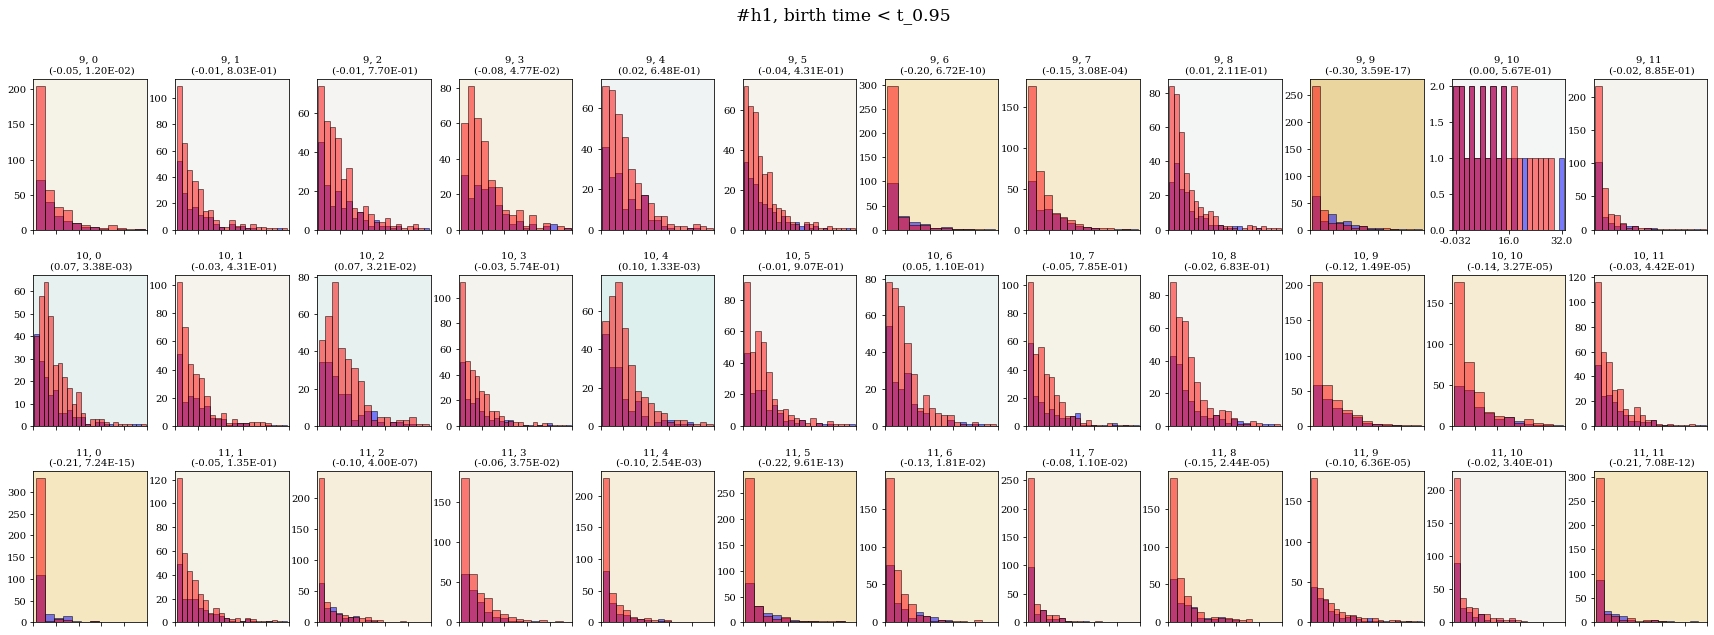

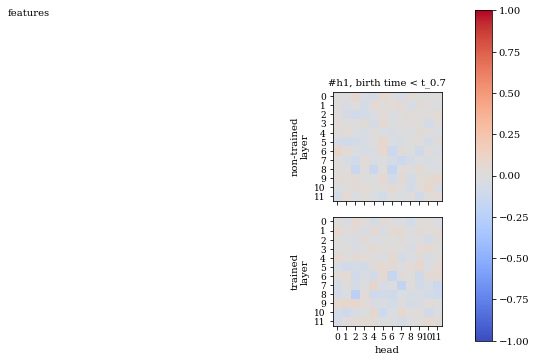

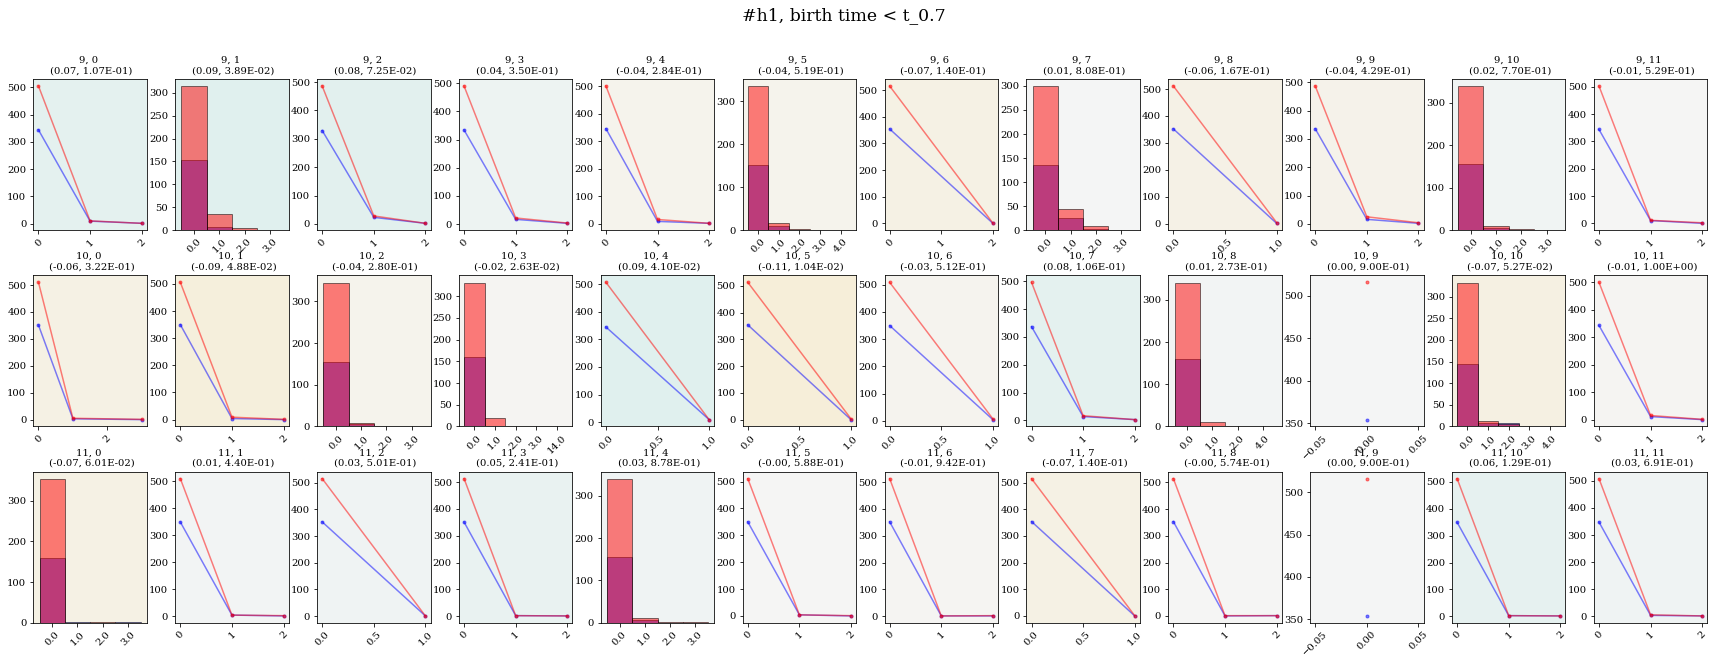

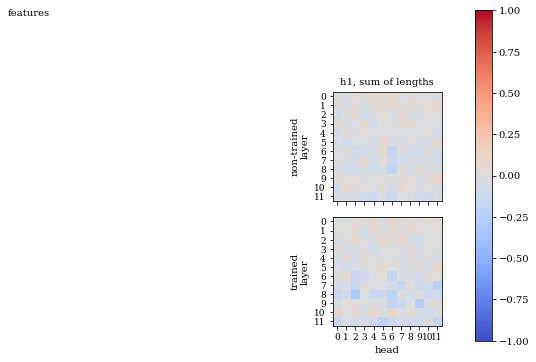

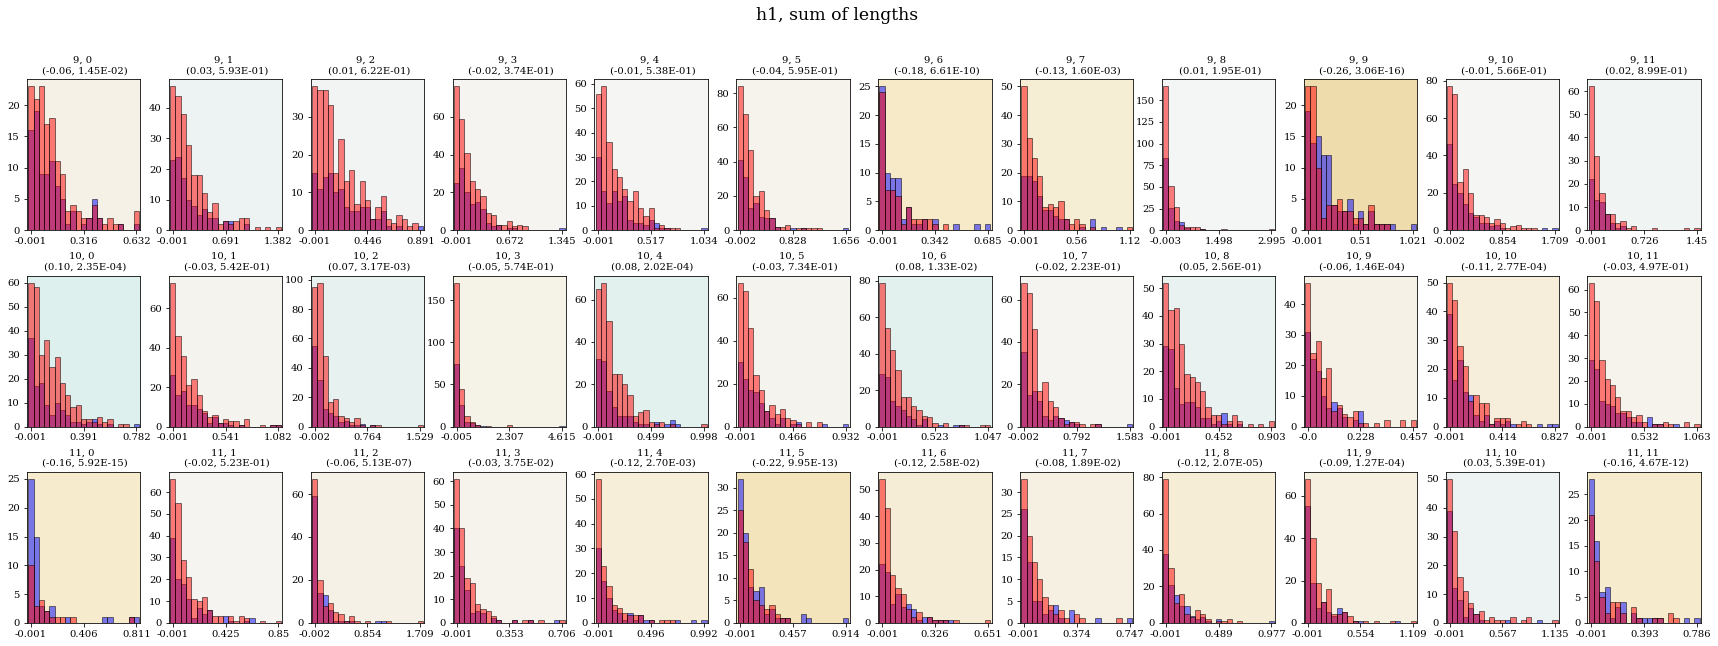

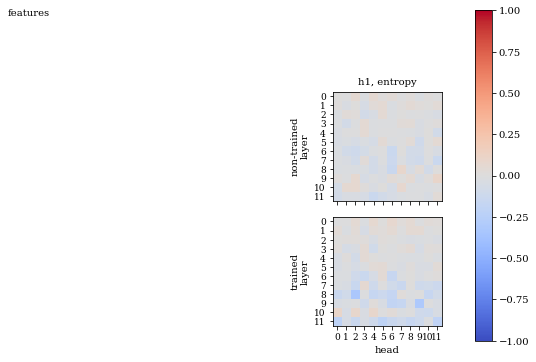

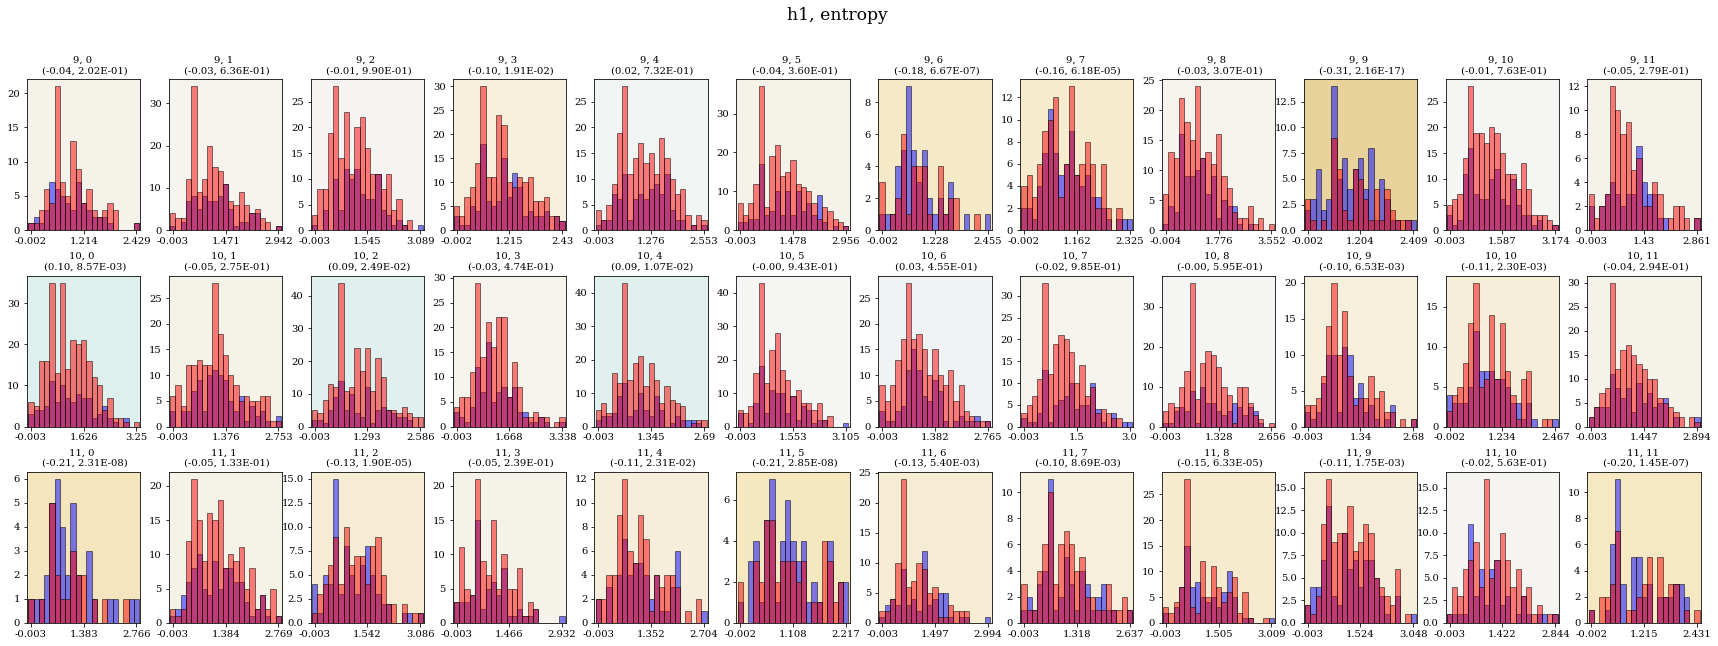

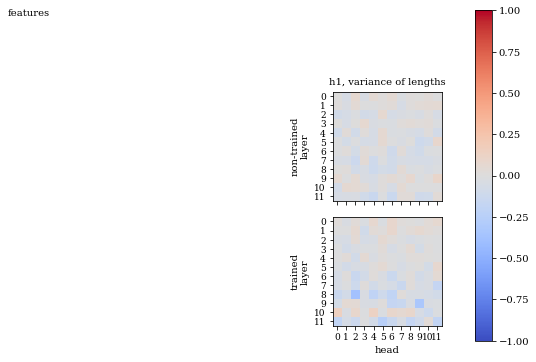

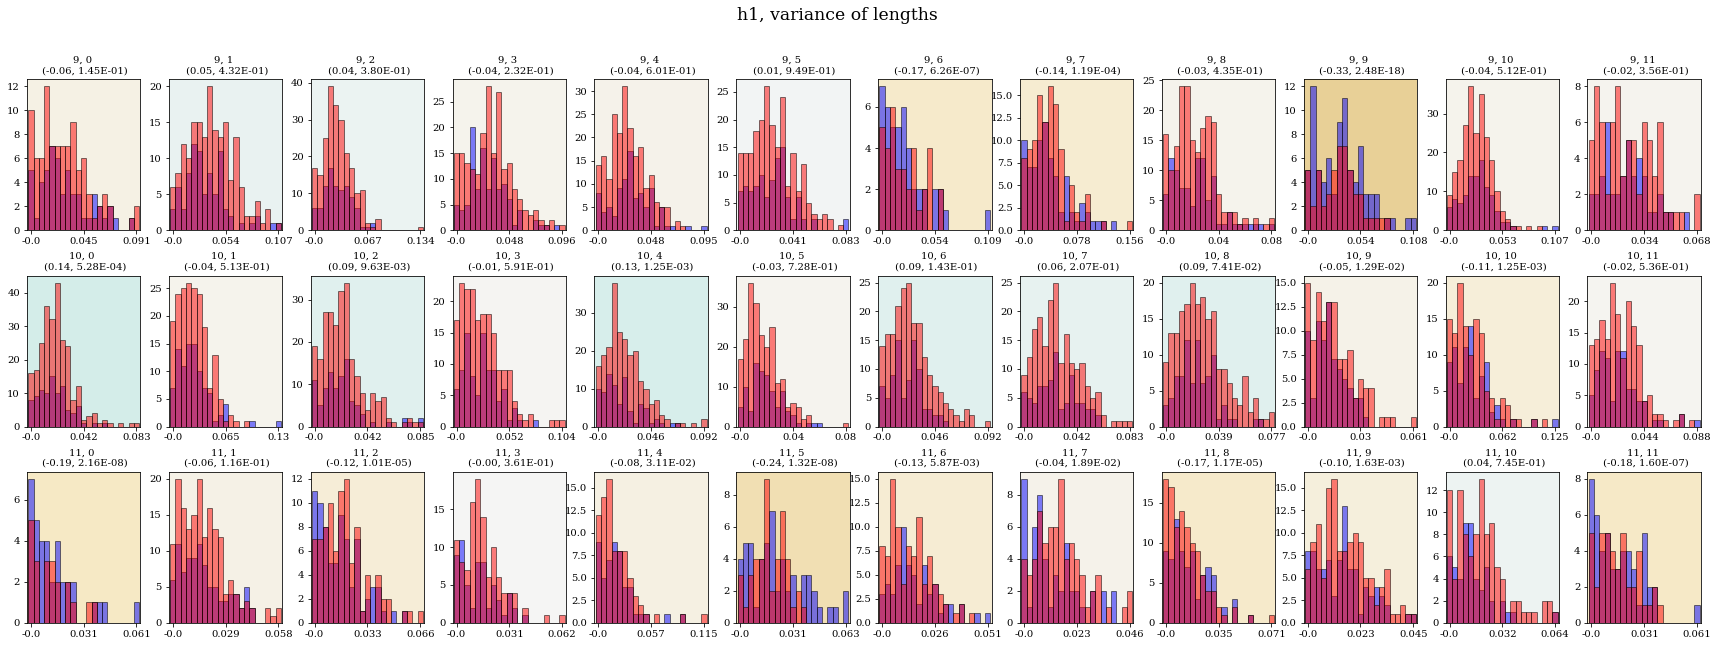

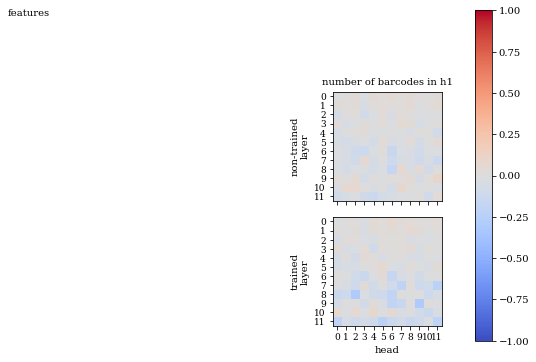

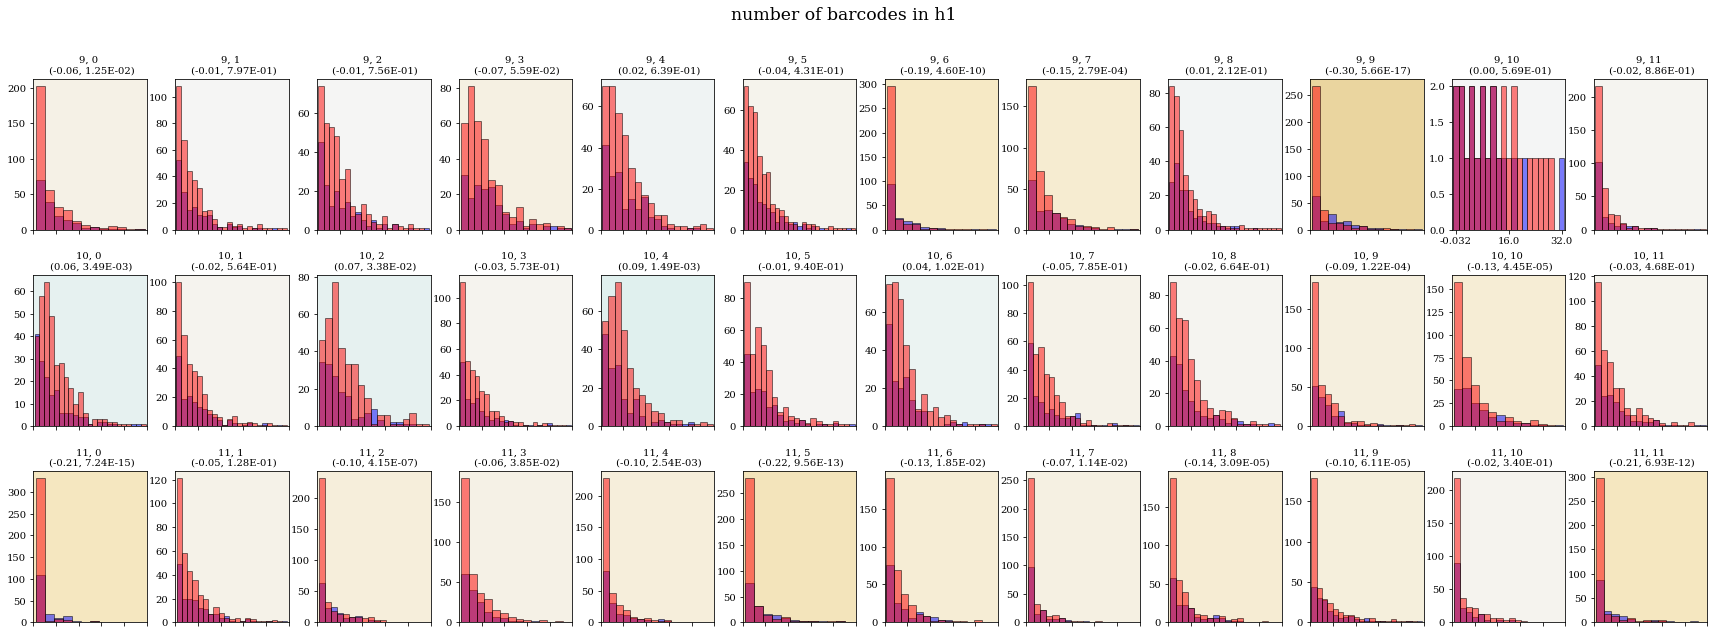

In [35]:
cur_matrices = find_values('barcode', matrices)
pdf = PdfPages(f"{output_dir}{subset}_bar_features_distributions.pdf")
for start, f in enumerate(barcode_feature_names):
    params  = [barcode_features_tr, barcode_get_layer_head, barcode_feature_names]
    names_i = [barcode_titles[f]]
    data = make_comparison_data(cur_matrices[0], matrices['barcode']['corr'][1], [barcode_feature_names[start]], 
                                     names = [barcode_feature_names[start]])
    draw_heatmaps_trained_nontrained(data, thresholds=names_i,subtitles_font_size=10,
                                 subtitles_pad=7, topological = False)
    # cur_matrices, feature,params, y,colormap
    plot_bt_distributions(cur_matrices, params = params, y=y, colormap = colormap,feature = f, title = barcode_titles[f],  pdf_file = pdf)
pdf.close()        

## Template features' distributions

In [36]:
template_feature_names

['self', 'beginning', 'prev', 'next', 'comma', 'dot']

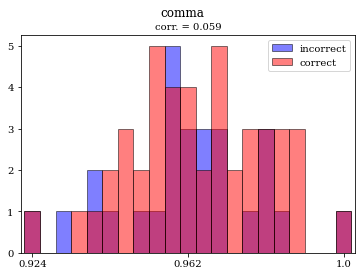

In [37]:
# example_template
cur_matrix = matrices['template']['corr'][0]
f = 'comma'
feat = f'{f}'
layer = 1
head = 1
fig, ax = plt.subplots()
fig.suptitle(f'{f}')
corr_coeff =cur_matrix[feat][layer,head]
plot_histogram(layer, head, feat,
        *[template_features_tr, template_get_layer_head],template_feature_names, y,
        ax=ax, title='corr. = %0.3f' % (corr_coeff,),
        legend=True,
        # color=colormap.to_rgba(corr_coeff)
        )

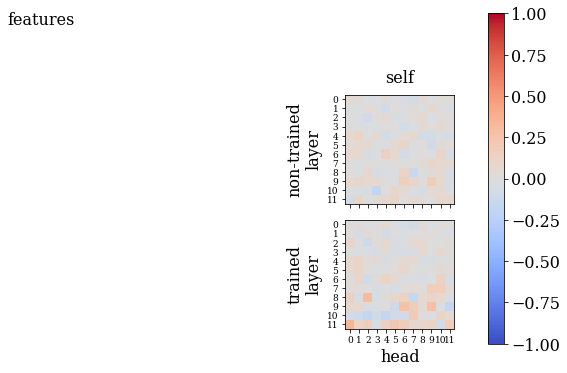

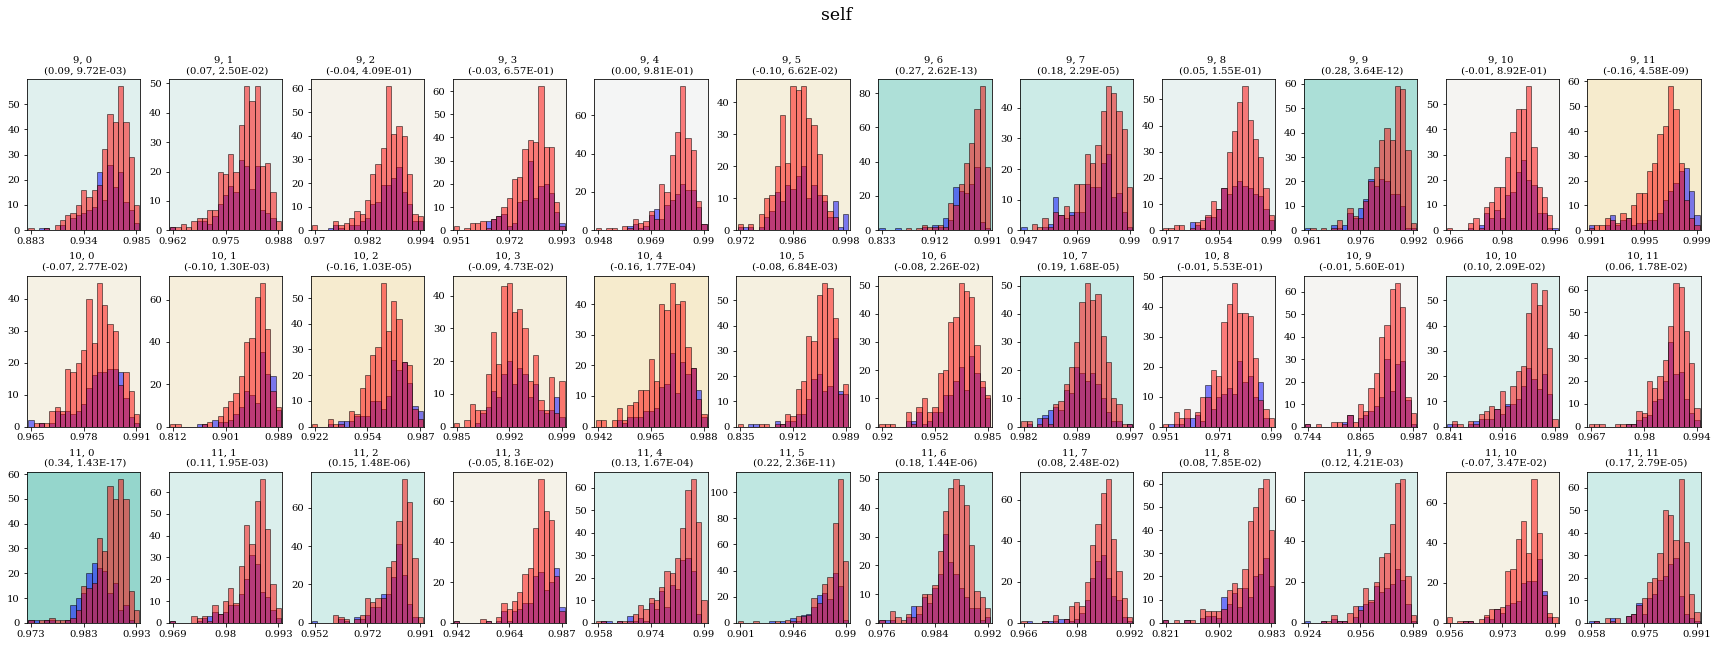

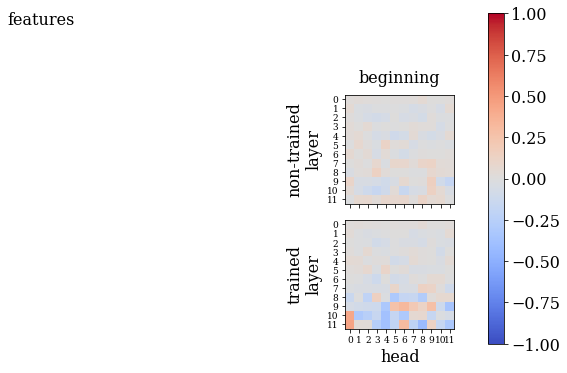

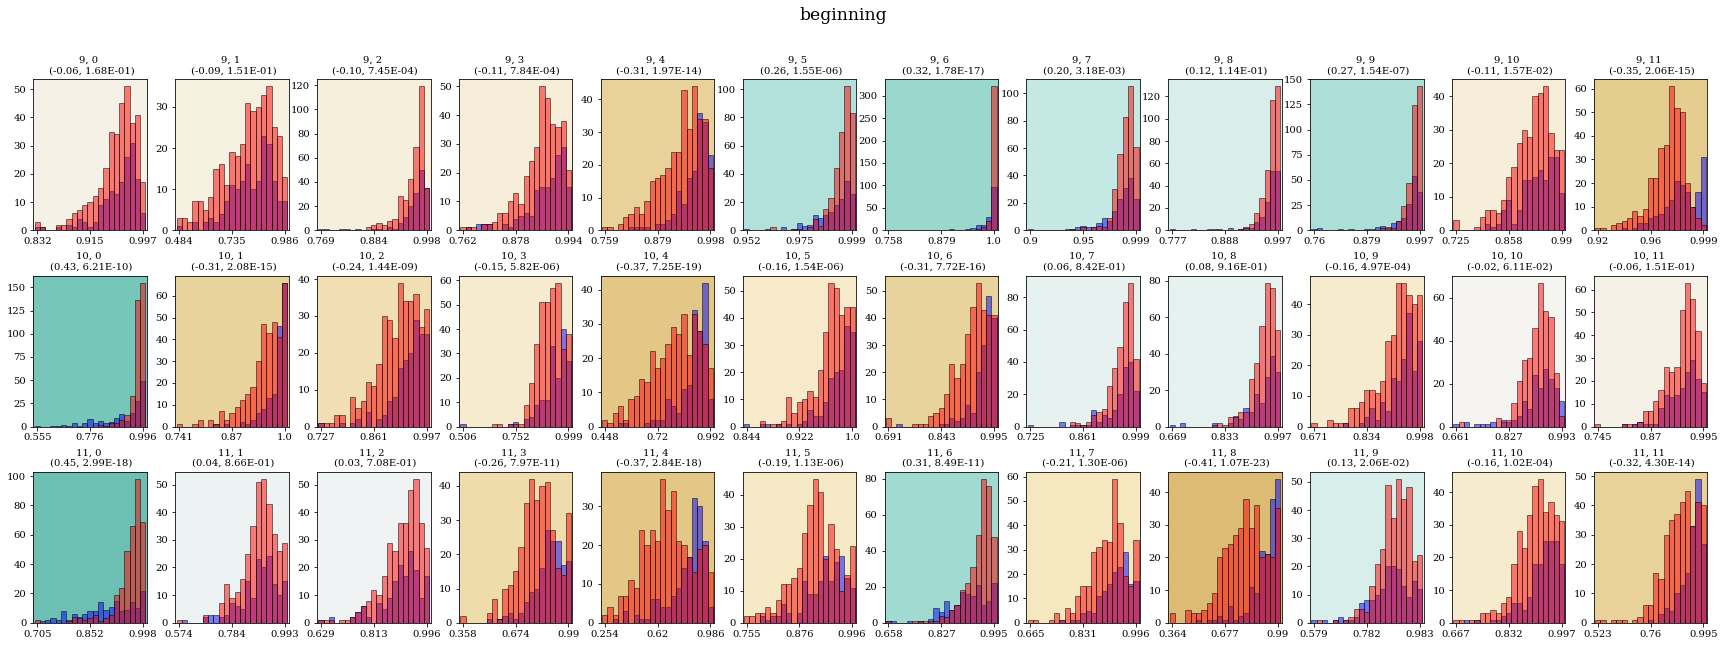

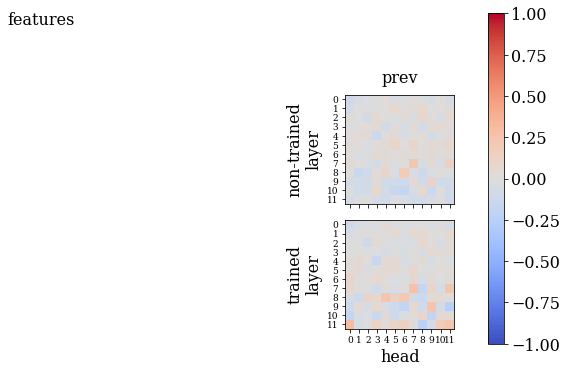

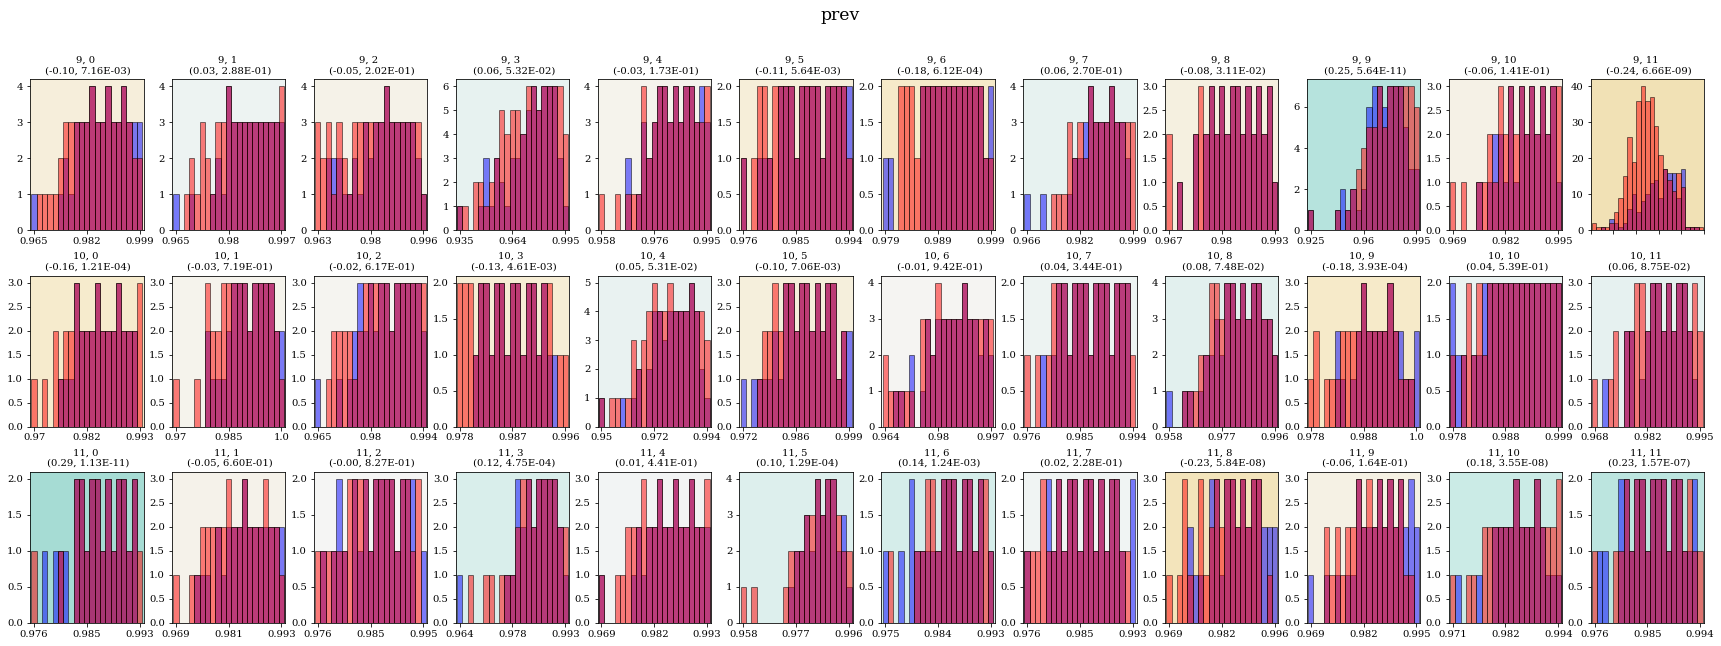

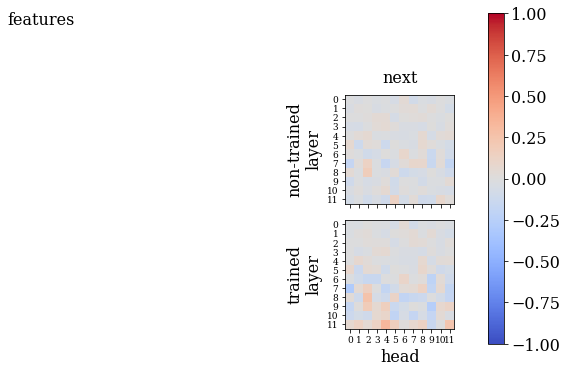

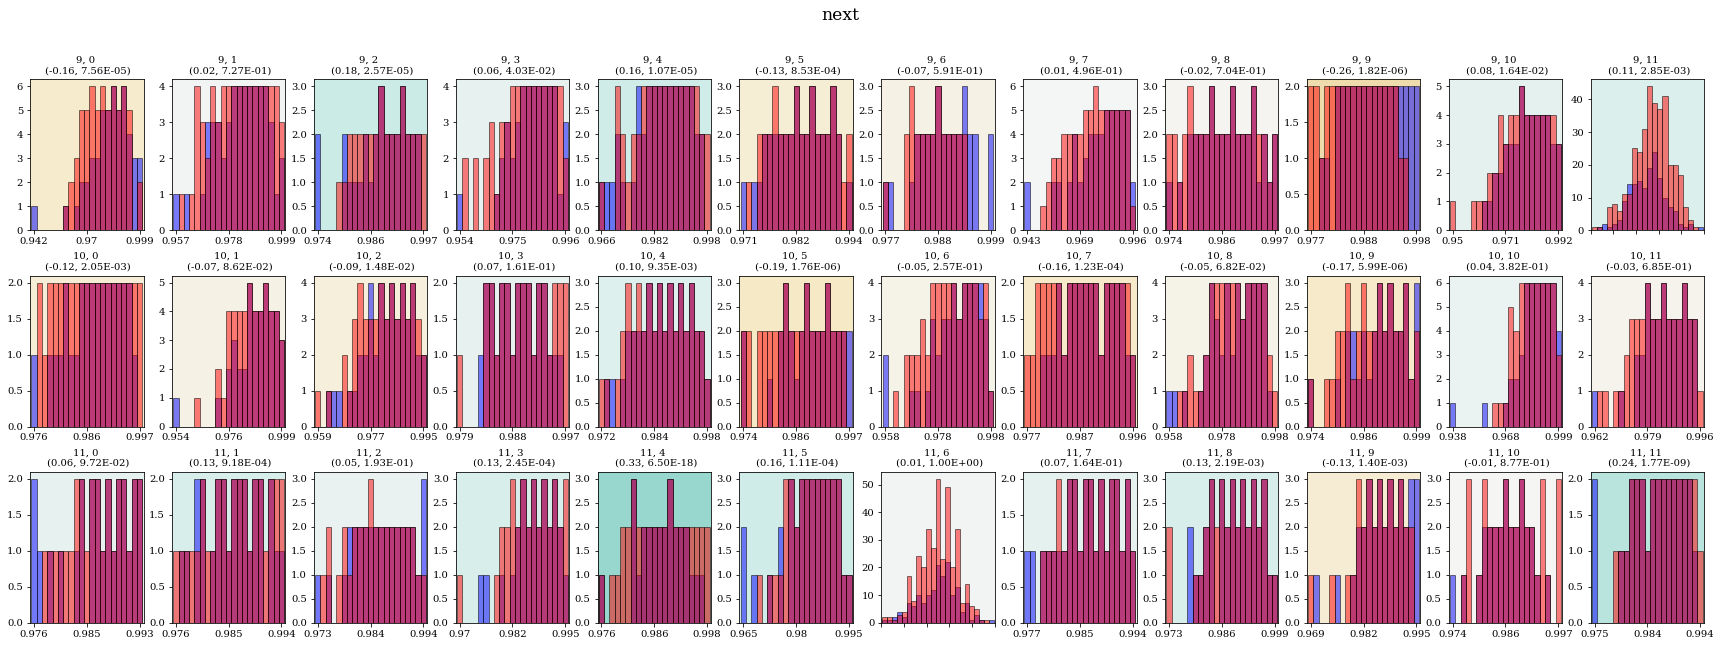

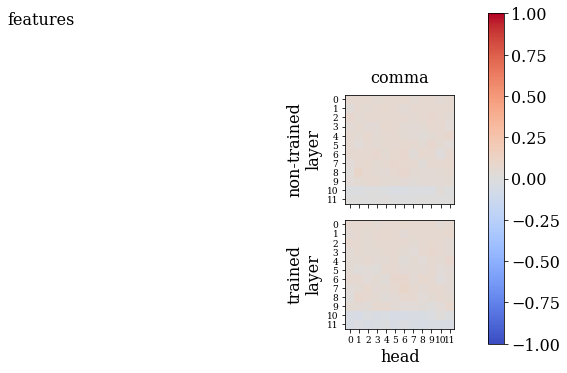

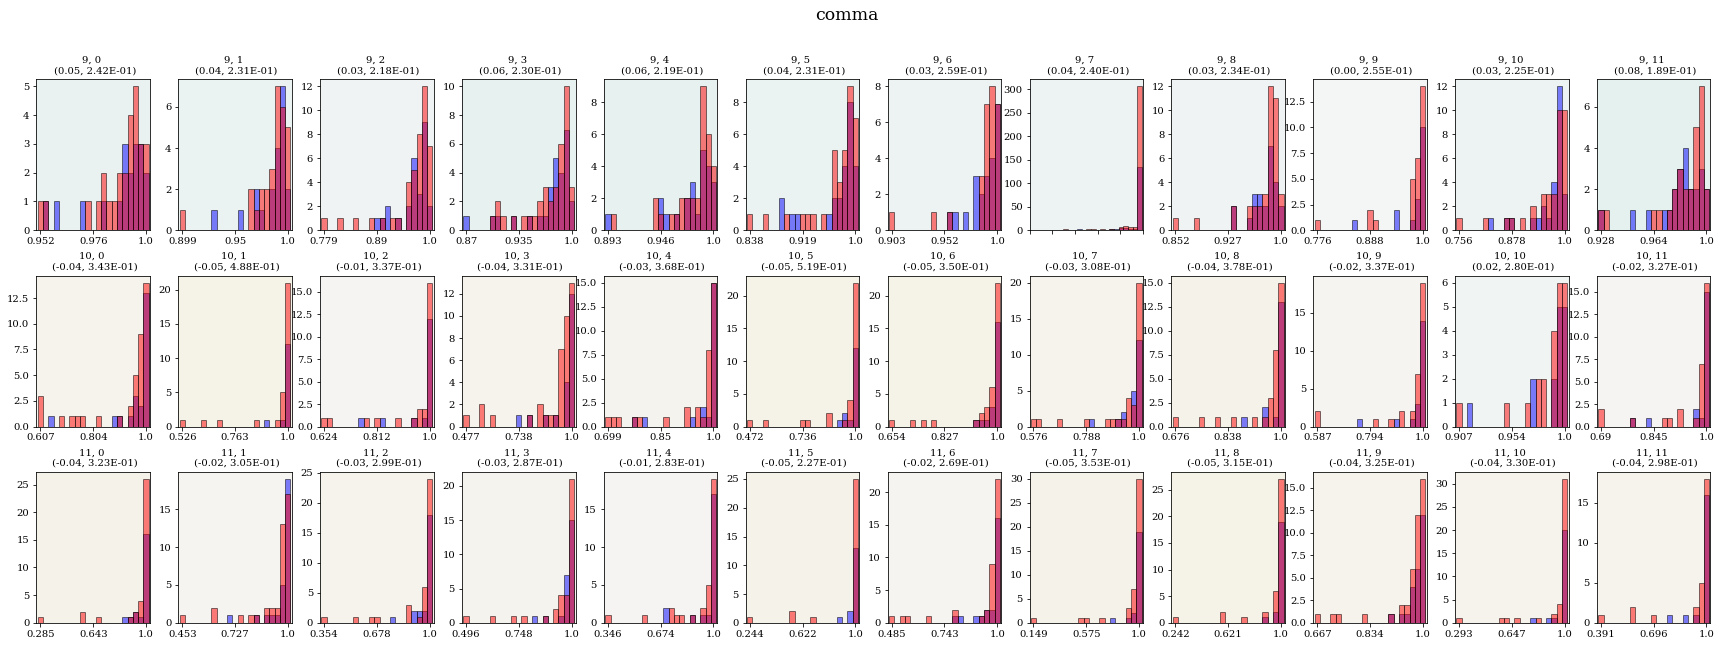

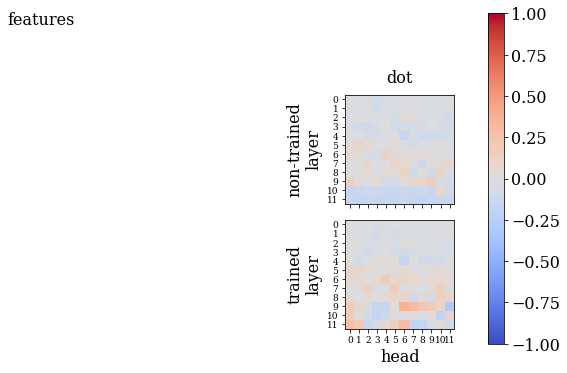

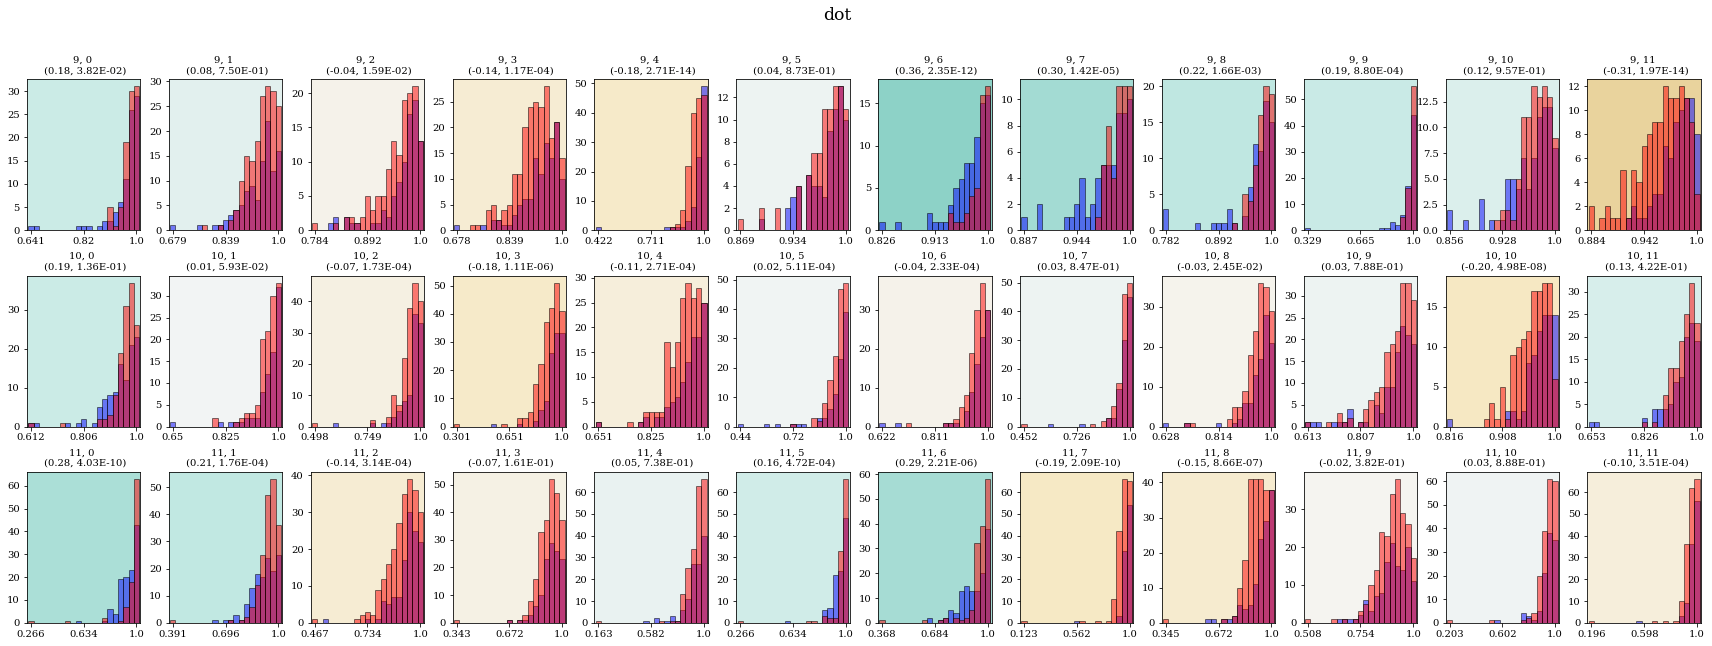

In [38]:
cur_matrices = find_values('template', matrices)
pdf = PdfPages(f"{output_dir}{subset}_template_features_distributions.pdf")
for f in template_feature_names:
    params  = [template_features_tr, template_get_layer_head,template_feature_names]
    data = make_comparison_data(cur_matrices[0], matrices['template']['corr'][1], [f], names = [f])
    draw_heatmaps_trained_nontrained(data, thresholds=[f], topological = False) # pdf heatmaps are blurry
    plot_bt_distributions(cur_matrices,params = params, feature = f, y=y,colormap=colormap, pdf_file = pdf)
pdf.close()     

# Features tables

<a id='features_tables'></a>

In [39]:
for model in range(len(matrices['barcode']['corr'])):
    df = pd.DataFrame(columns = ['feature', 'type', 'corr', 'p_value'])
    model_name = 'nt'
    if not model:model_name = 'tr';
    for feature_type in matrices.keys():
        for feature in matrices[feature_type]['corr'][0].keys():
                for layer in range(matrices[feature_type]['corr'][model][feature].shape[0]):
                    for head in range(matrices[feature_type]['corr'][model][feature].shape[-1]):
                        corr_coef_i = matrices[feature_type]['corr'][model][feature][layer, head]
                        p_value_i = matrices[feature_type]['stat'][model][feature][layer, head]
                        df = df.append({'feature': f'{feature}_{layer}_{head}',
                                'type' : feature_type,
                                'corr': corr_coef_i,
                                'p_value': p_value_i,}, 
                                ignore_index=True)
                df.to_csv(f'{tables_dir}{subset}_{model_name}.csv', index = False)            
df

feature         type      corr   p_value
0     s_t0.025_0_0  topological  0.029809  0.501389
1     s_t0.025_0_1  topological -0.037163  0.886421
2     s_t0.025_0_2  topological  0.000000  0.900000
3     s_t0.025_0_3  topological  0.030768  0.799741
4     s_t0.025_0_4  topological  0.013110  0.767039
...            ...          ...       ...       ...
8923      dot_11_7     template -0.150431  0.001057
8924      dot_11_8     template -0.166311  0.000224
8925      dot_11_9     template -0.141181  0.002463
8926     dot_11_10     template -0.148316  0.002000
8927     dot_11_11     template -0.145949  0.001745

[8928 rows x 4 columns]

In [40]:
# save features values
# topological_features_tr, topological_get_layer_head, y, names=topological_feature_names
for model in range(len(matrices[feature_type]['corr'])):
    df = pd.DataFrame()
    model_name = 'nt'
    if not model:model_name = 'tr';
    for feature_type in matrices.keys():
        for layer in range(12):
            for head in range(12):
                matrix = topological_features_tr
                exec(f'matrix = {feature_type}_features_{model_name}')
                function = topological_get_layer_head
                exec(f'function = {feature_type}_get_layer_head')
                names = topological_feature_names
                exec(f'names = {feature_type}_feature_names')
                features_values = function(matrix, layer, head, names)
                for feature in features_values.columns:
                    df[f'{feature}_{layer}_{head}'] = features_values.loc[:, feature]           
    df.to_csv(f'{tables_dir}all_features_{subset}_{model_name}.csv', index = False)                     
df

s_t0.025_0_0  s_t0.05_0_0  s_t0.1_0_0  s_t0.25_0_0  s_t0.5_0_0  \
0             1.0          1.0         2.0          9.0         9.0   
1             1.0          3.0        21.0         22.0        22.0   
2             1.0          1.0         5.0         12.0        12.0   
3             1.0          1.0        19.0         19.0        19.0   
4             1.0          1.0        13.0         14.0        14.0   
..            ...          ...         ...          ...         ...   
511           1.0          1.0         1.0          7.0         7.0   
512           1.0          1.0         1.0          9.0         9.0   
513           1.0          1.0         2.0         12.0        12.0   
514           1.0          1.0         1.0         11.0        11.0   
515           1.0          1.0         1.0          9.0         9.0   

     s_t0.75_0_0  w_t0.025_0_0  w_t0.05_0_0  w_t0.1_0_0  w_t0.25_0_0  ...  \
0            9.0           1.0          1.0         1.0          8.0  ...   
1           22.0           1.0          1.0        15.0         22.0  ...   
2           12.0           1.0          1.0         1.0         10.0  ...   
3           19.0           1.0          1.0        12.0         19.0  ...   
4           14.0           1.0          1.0         1.0         13.0  ...   
..           ...           ...          ...         ...          ...  ...   
511          7.0           1.0          1.0         1.0          5.0  ...   
512          9.0           1.0          1.0         1.0          7.0  ...   
513         12.0           1.0          1.0         1.0         12.0  ...   
514         11.0           1.0          1.0         1.0         10.0  ...   
515          9.0           1.0          1.0         1.0          8.0  ...   

     prev_11_10  next_11_10  comma_11_10  dot_11_10  self_11_11  \
0      0.992188    0.986816     1.000000   0.986328    0.986902   
1      0.987305    0.986328     0.803711   0.748047    0.984134   
2      0.989258    0.988281     0.649414   0.580566    0.984498   
3      0.984863    0.987305     0.765625   0.721191    0.984937   
4      0.986816    0.987793     1.000000   0.988770    0.984656   
..          ...         ...          ...        ...         ...   
511    0.991699    0.990234     1.000000   0.992676    0.988648   
512    0.989258    0.985840     1.000000   0.720703    0.986705   
513    0.993652    0.987793     1.000000   0.990234    0.989087   
514    0.989258    0.987793     1.000000   0.390381    0.987170   
515    0.991699    0.988281     1.000000   0.983398    0.986372   

     beginning_11_11  prev_11_11  next_11_11  comma_11_11  dot_11_11  
0           0.972257    0.994141    0.988770     1.000000   0.995117  
1           0.987389    0.985840    0.985840     0.794434   0.736328  
2           0.987383    0.990723    0.988770     0.684570   0.615234  
3           0.990225    0.987793    0.986328     0.708496   0.647949  
4           0.983219    0.987793    0.987793     1.000000   0.990234  
..               ...         ...         ...          ...        ...  
511         0.991528    0.993164    0.989258     1.000000   0.997559  
512         0.990830    0.990723    0.987305     1.000000   0.795898  
513         0.971920    0.993164    0.989258     1.000000   0.995117  
514         0.961494    0.989258    0.990723     1.000000   0.414795  
515         0.963149    0.994141    0.987793     1.000000   0.993652  

[516 rows x 8928 columns]

# Top-n features w.r.t p_value

In [41]:
n = 60
trained = False

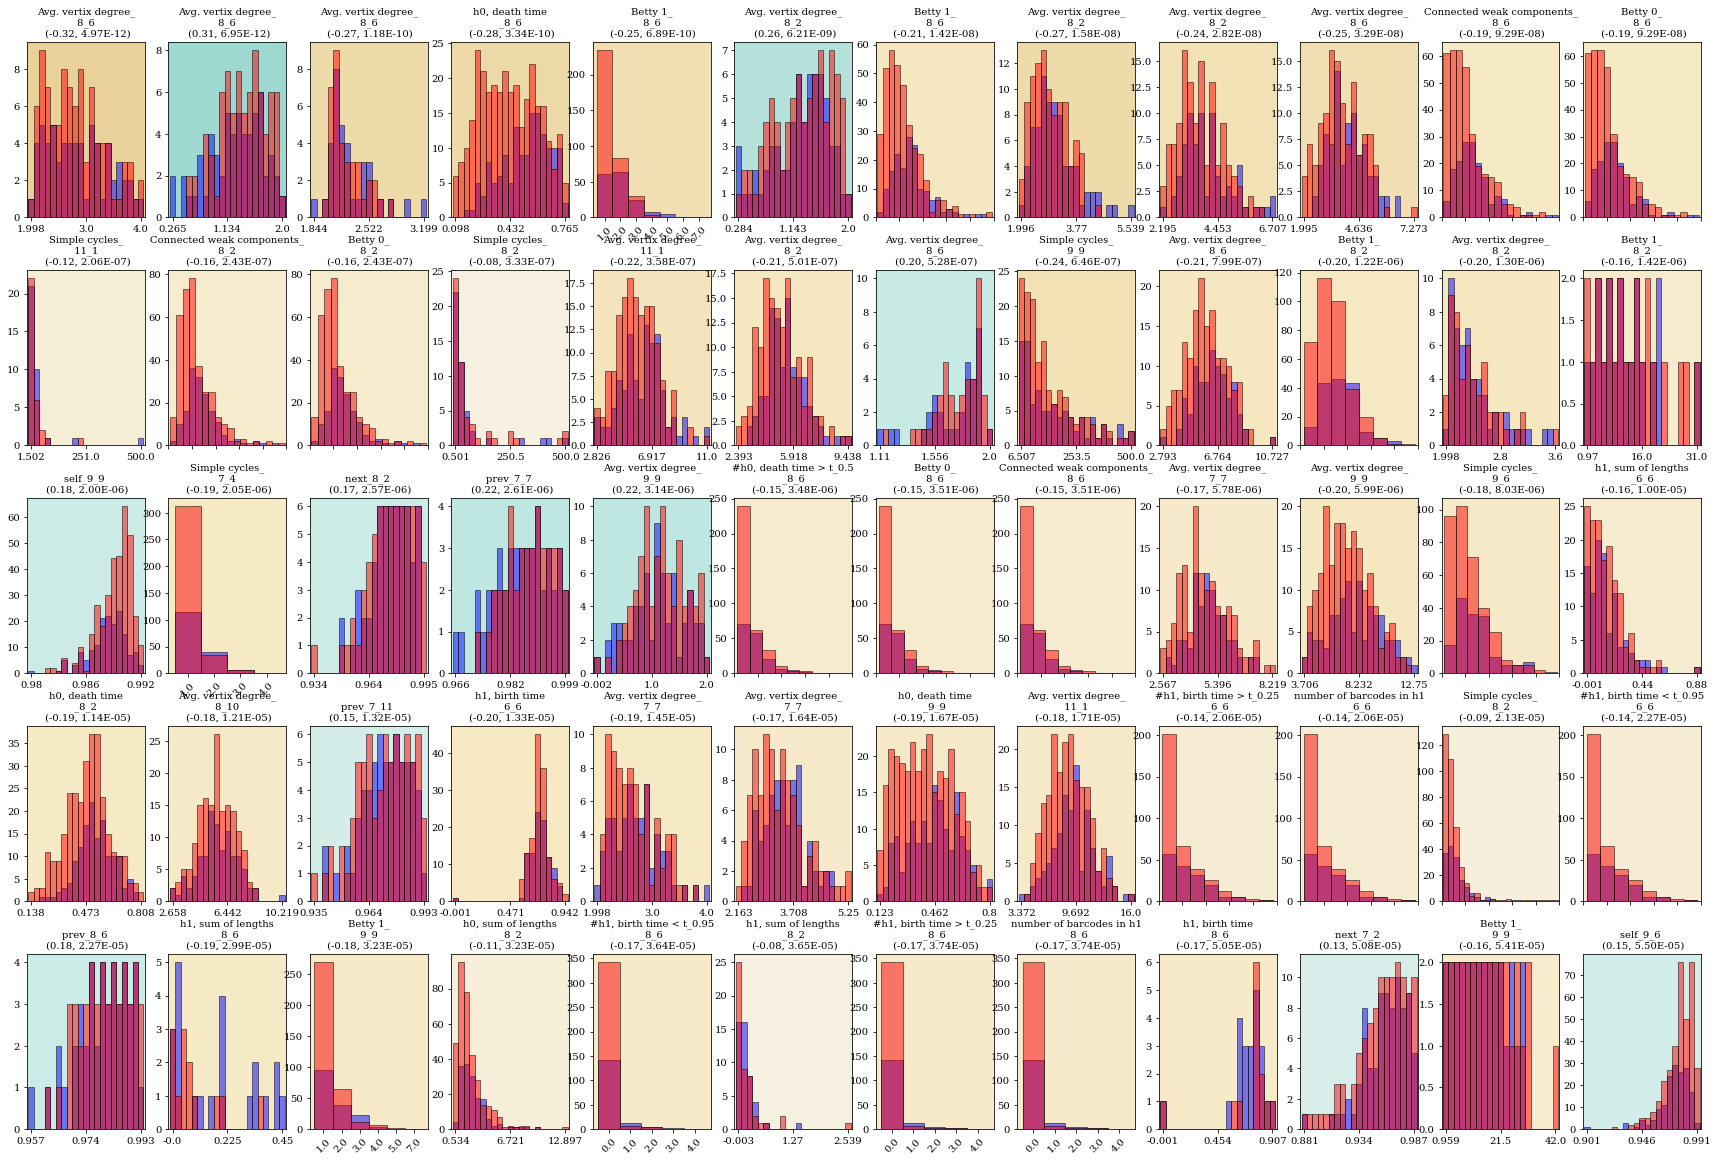

In [42]:
fig, axes = plt.subplots(nrows=ceil(n/12), ncols=12, figsize=(30, 20))
plt.subplots_adjust(hspace = 0.3)
model_chosen = 'tr' if trained else 'nt'
features_all = pd.read_csv(f"{tables_dir}{subset}_{model_name}.csv")
sorted_by_p = features_all.sort_values(by=['p_value']).reset_index(drop=True)
sorted_by_p = sorted_by_p.iloc[:n,:]
pdf = PdfPages(f"{output_dir}{subset}_top_{n}_distributions_{model_chosen}.pdf")
r, c = 0,0 
for row in range(sorted_by_p.shape[0]):
    features_func = template_features_tr
    get_layer_func = template_get_layer_head
    exec(f"features_func = {sorted_by_p.loc[row, 'type']}_features_{model_chosen}")
    exec(f"get_layer_func = {sorted_by_p.loc[row, 'type']}_get_layer_head")
    params  = [features_func, get_layer_func]
    # print(sorted_by_p.loc[row, :])
    # plot_top_n_distributions(cur_matrices, f"{sorted_by_p.loc[row, 'feature']}", start_layer = start_layer, pdf_file = pdf)
    feature = f"{sorted_by_p.loc[row, 'feature']}"
    layer, head = int(feature.split('_')[-2]), int(feature.split('_')[-1])
    feat = '_'.join(feature.split('_')[:-2])
    corr_coeff = sorted_by_p.loc[row, 'corr']
    p_val = sorted_by_p.loc[row, 'p_value']
    name_feature = ''
    names = topological_feature_names
    type_i = sorted_by_p.loc[row, 'type']
    exec(f'names = {type_i}_feature_names')
    try:
        feature_i = topological_titles[feature.split('_')[0]]
        name_feature = f'{feature_i}_\n {layer}_{head}'

    except:
        try:
            name_feature = f'{barcode_titles[feat]}\n _{layer}_{head}'
        except:
            name_feature = feature
    plot_histogram(layer, head, feat,
            *params, names, y,
            ax=axes[r,c],title = '%s \n (%0.2f, %.2E)'  % (name_feature, corr_coeff, p_val),
            color=colormap.to_rgba(corr_coeff)
            )
        
    c+=1
    if c== 12:
        r+=1
        c =0
pdf.savefig(fig)
plt.show()
pdf.close()     